<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/UK/RDSA/RDSA_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "RDSA.AS"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close    Volume
Date                                                       
2009-01-02  18.65  19.75  18.65  19.68      10.71   5717100
2009-01-05  19.98  20.10  19.37  20.08      10.93  19556820
2009-01-06  20.20  20.95  19.97  20.57      11.19  19556820
2009-01-07  20.50  20.57  19.77  20.07      10.92  19556820
2009-01-08  19.80  20.39  19.68  20.28      11.04  19556820
...           ...    ...    ...    ...        ...       ...
2018-12-21  24.85  25.15  24.73  25.15      24.32  20535890
2018-12-24  25.22  25.26  25.02  25.03      24.21   3124594
2018-12-27  25.50  25.54  24.64  24.95      24.13   9251440
2018-12-28  25.15  25.58  25.12  25.50      24.67   7727230
2018-12-31  25.74  25.86  25.58  25.66      24.81   2458190

[2558 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2558.000000  2558.000000  2558.000000  2558.000000  2558.000000  2.558000e+03
mean     24.695352    24.896212    24.477897    24.692963    17.924676  7.541642e+06
std       3.144362     3.136839     3.164775     3.150835     4.360007  3.511994e+06
min      15.710000    16.370000    15.270000    15.380000     8.490000  6.489900e+05
25%      22.552500    22.800000    22.330000    22.570000    15.332500  5.203394e+06
50%      25.095000    25.275000    24.890000    25.110000    17.590000  6.784288e+06
75%      26.850000    27.037500    26.660000    26.840000    20.750000  9.049118e+06
max      31.270000    31.380000    31.080000    31.350000    29.310000  3.098321e+07

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close    Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2009-03-13  17.50  17.78  17.38  17.52       9.67   9019400   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  16.735394  17.442840  15.472241  17.043507  17.054268  16.653609      16.730      16.690  15.270000  16.77500  17.401878  16.7590  17.008333  16.77500  17.273333  17.434161               17.770942                 16.77500               15.779058               18.268913                 16.77500               15.281087               18.766884                 16.77500               14.783116               19.264854                 16.77500               14.285146  17.054268  17.295426  17.280232               18.050210                17.054268               16.058327               18.548181                17.054268               15.560356               19.046152                17.054268               15.062385               19.544123                17.054268   
2009-03-16  17.65  17.85  17.35  17.78       9.82   8354900   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  17.257697  17.396554  15.610707  17.332607  17.215542  16.846353      16.860      16.870  15.470800  16.94750  17.710761  16.9750  17.231667  16.94750  17.650000  17.359564               18.090992                 16.94750               15.804008               18.662739                 16.94750               15.232261               19.234485                 16.94750               14.660515               19.806231                 16.94750               14.088769  17.215542  17.653309  17.223766               18.359034                17.215542               16.072050               18.930781                17.215542               15.500303               19.502527                17.215542               14.928557               20.074273                17.215542   
2009-03-17  17.61  17.69  17.07  17.47   

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2.508000e+03  2508.000000  2508.000000  2508.000000    2508.000000   2508.000000     2508.000000     2508.000000       2508.000000  2508.000000  2508.000000  2508.000000  2508.000000   2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000             2508.000000              2508.000000             2508.000000             2508.000000              2508.000000             2508.000000             2508.000000              2508.000000             2508.000000             2508.000000              2508.000000             2508.000000  2508.000000  2508.000000  2508.000000             2508.000000              2508.000000             2508.000000             2508.000000              2508.000000             2508.000000             2508.000000   
mean     24.814948    25.013744    24.600865    24.812771    18.077771  7.443890e+06    15.785486     1.998006   186.278708      30.463317      0.033094        0.027911        0.010367          0.007974     6.626396     2.540670    27.013955     1.998006      2.013158    27.013955    24.793246    24.772142     1.386713    24.812763    24.800912    24.819604    24.789864    24.765604    24.697452    24.800989    24.813044    24.801061    24.804965    24.800989    24.810466    24.777491               25.436260                24.800989               24.165718               25.753895                24.800989               23.848083               26.071530                24.800989               23.530447               26.389166                24.800989               23.212812    24.800912    24.810312    24.780858               25.436183                24.800912               24.165641               25.753818                24.800912               23.848006               26.071454   
std       3.053153     3.049847     3.067621     3.059274     4.263839  3.394542e+06     8.737829     1.408701   103.689863       0.785698      0.178918        0.164750        0.101309          0.088961     3.397654     1.106757    14.830494     1.408701      1.412600    14.830494     3.038980     3.013552    24.886141     3.066859     3.040595     3.069158     3.047597     3.045849     3.116350     3.051056     3.064520     3.055888     3.049648     3.051056     3.056067     3.039253                3.055883                 3.051056                3.094646                3.076471                 3.051056                3.134054                3.108902                 3.051056                3.184665                3.152810                 3.051056                3.245957     3.040595     3.053381     3.041333                3.045387                 3.040595                3.084385                3.066020                 3.040595                3.123947                3.098534   
min      16.200000    16.400000    15.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close    Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2009-03-13  0.086264  0.092123  0.095710  0.090730   0.037255   9019400   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.027261  0.049766  0.760925  0.057818  0.046089  0.003915    0.031702    0.028433  0.000000  0.033703  0.087199  0.033628  0.048979  0.033703  0.074221  0.060252                0.081864                 0.033703                0.005805                0.101973                 0.033703                0.003238                0.120214                 0.033703                0.024662                0.136838                 0.033703                0.057296  0.046089  0.075101  0.051670                0.096253                 0.046089                0.033078                0.116335                 0.046089                0.028786                0.134491                 0.046089                0.041765                0.150986                 0.046089   
2009-03-16  0.096218  0.096796  0.093729  0.107824   0.044608   8354900   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.063214  0.046338  0.763174  0.076830  0.057267  0.017638    0.040662    0.040915  0.012464  0.045568  0.107343  0.048317  0.064130  0.045568  0.099108  0.054870                0.102251                 0.045568                0.007495                0.125838                 0.045568                0.000000                0.147235                 0.045568                0.016885                0.166733                 0.045568                0.045522  0.057267  0.098814  0.047616                0.116644                 0.057267                0.034003                0.140325                 0.057267                0.024817                0.161735                 0.057267                0.033241                0.181185                 0.057267   
2009-03-17  0.093563  0.086115  0.075248  0.0874

140171

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.3" 2019-04-16; OpenJDK Runtime Environment (build 11.0.3+7-Ubuntu-1ubuntu218.04.1); OpenJDK 64-Bit Server VM (build 11.0.3+7-Ubuntu-1ubuntu218.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpn40hz14_
  JVM stdout: /tmp/tmpn40hz14_/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpn40hz14_/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    1 month and 5 days
H2O cluster name:           H2O_from_python_unknownUser_4qag48
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190724_234518_mod...  0.575429  0.692199              0.459841  0.499526  0.249526
1  DeepLearning_grid_1_AutoML_20190724_234518_mod...  0.565587  0.698342              0.488000  0.501876  0.251879
2  DeepLearning_grid_1_AutoML_20190724_234518_mod...  0.542032  0.856156              0.488000  0.555086  0.308121
3  DeepLearning_grid_1_AutoML_20190724_234518_mod...  0.520825  3.751562              0.467778  0.666341  0.444010
4  DeepLearning_grid_1_AutoML_20190724_234518_mod...  0.502413  1.213747              0.500000  0.610786  0.373060
5  DeepLearning_grid_1_AutoML_20190724_234518_mod...  0.500000  0.693725              0.500000  0.500289  0.250289
6  DeepLearning_grid_1_AutoML_20190724_234518_mod...  0.500000  0.694033              0.500000  0.500442  0.250443
7  DeepLearning_grid_1_AutoML_20190724_234518_mod...  0.500000  0.704259              0.500000  0.505460  0.255490
8              DeepLearning_1_AutoML_20190724_234518  0.486444  0.761828              0.491968  0.515679  0.265925
9  DeepLearning_grid_1_AutoML_20190724_234518_mod...  0.458095  0.737575              0.496000  0.520290  0.270701

variable  relative_importance  scaled_importance  percentage
0                   dayofweek             1.000000           1.000000    0.001115
1                     weekday             0.983825           0.983825    0.001097
2          CDLEVENINGDOJISTAR             0.977988           0.977988    0.001091
3                        COSH             0.970127           0.970127    0.001082
4                 AROONOSC_24             0.969201           0.969201    0.001081
...                       ...                  ...                ...         ...
1035  BBANDS_lowerband_24_7_3             0.785410           0.785410    0.000876
1036             CDLTASUKIGAP             0.782551           0.782551    0.000873
1037                CDLHARAMI             0.780572           0.780572    0.000871
1038         CDLCOUNTERATTACK             0.775675           0.775675    0.000865
1039              CDLHIGHWAVE             0.761383           0.761383    0.000849

[1040 rows x 4 columns]

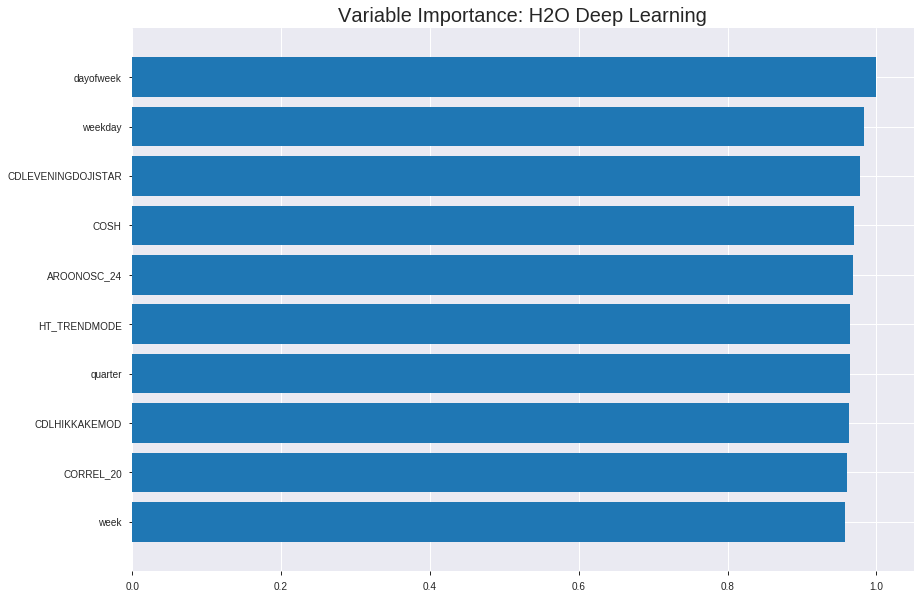

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190724_234518_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24613923894118706
RMSE: 0.4961242172492561
LogLoss: 0.6851665694079794
Mean Per-Class Error: 0.45370308910710677
AUC: 0.5542484170522356
pr_auc: 0.5868119254025124
Gini: 0.1084968341044712
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.464410850308465: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      34   815   0.96     (815.0/849.0)
1      13   892   0.0144   (13.0/905.0)
Total  47   1707  0.4721   (828.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.464411     0.683002  368
max f2                       0.402159     0.843115  393
max f0point5                 0.464411     0.576749  368
max accuracy                 0.488471     0.541049  274
max precision                0.759496     1         0
max recall                   0.402159     1         393
max specificity              0.759496     1         0
max absolute_mcc             0.562947     0.129451  86
max min_per_class_accuracy   0.490572     0.532597  258
max mean_per_class_accuracy  0.500138     0.546297  210

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 50.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102623                   0.691777           1.72277   1.72277            0.888889         0.717467  0.888889                    0.717467            0.0176796       0.0176796                  72.2775    72.2775
    2        0.0205245                   0.647221           1.6151    1.66894            0.833333         0.664278  0.861111                    0.690873            0.0165746       0.0342541                  61.5101    66.8938
    3        0.0302166                   0.603781           1.36809   1.57244            0.705882         0.622097  0.811321                    0.668813            0.0132597       0.0475138                  36.8086    57.2438
    4        0.0404789                   0.590127           1.50743   1.55596            0.777778         0.595085  0.802817                    0.650121            0.0154696       0.0629834                  50.7428    55.5957
    5        0.050171                    0.575736           1.25408   1.49764            0.647059         0.582506  0.772727                    0.637059            0.0121547       0.0751381                  25.4079    49.7639
    6        0.100342                    0.537087           0.969061  1.23335            0.5              0.553657  0.636364                    0.595358            0.0486188       0.123757                   -3.09392   23.335
    7        0.149943                    0.519407           1.04703   1.17172            0.54023          0.527756  0.604563                    0.572995            0.0519337       0.175691                   4.70312    17.1716
    8        0.200114                    0.507257           1.25537   1.19269            0.647727         0.513106  0.615385                    0.55798             0.0629834       0.238674                   25.5374    19.269
    9        0.299886                    0.497644           1.0189    1.13487            0.525714         0.501802  0.585551                    0.53929             0.101657        0.340331                   1.88982    13.487
    10       0.400228                    0.49289            0.969061  1.0933             0.5              0.494784  0.564103                    0.528132            0.0972376       0.437569                   -3.09392   9.32993
    11       0.5                         0.490555           0.952448  1.06519            0.491429         0.491592  0.549601                    0.52084             0.0950276       0.532597                   -4.75517   6.51934
    12       0.599772                    0.488798           0.985673  1.05197            0.508571         0.489669  0.542776                    0.515655            0.0983425       0.630939                   -1.43268   5.19652
    13       0.700114                    0.487046           0.947037  1.03693            0.488636         0.487864  0.535016                    0.511672            0.0950276       0.725967                   -5.29633   3.69266
    14       0.799886                    0.484619           0.885998  1.0181             0.457143         0.48598   0.525303                    0.508467            0.0883978       0.814365                   -11.4002   1.81009
    15       0.899658                    0.475833           0.996748  1.01573            0.514286         0.481152  0.524081                    0.505438            0.0994475       0.913812                   -0.325178  1.57329
    16       1                           0.317466           0.85894   1                  0.443182         0.46265   0.515964                    0.5



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24497793028580617
RMSE: 0.49495245255055176
LogLoss: 0.6828982301722558
Mean Per-Class Error: 0.4366113267097148
AUC: 0.5519717878939148
pr_auc: 0.630000176948259
Gini: 0.10394357578782953
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4339402047507282: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    218  0.9864   (218.0/221.0)
1      0    281  0        (0.0/281.0)
Total  3    499  0.4343   (218.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.43394      0.720513  396
max f2                       0.43394      0.865681  396
max f0point5                 0.467748     0.617875  377
max accuracy                 0.467748     0.567729  377
max precision                0.698285     1         0
max recall                   0.43394      1         396
max specificity              0.698285     1         0
max absolute_mcc             0.546507     0.138163  69
max min_per_class_accuracy   0.494867     0.533937  219
max mean_per_class_accuracy  0.502642     0.563389  167

Gains/Lift Table: Avg response rate: 55.98 %, avg score: 50.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.638634           1.48873   1.48873            0.833333         0.667742  0.833333                    0.667742            0.0177936       0.0177936                  48.8731   48.8731
    2        0.0219124                   0.621227           1.78648   1.62407            1                0.628815  0.909091                    0.650048            0.0177936       0.0355872                  78.6477   62.407
    3        0.0318725                   0.615631           1.42918   1.56317            0.8              0.618603  0.875                       0.640221            0.0142349       0.0498221                  42.9181   56.3167
    4        0.0418327                   0.597427           0.714591  1.36113            0.4              0.601945  0.761905                    0.631108            0.00711744      0.0569395                  -28.5409  36.1125
    5        0.0517928                   0.590649           1.42918   1.37421            0.8              0.592287  0.769231                    0.623642            0.0142349       0.0711744                  42.9181   37.4213
    6        0.101594                    0.562426           1.2148    1.29607            0.68             0.575487  0.72549                     0.600037            0.0604982       0.131673                   21.4804   29.6071
    7        0.151394                    0.545799           1.2148    1.26934            0.68             0.552097  0.710526                    0.584267            0.0604982       0.192171                   21.4804   26.9339
    8        0.201195                    0.533196           0.857509  1.1674             0.48             0.538978  0.653465                    0.573057            0.0427046       0.234875                   -14.2491  16.7401
    9        0.300797                    0.511839           1.14335   1.15944            0.64             0.52223   0.649007                    0.556227            0.113879        0.348754                   14.3345   15.9435
    10       0.400398                    0.500566           0.964698  1.11099            0.54             0.504774  0.621891                    0.543428            0.0960854       0.44484                    -3.53025  11.0993
    11       0.5                         0.495002           0.893238  1.06762            0.5              0.49732   0.59761                     0.534243            0.088968        0.533808                   -10.6762  6.76157
    12       0.599602                    0.490736           0.78605   1.02084            0.44             0.492944  0.571429                    0.527383            0.0782918       0.6121                     -21.395   2.08439
    13       0.699203                    0.488655           0.857509  0.997577           0.48             0.489517  0.558405                    0.521989            0.0854093       0.697509                   -14.2491  -0.242317
    14       0.798805                    0.484435           1.10762   1.0113             0.62             0.487341  0.566085                    0.517669            0.11032         0.807829                   10.7616   1.12974
    15       0.898406                    0.472958           1.03616   1.01405            0.58             0.478635  0.567627                    0.513341            0.103203        0.911032                   3.61566   1.40534
    16       1                           0.311694           0.875724  1                  0.490196         0.462145  0.559761                    0.50814         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-24 23:57:55  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-24 23:57:57  6 min 31.616 sec  342 obs/sec       0.40935   1             718        0.627989         3.92399             -0.579091      0.524773        0.378892           1.11508          0.482896                         0.629764           3.53435               -0.6094          0.509018          0.492693             1.48873            0.438247
    2019-07-24 23:58:24  6 min 58.350 sec  472 obs/sec       7.10205   17            12457      0.496124         0.685167            0.0144384      0.554248        0.586812           1.72277          0.472064                         0.494952           0.682898              0.00588689       0.551972          0.63                 1.48873            0.434263
    2019-07-24 23:58:49  7 min 23.560 sec  508 obs/sec       14.2326   34            24964      0.520073         0.744582            -0.0830071     0.528434        0.58272            1.83045          0.483466                         0.521088           0.739165              -0.101872        0.494348          0.572881             1.48873            0.440239
    2019-07-24 23:59:14  7 min 48.742 sec  534 obs/sec       21.8626   52            38347      0.495061         0.682298            0.0186584      0.574301        0.607756           1.83045          0.471494                         0.500747           0.694578              -0.0175247       0.582873          0.61864              1.48873            0.418327
    2019-07-24 23:59:41  8 min 15.071 sec  555 obs/sec       30.2902   72            53129      0.492875         0.676876            0.0273064      0.553727        0.586424           1.83045          0.473774                         0.495978           0.68517               0.00176332       0.521385          0.600677             1.48873            0.430279
    2019-07-25 00:00:06  8 min 40.548 sec  585 obs/sec       39.5696   94            69405      0.490963         0.672845            0.0348367      0.563618        0.626789           1.83045          0.468073                         0.496853           0.687021              -0.00176202      0.530217          0.591904             1.48873            0.434263
    2019-07-25 00:00:31  9 min  5.329 sec  608 obs/sec       48.8643   116           85708      0.489918         0.670654            0.0389428      0.589501        0.654731           1.93812          0.457241                         0.500012           0.693157              -0.0145405       0.519734          0.589694             1.48873            0.424303
    2019-07-25 00:00:57  9 min 31.483 sec  630 obs/sec       59.1231   140           103702     0.485907         0.660766            0.0546141      0.608501        0.667102           1.93812          0.450969                         0.500401           0.694187              -0.0161189       0.48397           0.548843             1.19098            0.430279
    2019-07-25 00:01:22

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
dayofweek                1.0                    1.0                  0.0011152520200945829
weekday                  0.9838245511054993     0.9838245511054993   0.0010972123180390543
CDLEVENINGDOJISTAR       0.9779884815216064     0.9779884815216064   0.0010907036296462051
COSH                     0.9701269268989563     0.9701269268989563   0.0010819360149722107
AROONOSC_24              0.969200611114502      0.969200611114502    0.0010809029394223525
---                      ---                    ---                  ---
BBANDS_lowerband_24_7_3  0.7854101061820984     0.7854101061820984   0.0008759302075222861
CDLTASUKIGAP             0.7825508713722229     0.7825508713722229   0.0008727414401246477
CDLHARAMI                0.7805716395378113     0.7805716395378113   0.0008705340978230845
CDLCOUNTERATTACK         0.7756749391555786     0.7756749391555786   0.0008650730428300016
CDLHIGHWAVE              0.7613826394081116     0.7613826394081116   0.0008491335266648418


See the whole table with table.as_data_frame()


('accuracy', 0.5697211155378487)

('F1', 0.6778711484593838)

('auc', 0.5754285714285714)

('logloss', 0.6921990240453284)

('mean_per_class_error', 0.4310476190476191)

('rmse', 0.49952587558043476)

('mse', 0.2495261003744)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


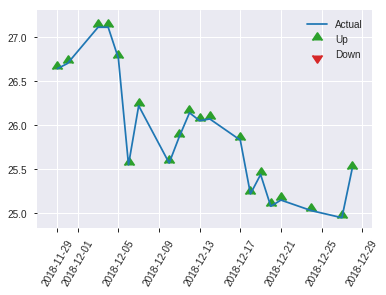


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2495261003744
RMSE: 0.49952587558043476
LogLoss: 0.6921990240453284
Mean Per-Class Error: 0.4310476190476191
AUC: 0.5754285714285714
pr_auc: 0.5749007428636047
Gini: 0.1508571428571428
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48612962138774163: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      15   110  0.88     (110.0/125.0)
1      5    121  0.0397   (5.0/126.0)
Total  20   231  0.4582   (115.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.48613      0.677871  230
max f2                       0.483601     0.836653  248
max f0point5                 0.48782      0.584989  194
max accuracy                 0.488647     0.569721  173
max precision                0.495952     0.785714  13
max recall                   0.483601     1         248
max specificity              0.513796     0.992     0
max absolute_mcc             0.493044     0.170914  34
max min_per_class_accuracy   0.48968      0.515873  122
max mean_per_class_accuracy  0.488647     0.568952  173

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 49.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.509259           1.32804   1.32804            0.666667         0.51128   0.666667                    0.51128             0.015873        0.015873                   32.8042    32.8042
    2        0.0239044                   0.505773           1.32804   1.32804            0.666667         0.506818  0.666667                    0.509049            0.015873        0.031746                   32.8042    32.8042
    3        0.0318725                   0.503976           0.996032  1.24504            0.5              0.505127  0.625                       0.508068            0.00793651      0.0396825                  -0.396825  24.504
    4        0.0438247                   0.500854           1.99206   1.44877            1                0.502145  0.727273                    0.506453            0.0238095       0.0634921                  99.2063    44.8773
    5        0.0517928                   0.496134           1.99206   1.53236            1                0.497791  0.769231                    0.50512             0.015873        0.0793651                  99.2063    53.2357
    6        0.103586                    0.493972           1.37912   1.45574            0.692308         0.49483   0.730769                    0.499975            0.0714286       0.150794                   37.9121    45.5739
    7        0.151394                    0.492894           0.996032  1.31057            0.5              0.493346  0.657895                    0.497882            0.047619        0.198413                   -0.396825  31.0568
    8        0.203187                    0.491929           1.07265   1.24992            0.538462         0.49238   0.627451                    0.496479            0.0555556       0.253968                   7.26496    24.9922
    9        0.302789                    0.491034           0.876508  1.12709            0.44             0.491443  0.565789                    0.494822            0.0873016       0.34127                    -12.3492   12.7089
    10       0.40239                     0.490122           0.876508  1.06506            0.44             0.49051   0.534653                    0.493755            0.0873016       0.428571                   -12.3492   6.50636
    11       0.501992                    0.489664           0.876508  1.02765            0.44             0.489854  0.515873                    0.492981            0.0873016       0.515873                   -12.3492   2.76518
    12       0.601594                    0.48913            1.27492   1.06859            0.64             0.489379  0.536424                    0.492385            0.126984        0.642857                   27.4921    6.85904
    13       0.701195                    0.488587           1.19524   1.08658            0.6              0.488879  0.545455                    0.491887            0.119048        0.761905                   19.5238    8.65801
    14       0.800797                    0.487593           0.95619   1.07036            0.48             0.488049  0.537313                    0.491409            0.0952381       0.857143                   -4.38095   7.03625
    15       0.900398                    0.486469           0.717143  1.03129            0.36             0.487162  0.517699                    0.490939            0.0714286       0.928571                   -28.2857   3.12895
    16       1                           0.476484           0.717143  1                  0.36             0.484974  0.501992                    0

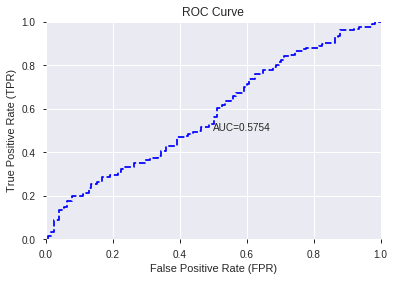

This function is available for GLM models only


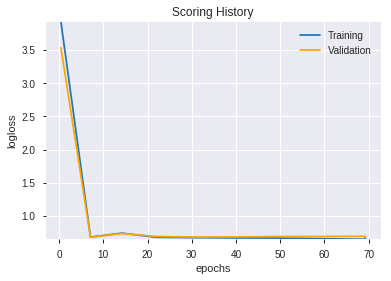

--2019-07-25 00:13:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.163.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  34.5MB/s    in 11s     

2019-07-25 00:14:04 (33.2 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unk

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190724_234518_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190724_234518_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_bd2d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190725_001416  0.524698  0.808659              0.480000  0.541529  0.293254
1  DeepLearning_grid_1_AutoML_20190725_001416_model_2  0.521460  1.745480              0.488000  0.607390  0.368922
2  DeepLearning_grid_1_AutoML_20190725_001416_model_9  0.501587  0.694085              0.483905  0.500465  0.250465
3  DeepLearning_grid_1_AutoML_20190725_001416_model_6  0.485587  0.724048              0.500000  0.514279  0.264483
4  DeepLearning_grid_1_AutoML_20190725_001416_model_5  0.482159  0.701337              0.484000  0.504025  0.254041
5  DeepLearning_grid_1_AutoML_20190725_001416_model_3  0.480254  1.183539              0.488000  0.601342  0.361612
6  DeepLearning_grid_1_AutoML_20190725_001416_model_4  0.478921  1.090359              0.491968  0.595106  0.354151
7  DeepLearning_grid_1_AutoML_20190725_001416_model_8  0.475810  0.694376              0.483873  0.500630  0.250630
8  DeepLearning_grid_1_AutoML_20190725_001416_model_1  0.423238  1.638081              0.487937  0.639598  0.409085
9  DeepLearning_grid_1_AutoML_20190725_001416_model_7  0.405968  0.970235              0.500000  0.586015  0.343414

variable  relative_importance  scaled_importance  percentage
0                 CDLONNECK             1.000000           1.000000    0.032001
1                   ADXR_14             0.949790           0.949790    0.030394
2                       day             0.833545           0.833545    0.026674
3         LINEARREG_SLOPE_8             0.807925           0.807925    0.025854
4                      week             0.806669           0.806669    0.025814
5                 CORREL_30             0.787525           0.787525    0.025201
6        CDLEVENINGDOJISTAR             0.781902           0.781902    0.025021
7         CDLDARKCLOUDCOVER             0.772160           0.772160    0.024710
8              CDLBREAKAWAY             0.747646           0.747646    0.023925
9                   quarter             0.713343           0.713343    0.022827
10                      COS             0.709351           0.709351    0.022700
11              MINUS_DM_24             0.707268           0.707268    0.022633
12            days_in_month             0.702931           0.702931    0.022494
13                      BOP             0.701617           0.701617    0.022452
14                  WILLR_8             0.693606           0.693606    0.022196
15                   Volume             0.691987           0.691987    0.022144
16               PLUS_DM_12             0.683025           0.683025    0.021857
17              AROONOSC_30             0.680679           0.680679    0.021782
18             aroondown_24             0.670482           0.670482    0.021456
19                    month             0.651613           0.651613    0.020852
20                dayofweek             0.651376           0.651376    0.020844
21                CORREL_20             0.640089           0.640089    0.020483
22               aroonup_24             0.635858           0.635858    0.020348
23                    CCI_8             0.626980           0.626980    0.020064
24                   CCI_14             0.621420           0.621420    0.019886
25       LINEARREG_ANGLE_24             0.614293           0.614293    0.019658
26               aroonup_14             0.613550           0.613550    0.019634
27                     COSH             0.607580           0.607580    0.019443
28             aroondown_12             0.599370           0.599370    0.019180
29                    DX_30             0.591260           0.591260    0.018921
30                      DIV             0.590097           0.590097    0.018884
31                      EXP             0.581564           0.581564    0.018610
32              HT_DCPERIOD             0.578367           0.578367    0.018508
33              CDLPIERCING             0.565756           0.565756    0.018105
34                dayofyear             0.564278           0.564278    0.018057
35              AROONOSC_24             0.547636           0.547636    0.017525
36                   ADX_24             0.543292           0.543292    0.017386
37                 WILLR_14             0.540866           0.540866    0.017308
38              AROONOSC_14             0.524601           0.524601    0.016788
39          CDLADVANCEBLOCK             0.521082           0.521082    0.016675
40                   SAREXT             0.490147           0.490147    0.015685
41         CDLSTICKSANDWICH             0.483717           0.483717    0.015479
42                  BETA_14             0.483654           0.483654    0.015477
43          CDLSHOOTINGSTAR             0.464865           0.464865    0.014876
44                  weekday             0.462964           0.462964    0.014815
45                     DX_8             0.455108           0.455108    0.014564
46  BBANDS_upperband_20_0_2             0.424564           0.424564    0.013586
47            CDLHIKKAKEMOD             0.424137           0.424137    0.013573
48             HT_TRENDMODE             0.369329           0.369329    0.011819
49                 

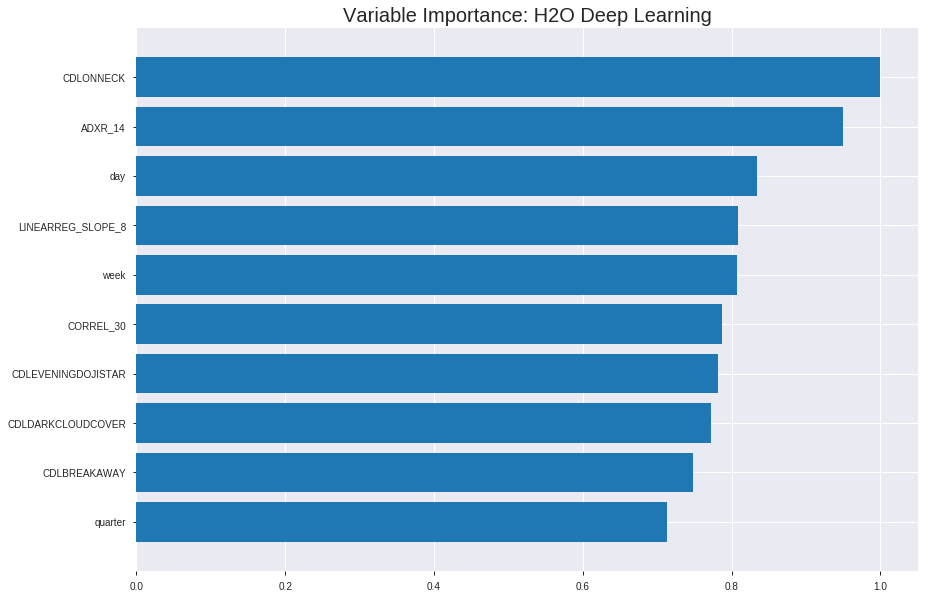

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190725_001416


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2367989752933745
RMSE: 0.4866199495431465
LogLoss: 0.6669543686770222
Mean Per-Class Error: 0.3852279900305202
AUC: 0.6470817145943555
pr_auc: 0.651018784910686
Gini: 0.29416342918871097
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3303078106386102: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      277  572   0.6737   (572.0/849.0)
1      123  782   0.1359   (123.0/905.0)
Total  400  1354  0.3962   (695.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.330308     0.692342  290
max f2                       0.108026     0.842498  393
max f0point5                 0.432298     0.628443  223
max accuracy                 0.432298     0.616876  223
max precision                0.988177     1         0
max recall                   0.0579689    1         398
max specificity              0.988177     1         0
max absolute_mcc             0.430486     0.231702  224
max min_per_class_accuracy   0.461857     0.607735  204
max mean_per_class_accuracy  0.432298     0.614772  223

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 46.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102623                   0.809101           1.83045   1.83045            0.944444         0.841291  0.944444                    0.841291            0.0187845       0.0187845                  83.0448    83.0448
    2        0.0205245                   0.771272           1.50743   1.66894            0.777778         0.788515  0.861111                    0.814903            0.0154696       0.0342541                  50.7428    66.8938
    3        0.0302166                   0.755163           1.71011   1.68214            0.882353         0.763717  0.867925                    0.798485            0.0165746       0.0508287                  71.0107    68.2143
    4        0.0404789                   0.737431           1.39975   1.61055            0.722222         0.745772  0.830986                    0.785121            0.0143646       0.0651934                  39.9754    61.0552
    5        0.050171                    0.721825           1.82411   1.65181            0.941176         0.727544  0.852273                    0.773998            0.0176796       0.0828729                  82.4114    65.1808
    6        0.100342                    0.665836           1.16728   1.40954            0.602273         0.690941  0.727273                    0.732469            0.0585635       0.141436                   16.7278    40.9543
    7        0.149943                    0.630054           1.22525   1.34858            0.632184         0.64982   0.695817                    0.705129            0.0607735       0.20221                    22.5249    34.8579
    8        0.200114                    0.600957           1.12323   1.29208            0.579545         0.615875  0.666667                    0.682752            0.0563536       0.258564                   12.323     29.2081
    9        0.299886                    0.552962           1.21825   1.26752            0.628571         0.57476   0.653992                    0.646823            0.121547        0.38011                    21.8248    26.7517
    10       0.400228                    0.503745           1.16728   1.24239            0.602273         0.527117  0.641026                    0.616811            0.117127        0.497238                   16.7278    24.2386
    11       0.5                         0.461864           1.0632    1.20663            0.548571         0.482065  0.622577                    0.589924            0.106077        0.603315                   6.31981    20.663
    12       0.599772                    0.417994           0.996748  1.17172            0.514286         0.439249  0.604563                    0.564859            0.0994475       0.702762                   -0.325178  17.1716
    13       0.700114                    0.3683             0.991085  1.14583            0.511364         0.394443  0.591205                    0.540434            0.0994475       0.80221                    -0.891512  14.5828
    14       0.799886                    0.319605           0.730949  1.09408            0.377143         0.343408  0.564505                    0.515859            0.0729282       0.875138                   -26.9051   9.40786
    15       0.899658                    0.259056           0.620199  1.04153            0.32             0.290137  0.537389                    0.490826            0.0618785       0.937017                   -37.9801   4.15254
    16       1                           0.0483995          0.627687  1                  0.323864         0.195475  0.515964                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.28156666311187445
RMSE: 0.5306285547460431
LogLoss: 0.7656747768019836
Mean Per-Class Error: 0.48381668572164704
AUC: 0.4811597236759472
pr_auc: 0.541692981583956
Gini: -0.03768055264810555
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11255274358485695: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    221  1        (221.0/221.0)
1      0    281  0        (0.0/281.0)
Total  0    502  0.4402   (221.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.112553     0.717752   399
max f2                       0.112553     0.864084   399
max f0point5                 0.112553     0.613805   399
max accuracy                 0.112553     0.559761   399
max precision                0.922115     1          0
max recall                   0.112553     1          399
max specificity              0.922115     1          0
max absolute_mcc             0.636589     0.0873549  54
max min_per_class_accuracy   0.460422     0.494662   196
max mean_per_class_accuracy  0.500929     0.516183   153

Gains/Lift Table: Avg response rate: 55.98 %, avg score: 46.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.817412           0.595492  0.595492           0.333333         0.851652  0.333333                    0.851652            0.00711744      0.00711744                 -40.4508   -40.4508
    2        0.0219124                   0.801189           1.07189   0.812035           0.6              0.810064  0.454545                    0.832748            0.0106762       0.0177936                  7.18861    -18.7965
    3        0.0318725                   0.76368            1.42918   1.00489            0.8              0.776721  0.5625                      0.81524             0.0142349       0.0320285                  42.9181    0.489324
    4        0.0418327                   0.749574           1.07189   1.02084            0.6              0.757651  0.571429                    0.801528            0.0106762       0.0427046                  7.18861    2.08439
    5        0.0517928                   0.733142           0.357295  0.893238           0.2              0.738128  0.5                         0.789336            0.00355872      0.0462633                  -64.2705   -10.6762
    6        0.101594                    0.646364           0.78605   0.840695           0.44             0.681936  0.470588                    0.736689            0.0391459       0.0854093                  -21.395    -15.9305
    7        0.151394                    0.614672           1.14335   0.940251           0.64             0.628859  0.526316                    0.701218            0.0569395       0.142349                   14.3345    -5.9749
    8        0.201195                    0.587343           1.07189   0.972834           0.6              0.598001  0.544554                    0.67567             0.0533808       0.19573                    7.18861    -2.71661
    9        0.300797                    0.537275           1.03616   0.993802           0.58             0.56332   0.556291                    0.638468            0.103203        0.298932                   3.61566    -0.61983
    10       0.400398                    0.489987           1.03616   1.00434            0.58             0.508156  0.562189                    0.606052            0.103203        0.402135                   3.61566    0.433774
    11       0.5                         0.457035           0.964698  0.996441           0.54             0.473452  0.557769                    0.579638            0.0960854       0.498221                   -3.53025   -0.355872
    12       0.599602                    0.422023           0.857509  0.973363           0.48             0.440308  0.54485                     0.556493            0.0854093       0.58363                    -14.2491   -2.66372
    13       0.699203                    0.381568           1.00043   0.977218           0.56             0.40333   0.547009                    0.534675            0.0996441       0.683274                   0.0427046  -2.27819
    14       0.798805                    0.343794           0.964698  0.975657           0.54             0.362579  0.546135                    0.513217            0.0960854       0.779359                   -3.53025   -2.43431
    15       0.898406                    0.294121           1.03616   0.982364           0.58             0.321626  0.549889                    0.491976            0.103203        0.882562                   3.61566    -1.76358
    16       1                           0.112553           1.15596   1                  0.647059         0.236026  0.559761      


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 00:14:16  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 00:14:16  0.119 sec   36541 obs/sec     1         1             1754       0.538822         0.815276            -0.162501      0.507461        0.524513           0.969061         0.481756                         0.578176           0.919448              -0.356529        0.446072          0.536297             1.19098            0.432271
    2019-07-25 00:14:17  0.426 sec   54135 obs/sec     10        10            17540      0.48662          0.666954            0.0518376      0.647082        0.651019           1.83045          0.396237                         0.530629           0.765675              -0.142589        0.48116           0.541693             0.595492           0.440239

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
CDLONNECK                1.0                    1.0                  0.032000711227965516
ADXR_14                  0.9497900605201721     0.9497900605201721   0.03039395745389792
day                      0.8335450887680054     0.8335450887680054   0.02667403568115382
LINEARREG_SLOPE_8        0.8079252243041992     0.8079252243041992   0.025854181796747946
week                     0.8066685199737549     0.8066685199737549   0.02581396636437046
---                      ---                    ---                  ---
DX_8                     0.4551076591014862     0.4551076591014862   0.014563768776542032
BBANDS_upperband_20_0_2  0.4245637059211731     0.4245637059211731   0.013586340551058333
CDLHIKKAKEMOD            0.42413732409477234    0.42413732409477234  0.01357269602935883
HT_TRENDMODE             0.36932870745658875    0.36932870745658875  0.011818781315516051
AD                       0.3384430408477783     0.3384430408477783   0.010830418017284292


See the whole table with table.as_data_frame()


('accuracy', 0.5338645418326693)

('F1', 0.6774193548387097)

('auc', 0.5246984126984127)

('logloss', 0.808659126739609)

('mean_per_class_error', 0.46631746031746024)

('rmse', 0.5415292409949262)

('mse', 0.2932539188525409)

deeplearning prediction progress: |███████████████████████████████████████| 100%


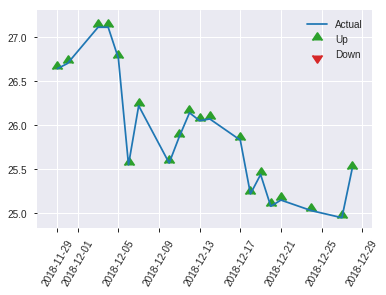


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2932539188525409
RMSE: 0.5415292409949262
LogLoss: 0.808659126739609
Mean Per-Class Error: 0.46631746031746024
AUC: 0.5246984126984127
pr_auc: 0.5132771901181249
Gini: 0.04939682539682533
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.057075462078179526: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    120  0.96     (120.0/125.0)
1      0    126  0        (0.0/126.0)
Total  5    246  0.4781   (120.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0570755    0.677419  245
max f2                       0.0570755    0.84      245
max f0point5                 0.124807     0.56797   236
max accuracy                 0.353077     0.533865  136
max precision                0.960707     1         0
max recall                   0.0570755    1         245
max specificity              0.960707     1         0
max absolute_mcc             0.0570755    0.143136  245
max min_per_class_accuracy   0.369189     0.512     125
max mean_per_class_accuracy  0.353077     0.533683  136

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 40.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.903292           1.32804   1.32804            0.666667         0.931404  0.666667                    0.931404            0.015873        0.015873                   32.8042    32.8042
    2        0.0239044                   0.89109            0.664021  0.996032           0.333333         0.896362  0.5                         0.913883            0.00793651      0.0238095                  -33.5979   -0.396825
    3        0.0318725                   0.863886           0         0.747024           0                0.875306  0.375                       0.904239            0               0.0238095                  -100       -25.2976
    4        0.0438247                   0.837768           0.664021  0.724387           0.333333         0.846364  0.363636                    0.888455            0.00793651      0.031746                   -33.5979   -27.5613
    5        0.0517928                   0.82644            0.996032  0.766178           0.5              0.827733  0.384615                    0.879113            0.00793651      0.0396825                  -0.396825  -23.3822
    6        0.103586                    0.706735           1.22589   0.996032           0.615385         0.776204  0.5                         0.827659            0.0634921       0.103175                   22.5885    -0.396825
    7        0.151394                    0.630783           1.32804   1.10088            0.666667         0.673667  0.552632                    0.77903             0.0634921       0.166667                   32.8042    10.0877
    8        0.203187                    0.559003           1.07265   1.09368            0.538462         0.591816  0.54902                     0.731309            0.0555556       0.222222                   7.26496    9.36819
    9        0.302789                    0.500418           0.95619   1.04845            0.48             0.527858  0.526316                    0.664384            0.0952381       0.31746                    -4.38095   4.84545
    10       0.40239                     0.409916           1.03587   1.04534            0.52             0.444181  0.524752                    0.609878            0.103175        0.420635                   3.5873     4.53402
    11       0.501992                    0.369189           0.95619   1.02765            0.48             0.391803  0.515873                    0.56661             0.0952381       0.515873                   -4.38095   2.76518
    12       0.601594                    0.317144           1.19524   1.0554             0.6              0.345317  0.529801                    0.529972            0.119048        0.634921                   19.5238    5.53979
    13       0.701195                    0.286242           0.796825  1.01867            0.4              0.301365  0.511364                    0.497499            0.0793651       0.714286                   -20.3175   1.86688
    14       0.800797                    0.237719           1.11556   1.03072            0.56             0.261217  0.517413                    0.468111            0.111111        0.825397                   11.5556    3.07194
    15       0.900398                    0.182792           0.796825  1.00485            0.4              0.211003  0.504425                    0.43967             0.0793651       0.904762                   -20.3175   0.484619
    16       1                           3.38448e-05        0.95619   1                  0.48             0.107026  0.501992            

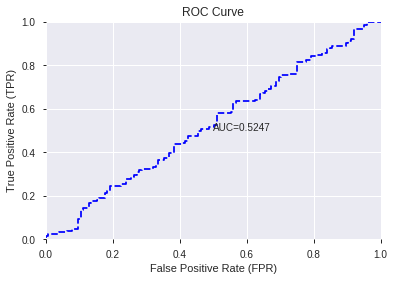

This function is available for GLM models only


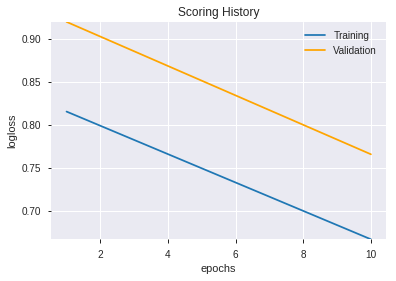

--2019-07-25 00:22:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190725_001416',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190725_001416',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_bd2d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_10_sid_bd2d'

['CDLONNECK',
 'ADXR_14',
 'day',
 'LINEARREG_SLOPE_8',
 'week',
 'CORREL_30',
 'CDLEVENINGDOJISTAR',
 'CDLDARKCLOUDCOVER',
 'CDLBREAKAWAY',
 'quarter',
 'COS',
 'MINUS_DM_24',
 'days_in_month',
 'BOP',
 'WILLR_8',
 'Volume',
 'PLUS_DM_12',
 'AROONOSC_30',
 'aroondown_24',
 'month',
 'dayofweek',
 'CORREL_20',
 'aroonup_24',
 'CCI_8',
 'CCI_14',
 'LINEARREG_ANGLE_24',
 'aroonup_14',
 'COSH',
 'aroondown_12',
 'DX_30',
 'DIV',
 'EXP',
 'HT_DCPERIOD',
 'CDLPIERCING',
 'dayofyear',
 'AROONOSC_24',
 'ADX_24',
 'WILLR_14',
 'AROONOSC_14',
 'CDLADVANCEBLOCK',
 'SAREXT',
 'CDLSTICKSANDWICH',
 'BETA_14',
 'CDLSHOOTINGSTAR',
 'weekday',
 'DX_8',
 'BBANDS_upperband_20_0_2',
 'CDLHIKKAKEMOD',
 'HT_TRENDMODE',
 'AD']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_002304_model_1  0.499937  0.694664                   0.5  0.500751  0.250752

variable  relative_importance  scaled_importance  percentage
0                 dayofweek             0.012466           1.000000    0.055656
1                   weekday             0.012463           0.999735    0.055641
2                 CORREL_20             0.010945           0.877969    0.048864
3                    CCI_14             0.009957           0.798748    0.044455
4               AROONOSC_30             0.008979           0.720264    0.040087
5                     CCI_8             0.008797           0.705673    0.039275
6                       day             0.008143           0.653211    0.036355
7   BBANDS_upperband_20_0_2             0.008051           0.645844    0.035945
8                    ADX_24             0.007820           0.627306    0.034913
9                        AD             0.007659           0.614418    0.034196
10                 WILLR_14             0.007503           0.601871    0.033498
11                  BETA_14             0.006975           0.559545    0.031142
12                      BOP             0.006151           0.493415    0.027461
13                  WILLR_8             0.006032           0.483876    0.026930
14                  ADXR_14             0.005959           0.478002    0.026604
15                      DIV             0.005609           0.449958    0.025043
16                      COS             0.005573           0.447024    0.024880
17             CDLBREAKAWAY             0.005570           0.446805    0.024867
18            CDLHIKKAKEMOD             0.005389           0.432292    0.024060
19       CDLEVENINGDOJISTAR             0.005134           0.411854    0.022922
20                     COSH             0.004791           0.384350    0.021391
21                      EXP             0.004781           0.383496    0.021344
22                     DX_8             0.004422           0.354711    0.019742
23       LINEARREG_ANGLE_24             0.004141           0.332200    0.018489
24               aroonup_14             0.003769           0.302346    0.016827
25                CDLONNECK             0.003593           0.288259    0.016043
26              CDLPIERCING             0.003547           0.284515    0.015835
27            days_in_month             0.003327           0.266850    0.014852
28              AROONOSC_24             0.002651           0.212622    0.011834
29                   Volume             0.002612           0.209528    0.011661
30               aroonup_24             0.002607           0.209139    0.011640
31                    DX_30             0.002511           0.201450    0.011212
32             HT_TRENDMODE             0.002490           0.199780    0.011119
33             aroondown_12             0.002383           0.191158    0.010639
34        CDLDARKCLOUDCOVER             0.002330           0.186874    0.010401
35              AROONOSC_14             0.002312           0.185505    0.010324
36                dayofyear             0.002196           0.176176    0.009805
37                CORREL_30             0.002115           0.169692    0.009444
38             aroondown_24             0.001986           0.159327    0.008867
39        LINEARREG_SLOPE_8             0.001861           0.149250    0.008307
40                    month             0.001551           0.124433    0.006925
41                  quarter             0.001478           0.118551    0.006598
42                     week             0.001352           0.108423    0.006034
43               PLUS_DM_12             0.001119           0.089794    0.004998
44          CDLADVANCEBLOCK             0.001033           0.082895    0.004614
45              HT_DCPERIOD             0.000846           0.067841    0.003776
46              MINUS_DM_24             0.000457           0.036690    0.002042
47         CDLSTICKSANDWICH             0.000251           0.020098    0.001119
48          CDLSHOOTINGSTAR             0.000244           0.019541    0.001088
49                 

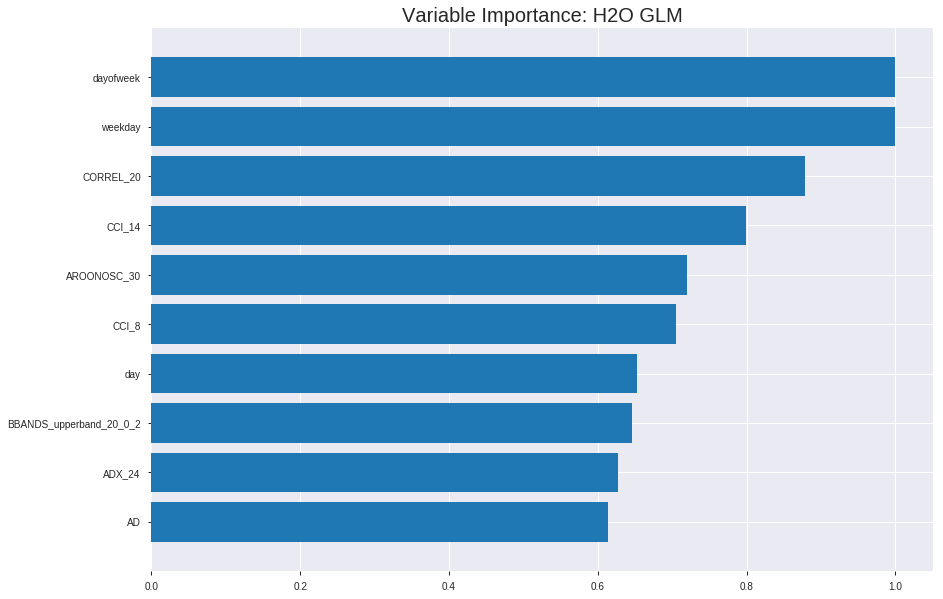

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_002304_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24818613444263635
RMSE: 0.49818283234434757
LogLoss: 0.6895130444951699
Null degrees of freedom: 1753
Residual degrees of freedom: 1703
Null deviance: 2429.7720921923756
Residual deviance: 2418.811760089056
AIC: 2520.811760089056
AUC: 0.5728182001574813
pr_auc: 0.5804037976410703
Gini: 0.1456364003149626
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.479854586427087: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      7    842   0.9918   (842.0/849.0)
1      2    903   0.0022   (2.0/905.0)
Total  9    1745  0.4812   (844.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479855     0.681509  390
max f2                       0.479144     0.842027  393
max f0point5                 0.511843     0.586928  227
max accuracy                 0.511932     0.566135  226
max precision                0.590237     1         0
max recall                   0.468033     1         399
max specificity              0.590237     1         0
max absolute_mcc             0.511843     0.128543  227
max min_per_class_accuracy   0.516549     0.552415  188
max mean_per_class_accuracy  0.511932     0.561774  226

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 51.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.544994           1.39975   1.39975            0.722222         0.552231  0.722222                    0.552231            0.0143646       0.0143646                  39.9754   39.9754
    2        0.0205245                   0.541826           1.50743   1.45359            0.777778         0.543214  0.75                        0.547722            0.0154696       0.0298343                  50.7428   45.3591
    3        0.0302166                   0.539865           1.02606   1.31646            0.529412         0.540722  0.679245                    0.545477            0.00994475      0.039779                   2.60643   31.646
    4        0.0404789                   0.538264           1.18441   1.28298            0.611111         0.53917   0.661972                    0.543878            0.0121547       0.0519337                  18.4408   28.2982
    5        0.050171                    0.53718            0.912057  1.21133            0.470588         0.537539  0.625                       0.542653            0.00883978      0.0607735                  -8.79428  21.1326
    6        0.100342                    0.533143           1.21133   1.21133            0.625            0.535308  0.625                       0.538981            0.0607735       0.121547                   21.1326   21.1326
    7        0.149943                    0.530057           1.15842   1.19382            0.597701         0.531596  0.61597                     0.536538            0.0574586       0.179006                   15.8417   19.3824
    8        0.200114                    0.527615           1.14525   1.18165            0.590909         0.528761  0.609687                    0.534588            0.0574586       0.236464                   14.5254   18.1647
    9        0.299886                    0.523204           1.05212   1.13855            0.542857         0.525425  0.587452                    0.53154             0.104972        0.341436                   5.21231   13.8554
    10       0.400228                    0.519937           1.04615   1.11539            0.539773         0.521586  0.575499                    0.529044            0.104972        0.446409                   4.61452   11.5386
    11       0.5                         0.516604           1.05212   1.10276            0.542857         0.518224  0.568985                    0.526885            0.104972        0.551381                   5.21231   10.2762
    12       0.599772                    0.513376           1.0632    1.09618            0.548571         0.514897  0.565589                    0.524891            0.106077        0.657459                   6.31981   9.61809
    13       0.700114                    0.509077           0.902988  1.06849            0.465909         0.511247  0.551303                    0.522935            0.0906077       0.748066                   -9.70116  6.84921
    14       0.799886                    0.504419           0.897073  1.04711            0.462857         0.506741  0.540271                    0.520915            0.0895028       0.837569                   -10.2927  4.71106
    15       0.899658                    0.497934           0.786324  1.01819            0.405714         0.501611  0.525349                    0.518774            0.078453        0.916022                   -21.3676  1.81893
    16       1                           0.468033           0.836916  1                  0.431818         0.490761  0.515964                    0.515964          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24808188421421226
RMSE: 0.4980781908638565
LogLoss: 0.6893070207477883
Null degrees of freedom: 501
Residual degrees of freedom: 451
Null deviance: 692.5991909148838
Residual deviance: 692.0642488307794
AIC: 794.0642488307794
AUC: 0.522004476578477
pr_auc: 0.5795122976013651
Gini: 0.04400895315695408
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48783184765734516: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    214  0.9683   (214.0/221.0)
1      2    279  0.0071   (2.0/281.0)
Total  9    493  0.4303   (216.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.487832     0.72093    390
max f2                       0.470507     0.864084   399
max f0point5                 0.487832     0.619174   390
max accuracy                 0.487832     0.569721   390
max precision                0.54842      1          0
max recall                   0.470507     1          399
max specificity              0.54842      1          0
max absolute_mcc             0.487832     0.0918704  390
max min_per_class_accuracy   0.515896     0.493213   198
max mean_per_class_accuracy  0.519263     0.532198   154

Gains/Lift Table: Avg response rate: 55.98 %, avg score: 51.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.545413           1.19098   1.19098            0.666667         0.546595  0.666667                    0.546595            0.0142349       0.0142349                  19.0985    19.0985
    2        0.0219124                   0.540656           1.07189   1.13685            0.6              0.54322   0.636364                    0.545061            0.0106762       0.024911                   7.18861    13.6849
    3        0.0318725                   0.538965           1.07189   1.11655            0.6              0.539629  0.625                       0.543363            0.0106762       0.0355872                  7.18861    11.6548
    4        0.0418327                   0.536472           1.78648   1.27605            1                0.537218  0.714286                    0.5419              0.0177936       0.0533808                  78.6477    27.6055
    5        0.0517928                   0.535772           1.07189   1.23679            0.6              0.536149  0.692308                    0.540794            0.0106762       0.0640569                  7.18861    23.6792
    6        0.101594                    0.530805           0.857509  1.05087            0.48             0.533071  0.588235                    0.537008            0.0427046       0.106762                   -14.2491   5.08687
    7        0.151394                    0.527635           1.2148    1.10479            0.68             0.528918  0.618421                    0.534347            0.0604982       0.16726                    21.4804    10.4795
    8        0.201195                    0.525219           0.928968  1.06127            0.52             0.526218  0.594059                    0.532335            0.0462633       0.213523                   -7.1032    6.12734
    9        0.300797                    0.521798           1.07189   1.06479            0.6              0.523342  0.596026                    0.529357            0.106762        0.320285                   7.18861    6.47875
    10       0.400398                    0.518606           1.03616   1.05767            0.58             0.520296  0.59204                     0.527103            0.103203        0.423488                   3.61566    5.76654
    11       0.5                         0.515895           0.75032   0.996441           0.42             0.51714   0.557769                    0.525118            0.0747331       0.498221                   -24.968    -0.355872
    12       0.599602                    0.512221           1.10762   1.01491            0.62             0.514021  0.568106                    0.523275            0.11032         0.608541                   10.7616    1.49088
    13       0.699203                    0.508102           1.03616   1.01794            0.58             0.510298  0.569801                    0.521426            0.103203        0.711744                   3.61566    1.79355
    14       0.798805                    0.503955           1.00043   1.01575            0.56             0.50609   0.568579                    0.519514            0.0996441       0.811388                   0.0427046  1.57524
    15       0.898406                    0.497643           0.928968  1.00613            0.52             0.500697  0.563193                    0.517428            0.0925267       0.903915                   -7.1032    0.61311
    16       1                           0.470507           0.945782  1                  0.529412         0.492062  0.559761                  


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 00:23:05  0.000 sec   2            2.9       51            1.38089           1.37876
    2019-07-25 00:23:05  0.068 sec   4            1.8       51            1.37903           1.37861
    2019-07-25 00:23:05  0.094 sec   6            1.1       51            1.37673           1.37864
    2019-07-25 00:23:05  0.126 sec   8            0.7       51            1.37411           1.37892
    2019-07-25 00:23:05  0.149 sec   10           0.43      51            1.37132           1.37949
    2019-07-25 00:23:05  0.173 sec   12           0.27      51            1.36855           1.38029
    2019-07-25 00:23:05  0.195 sec   14           0.17      51            1.36595           1.38116

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5338645418326693)

('F1', 0.6684350132625995)

('auc', 0.49993650793650796)

('logloss', 0.6946643782820572)

('mean_per_class_error', 0.46758730158730155)

('rmse', 0.5007512368195245)

('mse', 0.2507518011762835)

glm prediction progress: |████████████████████████████████████████████████| 100%


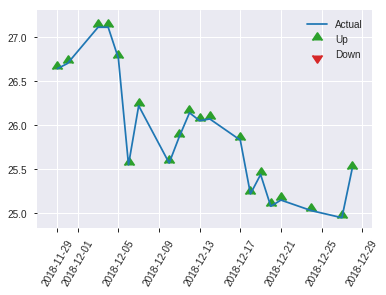


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2507518011762835
RMSE: 0.5007512368195245
LogLoss: 0.6946643782820572
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 348.1519924217104
Residual deviance: 348.72151789759266
AIC: 450.72151789759266
AUC: 0.49993650793650796
pr_auc: 0.49375835643725674
Gini: -0.00012698412698408656
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4754819389246321: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    125  1        (125.0/125.0)
1      0    126  0        (0.0/126.0)
Total  0    251  0.498    (125.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.475482     0.668435  250
max f2                       0.475482     0.834437  250
max f0point5                 0.492597     0.56841   216
max accuracy                 0.492597     0.533865  216
max precision                0.531894     0.566667  29
max recall                   0.475482     1         250
max specificity              0.594986     0.992     0
max absolute_mcc             0.485444     0.111145  238
max min_per_class_accuracy   0.512494     0.492063  120
max mean_per_class_accuracy  0.492597     0.532413  216

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 51.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.556242           0.664021  0.664021           0.333333         0.571999  0.333333                    0.571999            0.00793651      0.00793651                 -33.5979   -33.5979
    2        0.0239044                   0.550814           1.32804   0.996032           0.666667         0.551728  0.5                         0.561863            0.015873        0.0238095                  32.8042    -0.396825
    3        0.0318725                   0.546126           0         0.747024           0                0.547933  0.375                       0.558381            0               0.0238095                  -100       -25.2976
    4        0.0438247                   0.542805           0.664021  0.724387           0.333333         0.544258  0.363636                    0.554529            0.00793651      0.031746                   -33.5979   -27.5613
    5        0.0517928                   0.541042           0.996032  0.766178           0.5              0.542023  0.384615                    0.552605            0.00793651      0.0396825                  -0.396825  -23.3822
    6        0.103586                    0.533483           1.22589   0.996032           0.615385         0.536304  0.5                         0.544454            0.0634921       0.103175                   22.5885    -0.396825
    7        0.151394                    0.528355           0.996032  0.996032           0.5              0.530543  0.5                         0.540061            0.047619        0.150794                   -0.396825  -0.396825
    8        0.203187                    0.52618            0.766178  0.937442           0.384615         0.52708   0.470588                    0.536752            0.0396825       0.190476                   -23.3822   -6.25584
    9        0.302789                    0.520085           0.95619   0.943609           0.48             0.522651  0.473684                    0.532114            0.0952381       0.285714                   -4.38095   -5.6391
    10       0.40239                     0.515686           1.3546    1.04534            0.68             0.517966  0.524752                    0.528612            0.134921        0.420635                   35.4603    4.53402
    11       0.501992                    0.510983           0.717143  0.980222           0.36             0.513531  0.492063                    0.52562             0.0714286       0.492063                   -28.2857   -1.97783
    12       0.601594                    0.506625           1.03587   0.989436           0.52             0.508672  0.496689                    0.522814            0.103175        0.595238                   3.5873     -1.05645
    13       0.701195                    0.50283            1.11556   1.00735            0.56             0.504734  0.505682                    0.520246            0.111111        0.706349                   11.5556    0.735029
    14       0.800797                    0.49733            1.11556   1.02081            0.56             0.500032  0.512438                    0.517732            0.111111        0.81746                    11.5556    2.08087
    15       0.900398                    0.491333           0.876508  1.00485            0.44             0.49373   0.504425                    0.515077            0.0873016       0.904762                   -12.3492   0.484619
    16       1                           0.475482           0.95619   1                  0.48             0.485205  0.501992     

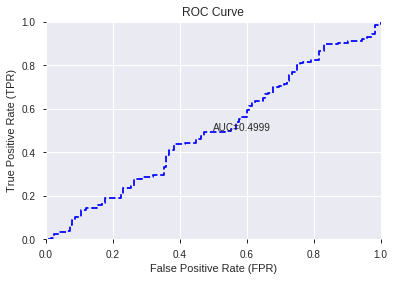

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


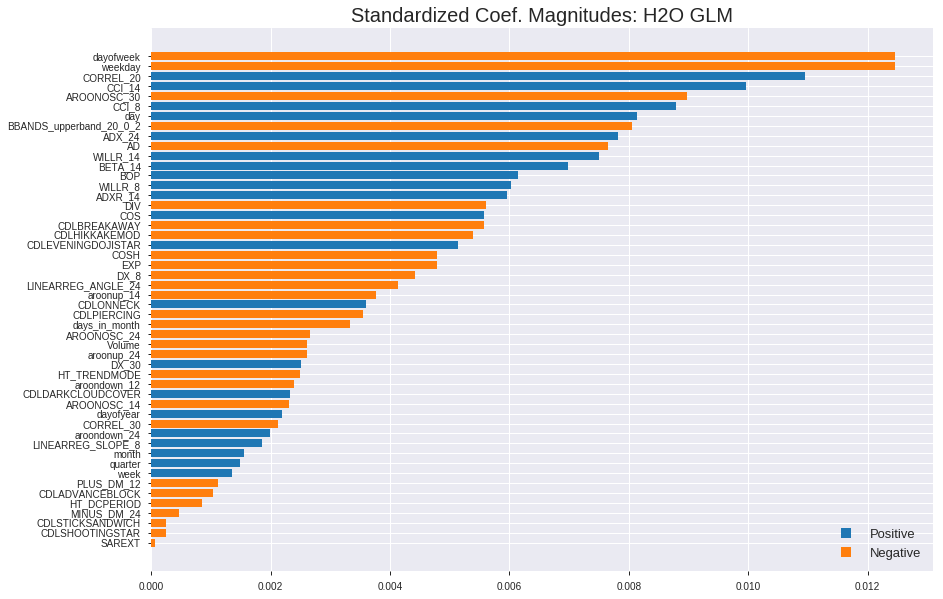

'log_likelihood'
--2019-07-25 00:23:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.10.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.10.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_002304_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_002304_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_bd2d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['dayofweek',
 'weekday',
 'CORREL_20',
 'CCI_14',
 'AROONOSC_30',
 'CCI_8',
 'day',
 'BBANDS_upperband_20_0_2',
 'ADX_24',
 'AD',
 'WILLR_14',
 'BETA_14',
 'BOP',
 'WILLR_8',
 'ADXR_14',
 'DIV',
 'COS',
 'CDLBREAKAWAY',
 'CDLHIKKAKEMOD',
 'CDLEVENINGDOJISTAR',
 'COSH',
 'EXP',
 'DX_8',
 'LINEARREG_ANGLE_24',
 'aroonup_14',
 'CDLONNECK',
 'CDLPIERCING',
 'days_in_month',
 'AROONOSC_24',
 'Volume',
 'aroonup_24',
 'DX_30',
 'HT_TRENDMODE',
 'aroondown_12',
 'CDLDARKCLOUDCOVER',
 'AROONOSC_14',
 'dayofyear',
 'CORREL_30',
 'aroondown_24',
 'LINEARREG_SLOPE_8',
 'month',
 'quarter',
 'week',
 'PLUS_DM_12',
 'CDLADVANCEBLOCK',
 'HT_DCPERIOD',
 'MINUS_DM_24',
 'CDLSTICKSANDWICH',
 'CDLSHOOTINGSTAR',
 'SAREXT']

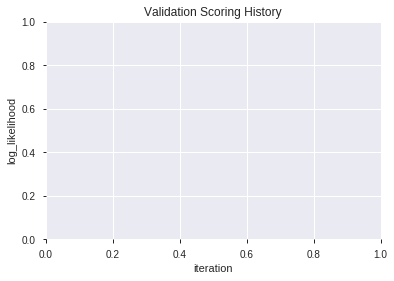

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190725_002319  0.531937  0.709621              0.492000  0.507530  0.257587
1               XGBoost_3_AutoML_20190725_002319  0.529841  0.704975              0.492000  0.505415  0.255444
2  XGBoost_grid_1_AutoML_20190725_002319_model_2  0.513016  0.699433              0.492000  0.503037  0.253046
3  XGBoost_grid_1_AutoML_20190725_002319_model_4  0.508825  0.700551              0.479873  0.503556  0.253569
4  XGBoost_grid_1_AutoML_20190725_002319_model_7  0.488889  0.717145              0.491968  0.511293  0.261420
5  XGBoost_grid_1_AutoML_20190725_002319_model_3  0.488762  0.716339              0.492000  0.510832  0.260950
6  XGBoost_grid_1_AutoML_20190725_002319_model_6  0.484825  0.717298              0.484000  0.511314  0.261442
7               XGBoost_2_AutoML_20190725_002319  0.480000  0.719068              0.500000  0.512189  0.262338
8  XGBoost_grid_1_AutoML_20190725_002319_model_5  0.475492  0.760213              0.492000  0.528669  0.279491
9  XGBoost_grid_1_AutoML_20190725_002319_model_1  0.461968  0.727790              0.491937  0.516174  0.266435

variable  relative_importance  scaled_importance  percentage
0                 CORREL_30           413.433990           1.000000    0.056595
1                   BETA_14           361.853851           0.875240    0.049534
2                       DIV           359.078522           0.868527    0.049154
3               HT_DCPERIOD           332.679199           0.804673    0.045541
4                    Volume           309.127991           0.747708    0.042317
5                       COS           299.147766           0.723568    0.040950
6                     DX_30           285.522308           0.690612    0.039085
7                    ADX_24           270.794281           0.654988    0.037069
8                   ADXR_14           249.011017           0.602299    0.034087
9         LINEARREG_SLOPE_8           244.900101           0.592356    0.033524
10                    CCI_8           244.017670           0.590222    0.033404
11               PLUS_DM_12           243.382751           0.588686    0.033317
12                   SAREXT           232.605057           0.562617    0.031841
13                     DX_8           231.738358           0.560521    0.031723
14                      day           229.899933           0.556074    0.031471
15                      BOP           221.174728           0.534970    0.030277
16                CORREL_20           215.191177           0.520497    0.029458
17              MINUS_DM_24           200.077240           0.483940    0.027389
18                  WILLR_8           187.320312           0.453084    0.025642
19                       AD           178.305817           0.431280    0.024408
20              AROONOSC_30           176.195450           0.426176    0.024119
21                dayofyear           163.820282           0.396243    0.022425
22                 WILLR_14           162.516220           0.393089    0.022247
23                   CCI_14           161.572968           0.390807    0.022118
24                dayofweek           148.096848           0.358212    0.020273
25                     COSH           148.061844           0.358127    0.020268
26       LINEARREG_ANGLE_24           133.144592           0.322046    0.018226
27  BBANDS_upperband_20_0_2           128.363464           0.310481    0.017572
28                     week           112.144814           0.271252    0.015352
29              AROONOSC_14           101.298698           0.245018    0.013867
30             aroondown_24            99.042320           0.239560    0.013558
31               aroonup_24            94.096886           0.227598    0.012881
32               aroonup_14            90.450500           0.218779    0.012382
33             aroondown_12            60.103493           0.145376    0.008228
34              AROONOSC_24            56.040588           0.135549    0.007671
35                  weekday            49.223129           0.119059    0.006738
36                      EXP            43.268234           0.104656    0.005923
37                    month            25.991226           0.062867    0.003558
38            days_in_month            22.116199           0.053494    0.003027
39             HT_TRENDMODE            16.770735           0.040564    0.002296
40                  quarter             3.545389           0.008575    0.000485

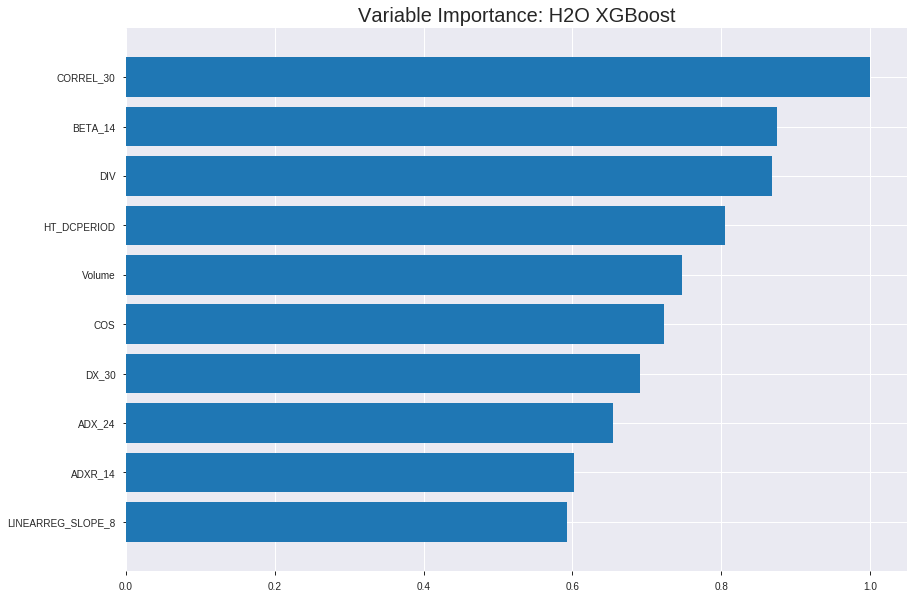

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190725_002319


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15853700923085146
RMSE: 0.39816706196124696
LogLoss: 0.5034553843729889
Mean Per-Class Error: 0.08243692612042763
AUC: 0.9699399358361154
pr_auc: 0.9697292955703777
Gini: 0.9398798716722307
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5015509128570557: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      769  80   0.0942   (80.0/849.0)
1      64   841  0.0707   (64.0/905.0)
Total  833  921  0.0821   (144.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.501551     0.921139  207
max f2                       0.466002     0.944873  235
max f0point5                 0.556974     0.923277  165
max accuracy                 0.502514     0.917902  206
max precision                0.81634      1         0
max recall                   0.350424     1         330
max specificity              0.81634      1         0
max absolute_mcc             0.501551     0.83568   207
max min_per_class_accuracy   0.509231     0.910497  202
max mean_per_class_accuracy  0.502514     0.917563  206

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 51.38 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.769177           1.93812    1.93812            1                0.793367  1                           0.793367            0.0198895       0.0198895                  93.8122   93.8122
    2        0.0205245                   0.74947            1.93812    1.93812            1                0.758358  1                           0.775862            0.0198895       0.039779                   93.8122   93.8122
    3        0.0302166                   0.738538           1.93812    1.93812            1                0.744662  1                           0.765855            0.0187845       0.0585635                  93.8122   93.8122
    4        0.0404789                   0.728863           1.93812    1.93812            1                0.733072  1                           0.757544            0.0198895       0.078453                   93.8122   93.8122
    5        0.050171                    0.722339           1.93812    1.93812            1                0.724792  1                           0.751217            0.0187845       0.0972376                  93.8122   93.8122
    6        0.100342                    0.687992           1.93812    1.93812            1                0.703424  1                           0.72732             0.0972376       0.194475                   93.8122   93.8122
    7        0.149943                    0.668185           1.93812    1.93812            1                0.678812  1                           0.711274            0.0961326       0.290608                   93.8122   93.8122
    8        0.200114                    0.649066           1.9161     1.9326             0.988636         0.658058  0.997151                    0.697932            0.0961326       0.38674                    91.6097   93.26
    9        0.299886                    0.610619           1.88275    1.91601            0.971429         0.63088   0.988593                    0.675624            0.187845        0.574586                   88.2747   91.6014
    10       0.400228                    0.565407           1.7399     1.87186            0.897727         0.587889  0.965812                    0.653628            0.174586        0.749171                   73.9905   87.1861
    11       0.5                         0.513167           1.42867    1.78343            0.737143         0.538204  0.920182                    0.630596            0.142541        0.891713                   42.8672   78.3425
    12       0.599772                    0.462529           0.830624   1.62493            0.428571         0.488337  0.838403                    0.606931            0.0828729       0.974586                   -16.9376  62.4927
    13       0.700114                    0.419779           0.154169   1.41413            0.0795455        0.442496  0.729642                    0.583364            0.0154696       0.990055                   -84.5831  41.4134
    14       0.799886                    0.378802           0.0664499  1.24603            0.0342857        0.399376  0.642908                    0.560414            0.00662983      0.996685                   -93.355   24.6034
    15       0.899658                    0.33577            0.0332249  1.11153            0.0171429        0.357805  0.573511                    0.537945            0.00331492      1                          -96.6775  11.1534
    16       1                           0.21688            0          1                  0                0.297423  0.515964                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26085142264759076
RMSE: 0.5107361575682603
LogLoss: 0.7156047265425268
Mean Per-Class Error: 0.48380863432150856
AUC: 0.4736477673467416
pr_auc: 0.5538773127886688
Gini: -0.052704465306516846
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27686524391174316: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    220  0.9955   (220.0/221.0)
1      0    281  0        (0.0/281.0)
Total  1    501  0.4382   (220.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.276865     0.71867    398
max f2                       0.276865     0.864615   398
max f0point5                 0.276865     0.61488    398
max accuracy                 0.276865     0.561753   398
max precision                0.720644     0.857143   6
max recall                   0.276865     1          398
max specificity              0.758397     0.995475   0
max absolute_mcc             0.54954      0.0918279  163
max min_per_class_accuracy   0.516644     0.484163   207
max mean_per_class_accuracy  0.681519     0.516191   20

Gains/Lift Table: Avg response rate: 55.98 %, avg score: 52.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.724473           1.48873   1.48873            0.833333         0.744981  0.833333                    0.744981            0.0177936       0.0177936                  48.8731    48.8731
    2        0.0219124                   0.702167           0.714591  1.13685            0.4              0.707503  0.636364                    0.727946            0.00711744      0.024911                   -28.5409   13.6849
    3        0.0318725                   0.690053           1.78648   1.33986            1                0.695439  0.75                        0.717787            0.0177936       0.0427046                  78.6477    33.9858
    4        0.0418327                   0.684653           1.07189   1.27605            0.6              0.686963  0.714286                    0.710448            0.0106762       0.0533808                  7.18861    27.6055
    5        0.0517928                   0.681144           1.07189   1.23679            0.6              0.681597  0.692308                    0.7049              0.0106762       0.0640569                  7.18861    23.6792
    6        0.101594                    0.648473           0.857509  1.05087            0.48             0.664422  0.588235                    0.685058            0.0427046       0.106762                   -14.2491   5.08687
    7        0.151394                    0.623399           0.78605   0.963757           0.44             0.635018  0.539474                    0.668598            0.0391459       0.145907                   -21.395    -3.62427
    8        0.201195                    0.608256           0.643132  0.884394           0.36             0.616174  0.49505                     0.655622            0.0320285       0.177936                   -35.6868   -11.5606
    9        0.300797                    0.575913           1.03616   0.934647           0.58             0.59345   0.523179                    0.635035            0.103203        0.281139                   3.61566    -6.53532
    10       0.400398                    0.545601           0.821779  0.90657            0.46             0.561927  0.507463                    0.616849            0.0818505       0.362989                   -17.8221   -9.34296
    11       0.5                         0.516348           1.25053   0.975089           0.7              0.532     0.545817                    0.599947            0.124555        0.487544                   25.0534    -2.4911
    12       0.599602                    0.491745           1.07189   0.991168           0.6              0.504338  0.554817                    0.584065            0.106762        0.594306                   7.18861    -0.883177
    13       0.699203                    0.464578           0.928968  0.982308           0.52             0.478672  0.549858                    0.569052            0.0925267       0.686833                   -7.1032    -1.76922
    14       0.798805                    0.437978           1.00043   0.984567           0.56             0.453256  0.551122                    0.554613            0.0996441       0.786477                   0.0427046  -1.54329
    15       0.898406                    0.397144           1.10762   0.998209           0.62             0.415646  0.558758                    0.539207            0.11032         0.896797                   10.7616    -0.17912
    16       1                           0.27441            1.01584   1                  0.568627         0.360303  0.559761           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 00:23:28  8.195 sec   0                  0.5              0.693147            0.5             0                  1                0.484036                         0.5                0.693147              0.5               0                    1                  0.440239
    2019-07-25 00:23:28  8.398 sec   5                  0.486198         0.66586             0.797404        0.804064           1.93812          0.295325                         0.498138           0.689422              0.547616          0.61635              1.48873            0.440239
    2019-07-25 00:23:28  8.490 sec   10                 0.472934         0.640181            0.863454        0.869072           1.93812          0.207526                         0.498253           0.689659              0.541924          0.591447             1.19098            0.440239
    2019-07-25 00:23:28  8.571 sec   15                 0.46202          0.619364            0.889935        0.898203           1.93812          0.202965                         0.49924            0.69164               0.530628          0.584434             1.48873            0.440239
    2019-07-25 00:23:28  8.673 sec   20                 0.450996         0.598663            0.911754        0.918838           1.93812          0.167617                         0.500296           0.6938                0.517158          0.565484             1.19098            0.440239
    2019-07-25 00:23:29  8.776 sec   25                 0.441533         0.581078            0.923978        0.929946           1.93812          0.152223                         0.503484           0.700319              0.495934          0.553024             1.19098            0.440239
    2019-07-25 00:23:29  8.889 sec   30                 0.431855         0.563314            0.934804        0.93703            1.93812          0.144242                         0.503089           0.699552              0.506063          0.56034              0.595492           0.440239
    2019-07-25 00:23:29  9.009 sec   35                 0.422639         0.546725            0.948878        0.950248           1.93812          0.119726                         0.504945           0.703345              0.491659          0.55903              1.19098            0.440239
    2019-07-25 00:23:29  9.122 sec   40                 0.413746         0.530887            0.958449        0.959252           1.93812          0.108894                         0.507232           0.70823               0.481876          0.547451             0.893238           0.440239
    2019-07-25 00:23:29  9.214 sec   45                 0.40578          0.516799            0.965806        0.966275           1.93812          0.0929304                        0.508823           0.711473              0.477923          0.55554              1.48873            0.438247
    2019-07-25 00:23:29  9.305 sec   50                 0.398167         0.503455            0.96994         0.969729           1.93812          0.0820981                        0.510736           0.715605              0.473648          0.553877             1.48873            0.438247

Variable Importances: 


variable       relative_importance    scaled_importance     percentage
-------------  ---------------------  --------------------  ----------------------
CORREL_30      413.4339904785156      1.0                   0.056595053023892145
BETA_14        361.8538513183594      0.8752397230318278    0.049534238533602976
DIV            359.0785217285156      0.8685268507142143    0.049154323168845014
HT_DCPERIOD    332.67919921875        0.804673072075427     0.04554051518100698
Volume         309.12799072265625     0.7477082142299577    0.04231658603074416
---            ---                    ---                   ---
EXP            43.26823425292969      0.10465572557991734   0.005922996338449327
month          25.991226196289062     0.06286668922941331   0.0035579436103751953
days_in_month  22.116199493408203     0.053493907135720824  0.0030274905108012827
HT_TRENDMODE   16.770734786987305     0.04056447987640437   0.0022957488894917114
quarter        3.545389175415039      0.008575466113251948  0.00048532895938408426


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5816733067729084)

('F1', 0.6719999999999999)

('auc', 0.5319365079365079)

('logloss', 0.7096207736301003)

('mean_per_class_error', 0.41920634920634914)

('rmse', 0.507530387974401)

('mse', 0.257587094717446)

xgboost prediction progress: |████████████████████████████████████████████| 100%


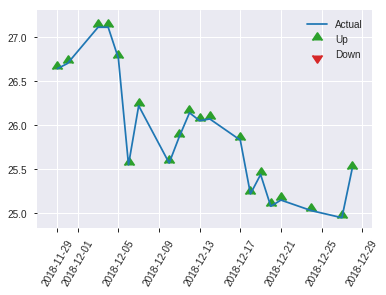


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.257587094717446
RMSE: 0.507530387974401
LogLoss: 0.7096207736301003
Mean Per-Class Error: 0.41920634920634914
AUC: 0.5319365079365079
pr_auc: 0.5133624175470498
Gini: 0.06387301587301586
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2844618558883667: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    123  0.984    (123.0/125.0)
1      0    126  0        (0.0/126.0)
Total  2    249  0.49     (123.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.284462     0.672     248
max f2                       0.284462     0.836653  248
max f0point5                 0.437968     0.594118  180
max accuracy                 0.437968     0.581673  180
max precision                0.820952     1         0
max recall                   0.284462     1         248
max specificity              0.820952     1         0
max absolute_mcc             0.437968     0.18016   180
max min_per_class_accuracy   0.496742     0.531746  124
max mean_per_class_accuracy  0.437968     0.580794  180

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 50.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.744301           1.32804   1.32804            0.666667         0.770412  0.666667                    0.770412            0.015873        0.015873                   32.8042    32.8042
    2        0.0239044                   0.731799           1.32804   1.32804            0.666667         0.735789  0.666667                    0.753101            0.015873        0.031746                   32.8042    32.8042
    3        0.0318725                   0.723778           0         0.996032           0                0.729337  0.5                         0.74716             0               0.031746                   -100       -0.396825
    4        0.0438247                   0.710714           1.32804   1.08658            0.666667         0.715498  0.545455                    0.738525            0.015873        0.047619                   32.8042    8.65801
    5        0.0517928                   0.703155           0.996032  1.07265            0.5              0.706233  0.538462                    0.733557            0.00793651      0.0555556                  -0.396825  7.26496
    6        0.103586                    0.663902           0.612943  0.842796           0.307692         0.685817  0.423077                    0.709687            0.031746        0.0873016                  -38.7057   -15.7204
    7        0.151394                    0.636069           1.16204   0.943609           0.583333         0.647535  0.473684                    0.69006             0.0555556       0.142857                   16.2037    -5.6391
    8        0.203187                    0.617373           0.919414  0.937442           0.461538         0.626849  0.470588                    0.673947            0.047619        0.190476                   -8.05861   -6.25584
    9        0.302789                    0.553503           1.11556   0.996032           0.56             0.584333  0.5                         0.644469            0.111111        0.301587                   11.5556    -0.396825
    10       0.40239                     0.51915            0.95619   0.98617            0.48             0.532603  0.49505                     0.616779            0.0952381       0.396825                   -4.38095   -1.383
    11       0.501992                    0.495498           1.3546    1.05927            0.68             0.507495  0.531746                    0.595096            0.134921        0.531746                   35.4603    5.92719
    12       0.601594                    0.469249           1.03587   1.0554             0.52             0.481342  0.529801                    0.576262            0.103175        0.634921                   3.5873     5.53979
    13       0.701195                    0.442602           1.27492   1.08658            0.64             0.455611  0.545455                    0.559124            0.126984        0.761905                   27.4921    8.65801
    14       0.800797                    0.417754           0.717143  1.04063            0.36             0.430918  0.522388                    0.543178            0.0714286       0.833333                   -28.2857   4.06302
    15       0.900398                    0.37316            0.796825  1.01366            0.4              0.392749  0.50885                     0.526538            0.0793651       0.912698                   -20.3175   1.36606
    16       1                           0.23523            0.876508  1                  0.44             0.335621  0.501992               

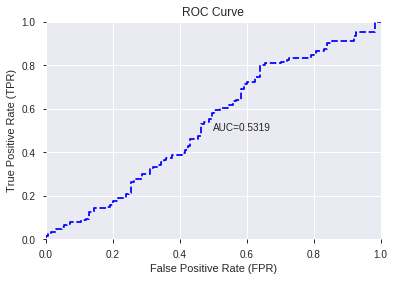

This function is available for GLM models only


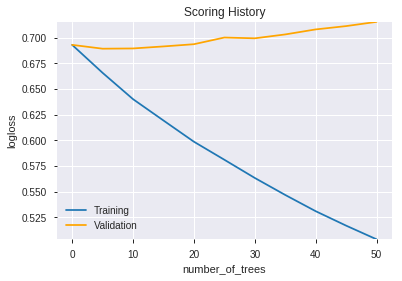

--2019-07-25 00:23:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.169.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.169.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190725_002319',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190725_002319',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_bd2d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_26_sid_bd2d',
   'type

['CORREL_30',
 'BETA_14',
 'DIV',
 'HT_DCPERIOD',
 'Volume',
 'COS',
 'DX_30',
 'ADX_24',
 'ADXR_14',
 'LINEARREG_SLOPE_8',
 'CCI_8',
 'PLUS_DM_12',
 'SAREXT',
 'DX_8',
 'day',
 'BOP',
 'CORREL_20',
 'MINUS_DM_24',
 'WILLR_8',
 'AD',
 'AROONOSC_30',
 'dayofyear',
 'WILLR_14',
 'CCI_14',
 'dayofweek',
 'COSH',
 'LINEARREG_ANGLE_24',
 'BBANDS_upperband_20_0_2',
 'week',
 'AROONOSC_14',
 'aroondown_24',
 'aroonup_24',
 'aroonup_14',
 'aroondown_12',
 'AROONOSC_24',
 'weekday',
 'EXP',
 'month',
 'days_in_month',
 'HT_TRENDMODE',
 'quarter']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_002353_model_1  0.534159  0.691169                 0.484  0.499012  0.249013

variable  relative_importance  scaled_importance    percentage
0                 CDL3OUTSIDE         8.819562e-03           1.000000  1.254561e-02
1                   dayofweek         7.856618e-03           0.890817  1.117585e-02
2                     weekday         7.841413e-03           0.889093  1.115422e-02
3              CDLHARAMICROSS         7.374836e-03           0.836191  1.049053e-02
4               CDLHANGINGMAN         7.086347e-03           0.803481  1.008016e-02
...                       ...                  ...                ...           ...
1035   BBANDS_upperband_8_0_2         1.186261e-06           0.000135  1.687428e-06
1036  BBANDS_lowerband_12_7_4         7.221892e-07           0.000082  1.027297e-06
1037                     High         5.532559e-07           0.000063  7.869932e-07
1038  BBANDS_lowerband_24_0_3         4.180975e-07           0.000047  5.947337e-07
1039                   KAMA_8         9.997071e-08           0.000011  1.422059e-07

[1040 rows x 4 columns]

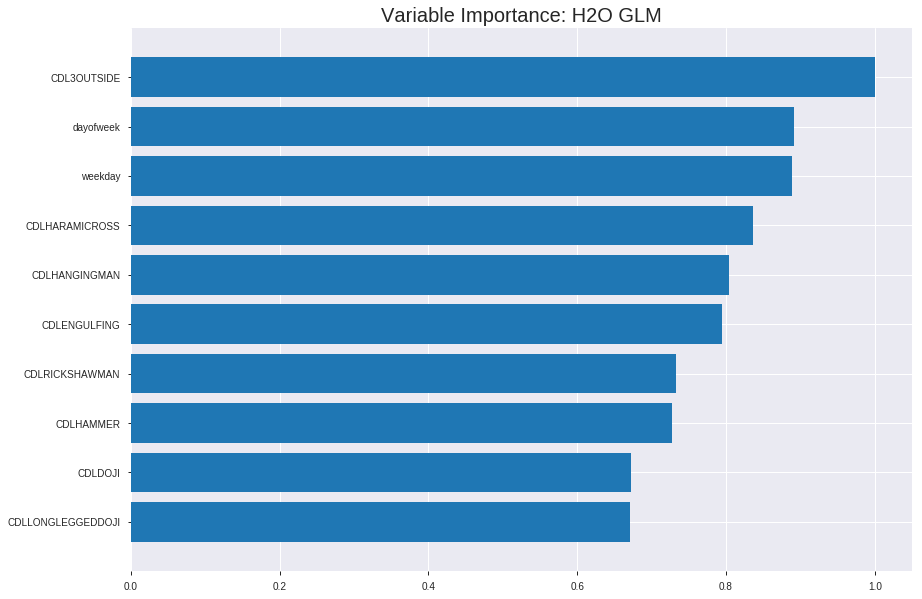

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_002353_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24621368968196664
RMSE: 0.4961992439353033
LogLoss: 0.6855465583602182
Null degrees of freedom: 1753
Residual degrees of freedom: 713
Null deviance: 2429.7720921923756
Residual deviance: 2404.897326727645
AIC: 4486.897326727645
AUC: 0.5862483649922886
pr_auc: 0.5925617139794954
Gini: 0.1724967299845772
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4385128367220911: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      3    846   0.9965   (846.0/849.0)
1      0    905   0        (0.0/905.0)
Total  3    1751  0.4823   (846.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.438513     0.681476  397
max f2                       0.438513     0.842487  397
max f0point5                 0.494327     0.59184   284
max accuracy                 0.509163     0.570125  231
max precision                0.619811     1         0
max recall                   0.438513     1         397
max specificity              0.619811     1         0
max absolute_mcc             0.500897     0.137936  260
max min_per_class_accuracy   0.517184     0.559116  202
max mean_per_class_accuracy  0.509163     0.567209  231

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 51.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.583961           1.39975   1.39975            0.722222         0.595236  0.722222                    0.595236            0.0143646       0.0143646                  39.9754   39.9754
    2        0.0205245                   0.575294           1.29208   1.34592            0.666667         0.578654  0.694444                    0.586945            0.0132597       0.0276243                  29.2081   34.5918
    3        0.0302166                   0.570531           1.25408   1.31646            0.647059         0.57235   0.679245                    0.582264            0.0121547       0.039779                   25.4079   31.646
    4        0.0404789                   0.56582            1.39975   1.33758            0.722222         0.568162  0.690141                    0.578689            0.0143646       0.0541436                  39.9754   33.7577
    5        0.050171                    0.561236           1.48209   1.36549            0.764706         0.563427  0.704545                    0.57574             0.0143646       0.0685083                  48.2093   36.5495
    6        0.100342                    0.551443           1.1893    1.2774             0.613636         0.555959  0.659091                    0.56585             0.0596685       0.128177                   18.9302   27.7398
    7        0.149943                    0.545503           1.18069   1.24541            0.609195         0.548253  0.642586                    0.560029            0.0585635       0.18674                    18.0695   24.5409
    8        0.200114                    0.540672           1.12323   1.21478            0.579545         0.543115  0.626781                    0.555788            0.0563536       0.243094                   12.323    21.4777
    9        0.299886                    0.53213            1.0632    1.16435            0.548571         0.536281  0.60076                     0.549298            0.106077        0.349171                   6.31981   16.4347
    10       0.400228                    0.524929           1.02412   1.12919            0.528409         0.52863   0.582621                    0.544117            0.102762        0.451934                   2.4121    12.919
    11       0.5                         0.517134           1.07427   1.11823            0.554286         0.52113   0.576967                    0.53953             0.107182        0.559116                   7.42731   11.8232
    12       0.599772                    0.508265           1.05212   1.10723            0.542857         0.512571  0.571293                    0.535045            0.104972        0.664088                   5.21231   10.7235
    13       0.700114                    0.498987           0.914001  1.07954            0.471591         0.503514  0.557003                    0.530526            0.0917127       0.755801                   -8.59995  7.954
    14       0.799886                    0.489636           0.885998  1.0554             0.457143         0.494378  0.544547                    0.526017            0.0883978       0.844199                   -11.4002  5.5399
    15       0.899658                    0.479894           0.786324  1.02556            0.405714         0.48474   0.529151                    0.52144             0.078453        0.922652                   -21.3676  2.55586
    16       1                           0.420423           0.770844  1                  0.397727         0.466865  0.515964                    0.515964            0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24751307876267042
RMSE: 0.49750686303072283
LogLoss: 0.6881577629348479
Null degrees of freedom: 501
Residual degrees of freedom: -539
Null deviance: 692.5991909148838
Residual deviance: 690.9103939865872
AIC: 2772.910393986587
AUC: 0.5335260301766477
pr_auc: 0.5834325725174789
Gini: 0.06705206035329536
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4691863446566106: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    214  0.9683   (214.0/221.0)
1      3    278  0.0107   (3.0/281.0)
Total  10   492  0.4323   (217.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.469186     0.719276   390
max f2                       0.451027     0.864084   399
max f0point5                 0.485938     0.619875   351
max accuracy                 0.487745     0.571713   345
max precision                0.617851     1          0
max recall                   0.451027     1          399
max specificity              0.617851     1          0
max absolute_mcc             0.531977     0.0899135  108
max min_per_class_accuracy   0.515632     0.520362   201
max mean_per_class_accuracy  0.531977     0.539573   108

Gains/Lift Table: Avg response rate: 55.98 %, avg score: 51.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.579426           1.19098   1.19098            0.666667         0.591232  0.666667                    0.591232            0.0142349       0.0142349                  19.0985    19.0985
    2        0.0219124                   0.571448           0.357295  0.812035           0.2              0.575486  0.454545                    0.584074            0.00355872      0.0177936                  -64.2705   -18.7965
    3        0.0318725                   0.562075           1.07189   0.893238           0.6              0.567722  0.5                         0.578964            0.0106762       0.0284698                  7.18861    -10.6762
    4        0.0418327                   0.559402           1.42918   1.02084            0.8              0.560421  0.571429                    0.574549            0.0142349       0.0427046                  42.9181    2.08439
    5        0.0517928                   0.556882           1.78648   1.16808            1                0.557373  0.653846                    0.571246            0.0177936       0.0604982                  78.6477    16.8081
    6        0.101594                    0.547321           0.857509  1.01584            0.48             0.550962  0.568627                    0.561303            0.0427046       0.103203                   -14.2491   1.58398
    7        0.151394                    0.539807           0.928968  0.987264           0.52             0.543011  0.552632                    0.555286            0.0462633       0.149466                   -7.1032    -1.27365
    8        0.201195                    0.53656            1.35772   1.07896            0.76             0.53809   0.60396                     0.551029            0.0676157       0.217082                   35.7722    7.89613
    9        0.300797                    0.52775            1.00043   1.05296            0.56             0.532368  0.589404                    0.54485             0.0996441       0.316726                   0.0427046  5.29566
    10       0.400398                    0.521357           0.928968  1.02211            0.52             0.524622  0.572139                    0.539818            0.0925267       0.409253                   -7.1032    2.21136
    11       0.5                         0.515795           1.07189   1.03203            0.6              0.518254  0.577689                    0.535523            0.106762        0.516014                   7.18861    3.20285
    12       0.599602                    0.507724           1.03616   1.03271            0.58             0.511418  0.578073                    0.531519            0.103203        0.619217                   3.61566    3.27142
    13       0.699203                    0.500866           1.00043   1.02811            0.56             0.504092  0.575499                    0.527612            0.0996441       0.718861                   0.0427046  2.81149
    14       0.798805                    0.493554           0.964698  1.02021            0.54             0.49762   0.571072                    0.523872            0.0960854       0.814947                   -3.53025   2.02075
    15       0.898406                    0.483476           1.00043   1.01801            0.56             0.489744  0.569845                    0.520089            0.0996441       0.914591                   0.0427046  1.80145
    16       1                           0.451027           0.840695  1                  0.470588         0.474099  0.559761                 


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 00:23:57  0.000 sec   2            3.2       1041          1.37109           1.37632
    2019-07-25 00:23:59  1.972 sec   4            2.3       1041          1.36802           1.37693
    2019-07-25 00:24:01  3.906 sec   6            1.7       1041          1.36441           1.37782
    2019-07-25 00:24:03  5.910 sec   8            1.2       1041          1.36023           1.37909
    2019-07-25 00:24:05  7.872 sec   10           0.89      1041          1.35553           1.38082
    2019-07-25 00:24:07  9.856 sec   12           0.65      1041          1.35036           1.38314

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5617529880478087)

('F1', 0.675603217158177)

('auc', 0.5341587301587302)

('logloss', 0.6911689628142269)

('mean_per_class_error', 0.4378412698412698)

('rmse', 0.49901155448825624)

('mse', 0.2490125315127859)

glm prediction progress: |████████████████████████████████████████████████| 100%


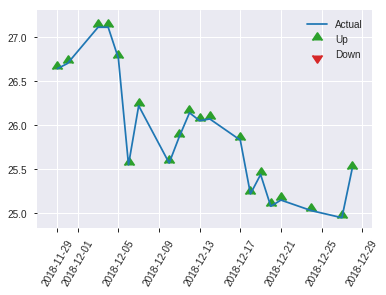


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2490125315127859
RMSE: 0.49901155448825624
LogLoss: 0.6911689628142269
Null degrees of freedom: 250
Residual degrees of freedom: -790
Null deviance: 348.1519924217104
Residual deviance: 346.966819332742
AIC: 2428.966819332742
AUC: 0.5341587301587302
pr_auc: 0.5404631330801228
Gini: 0.06831746031746033
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4293701108287725: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    121  0.968    (121.0/125.0)
1      0    126  0        (0.0/126.0)
Total  4    247  0.4821   (121.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.42937      0.675603  246
max f2                       0.42937      0.838881  246
max f0point5                 0.42937      0.56553   246
max accuracy                 0.497952     0.561753  99
max precision                0.565476     1         0
max recall                   0.42937      1         246
max specificity              0.565476     1         0
max absolute_mcc             0.42937      0.127765  246
max min_per_class_accuracy   0.490681     0.515873  124
max mean_per_class_accuracy  0.497952     0.562159  99

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 48.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.555761           1.32804   1.32804            0.666667         0.56057   0.666667                    0.56057             0.015873        0.015873                   32.8042   32.8042
    2        0.0239044                   0.549071           0.664021  0.996032           0.333333         0.551046  0.5                         0.555808            0.00793651      0.0238095                  -33.5979  -0.396825
    3        0.0318725                   0.544101           0         0.747024           0                0.546498  0.375                       0.55348             0               0.0238095                  -100      -25.2976
    4        0.0438247                   0.541889           1.32804   0.905483           0.666667         0.542575  0.454545                    0.550506            0.015873        0.0396825                  32.8042   -9.45166
    5        0.0517928                   0.539496           1.99206   1.07265            1                0.5414    0.538462                    0.549105            0.015873        0.0555556                  99.2063   7.26496
    6        0.103586                    0.528089           1.37912   1.22589            0.692308         0.533545  0.615385                    0.541325            0.0714286       0.126984                   37.9121   22.5885
    7        0.151394                    0.51953            1.32804   1.25815            0.666667         0.52251   0.631579                    0.535383            0.0634921       0.190476                   32.8042   25.8145
    8        0.203187                    0.515364           1.07265   1.21086            0.538462         0.517169  0.607843                    0.53074             0.0555556       0.246032                   7.26496   21.0862
    9        0.302789                    0.506452           0.95619   1.12709            0.48             0.510974  0.565789                    0.524238            0.0952381       0.34127                    -4.38095  12.7089
    10       0.40239                     0.497927           1.19524   1.14396            0.6              0.501284  0.574257                    0.518557            0.119048        0.460317                   19.5238   14.3957
    11       0.501992                    0.490658           0.557778  1.02765            0.28             0.493673  0.515873                    0.513619            0.0555556       0.515873                   -44.2222  2.76518
    12       0.601594                    0.47967            0.95619   1.01582            0.48             0.483781  0.509934                    0.508679            0.0952381       0.611111                   -4.38095  1.58205
    13       0.701195                    0.470588           1.03587   1.01867            0.52             0.475361  0.511364                    0.503947            0.103175        0.714286                   3.5873    1.86688
    14       0.800797                    0.463928           0.63746   0.971255           0.32             0.466813  0.487562                    0.499328            0.0634921       0.777778                   -36.254   -2.87452
    15       0.900398                    0.452805           1.27492   1.00485            0.64             0.458688  0.504425                    0.494833            0.126984        0.904762                   27.4921   0.484619
    16       1                           0.421351           0.95619   1                  0.48             0.442149  0.501992                    0.489585   

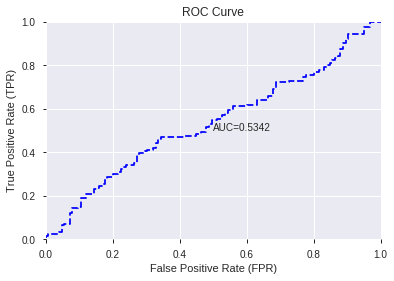

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


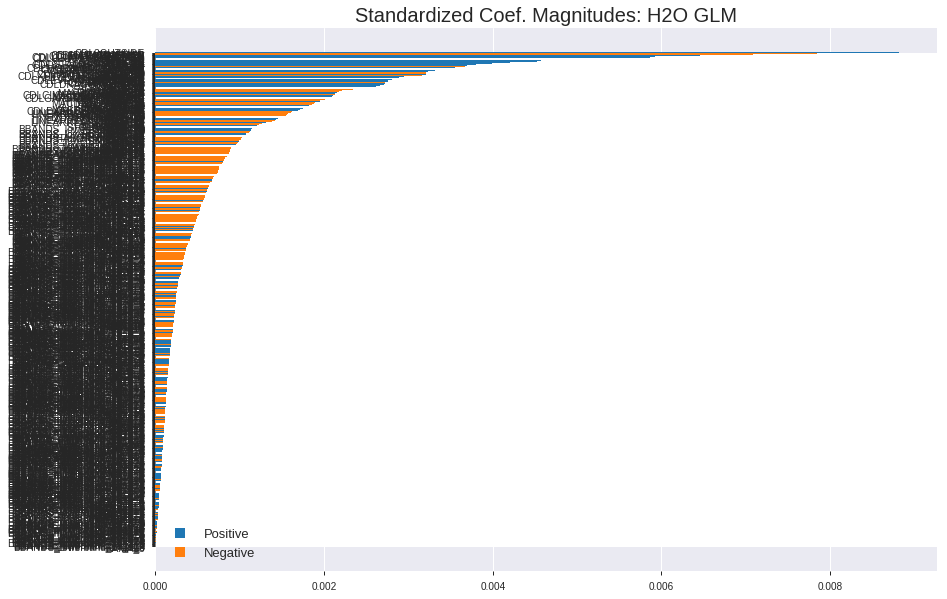

'log_likelihood'
--2019-07-25 00:24:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.252
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.252|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_002353_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_002353_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_bd2d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

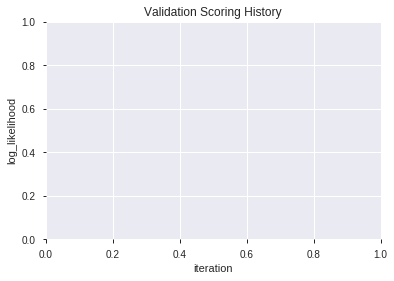

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_002440_model_4  0.529143  0.695288              0.447683  0.501000  0.251001
1  XGBoost_grid_1_AutoML_20190725_002440_model_7  0.514349  0.720153              0.488000  0.511983  0.262127
2  XGBoost_grid_1_AutoML_20190725_002440_model_6  0.505079  0.714219              0.492000  0.509692  0.259785
3  XGBoost_grid_1_AutoML_20190725_002440_model_3  0.496000  0.724110              0.496000  0.513790  0.263980
4  XGBoost_grid_1_AutoML_20190725_002440_model_5  0.461651  0.792255              0.500000  0.540122  0.291732
5               XGBoost_1_AutoML_20190725_002440  0.461206  0.737173              0.471937  0.520428  0.270845
6               XGBoost_3_AutoML_20190725_002440  0.461143  0.734535              0.496000  0.518738  0.269090
7  XGBoost_grid_1_AutoML_20190725_002440_model_1  0.457333  0.732072              0.496000  0.517531  0.267839
8  XGBoost_grid_1_AutoML_20190725_002440_model_2  0.452952  0.714367              0.500000  0.510324  0.260431
9               XGBoost_2_AutoML_20190725_002440  0.451556  0.720016              0.471937  0.513029  0.263199

variable  relative_importance  scaled_importance  percentage
0                MINUS_DI_30           115.782219           1.000000    0.032677
1                        DIV            70.743568           0.611005    0.019966
2                     ADX_24            67.627892           0.584096    0.019087
3                     ROC_24            65.392548           0.564789    0.018456
4                  dayofweek            62.880432           0.543092    0.017747
..                       ...                  ...                ...         ...
178               PLUS_DI_14             5.921960           0.051147    0.001671
179   BBANDS_lowerband_8_3_5             5.594167           0.048316    0.001579
180   LINEARREG_INTERCEPT_14             5.465542           0.047205    0.001543
181        MACDFIX_signal_14             5.060157           0.043704    0.001428
182  BBANDS_lowerband_14_6_2             4.329650           0.037395    0.001222

[183 rows x 4 columns]

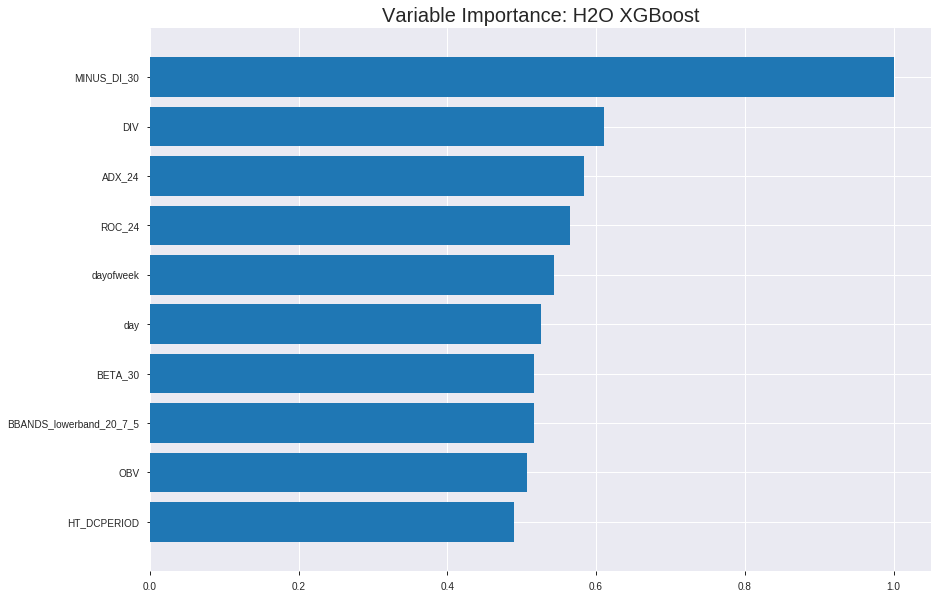

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_002440_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21005471925644834
RMSE: 0.45831726921036736
LogLoss: 0.6116675004598908
Mean Per-Class Error: 0.23085723210276632
AUC: 0.8359148559566341
pr_auc: 0.8389676591673788
Gini: 0.6718297119132681
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4760689934094747: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      505  344   0.4052   (344.0/849.0)
1      105  800   0.116    (105.0/905.0)
Total  610  1144  0.256    (449.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476069     0.780869  258
max f2                       0.42867      0.861258  322
max f0point5                 0.510357     0.776116  212
max accuracy                 0.50533      0.769669  219
max precision                0.769241     1         0
max recall                   0.341704     1         389
max specificity              0.769241     1         0
max absolute_mcc             0.50533      0.53869   219
max min_per_class_accuracy   0.507826     0.764429  215
max mean_per_class_accuracy  0.50533      0.769143  219

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 51.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.701418           1.83045   1.83045            0.944444         0.718618  0.944444                    0.718618            0.0187845       0.0187845                  83.0448   83.0448
    2        0.0205245                   0.691154           1.93812   1.88428            1                0.69589   0.972222                    0.707254            0.0198895       0.038674                   93.8122   88.4285
    3        0.0302166                   0.677166           1.82411   1.86498            0.941176         0.685162  0.962264                    0.700168            0.0176796       0.0563536                  82.4114   86.4985
    4        0.0404789                   0.666773           1.93812   1.88353            1                0.670545  0.971831                    0.692658            0.0198895       0.0762431                  93.8122   88.3527
    5        0.050171                    0.661521           1.93812   1.89407            1                0.66409   0.977273                    0.687139            0.0187845       0.0950276                  93.8122   89.4073
    6        0.100342                    0.62597            1.85003   1.87205            0.954545         0.642049  0.965909                    0.664594            0.0928177       0.187845                   85.0025   87.2049
    7        0.149943                    0.601742           1.49258   1.74652            0.770115         0.612472  0.901141                    0.647352            0.0740331       0.261878                   49.2576   74.652
    8        0.200114                    0.584376           1.7399    1.74486            0.897727         0.591966  0.900285                    0.633466            0.0872928       0.349171                   73.9905   74.4862
    9        0.299886                    0.555149           1.5062    1.66546            0.777143         0.56919   0.859316                    0.612081            0.150276        0.499448                   50.6197   66.5458
    10       0.400228                    0.531706           1.36549   1.59025            0.704545         0.543066  0.820513                    0.594778            0.137017        0.636464                   36.5495   59.0254
    11       0.5                         0.510116           1.20717   1.51381            0.622857         0.520383  0.781072                    0.579933            0.120442        0.756906                   20.7173   51.3812
    12       0.599772                    0.487059           0.830624  1.40016            0.428571         0.499031  0.722433                    0.566475            0.0828729       0.839779                   -16.9376  40.0164
    13       0.700114                    0.466175           0.715784  1.30208            0.369318         0.476545  0.671824                    0.553586            0.0718232       0.911602                   -28.4216  30.2077
    14       0.799886                    0.441811           0.398699  1.1894             0.205714         0.454318  0.613685                    0.541204            0.039779        0.951381                   -60.1301  18.9396
    15       0.899658                    0.409865           0.376549  1.09925            0.194286         0.426614  0.567174                    0.528496            0.0375691       0.98895                    -62.3451  9.92514
    16       1                           0.280264           0.110121  1                  0.0568182        0.38096   0.515964                    0.513692          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2503540619502125
RMSE: 0.5003539366790397
LogLoss: 0.6939079462888256
Mean Per-Class Error: 0.4687686188628202
AUC: 0.5195729537366548
pr_auc: 0.5797814906958804
Gini: 0.039145907473309594
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3810718357563019: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    220  0.9955   (220.0/221.0)
1      0    281  0        (0.0/281.0)
Total  1    501  0.4382   (220.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.381072     0.71867   398
max f2                       0.381072     0.864615  398
max f0point5                 0.387765     0.615894  394
max accuracy                 0.387765     0.563745  394
max precision                0.694818     1         0
max recall                   0.381072     1         398
max specificity              0.694818     1         0
max absolute_mcc             0.618093     0.105949  42
max min_per_class_accuracy   0.528513     0.512456  194
max mean_per_class_accuracy  0.544041     0.531231  158

Gains/Lift Table: Avg response rate: 55.98 %, avg score: 52.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.653795           0.595492  0.595492           0.333333         0.669044  0.333333                    0.669044            0.00711744      0.00711744                 -40.4508   -40.4508
    2        0.0219124                   0.64445            1.78648   1.13685            1                0.64648   0.636364                    0.658788            0.0177936       0.024911                   78.6477    13.6849
    3        0.0318725                   0.640731           0.357295  0.893238           0.2              0.642451  0.5                         0.653682            0.00355872      0.0284698                  -64.2705   -10.6762
    4        0.0418327                   0.637509           1.78648   1.10591            1                0.638994  0.619048                    0.650185            0.0177936       0.0462633                  78.6477    10.5914
    5        0.0517928                   0.633245           1.07189   1.09937            0.6              0.63512   0.615385                    0.647288            0.0106762       0.0569395                  7.18861    9.93704
    6        0.101594                    0.6152             1.35772   1.22601            0.76             0.623447  0.686275                    0.635601            0.0676157       0.124555                   35.7722    22.6014
    7        0.151394                    0.600454           0.928968  1.1283             0.52             0.60762   0.631579                    0.626397            0.0462633       0.170819                   -7.1032    12.8301
    8        0.201195                    0.588703           0.857509  1.06127            0.48             0.594334  0.594059                    0.61846             0.0427046       0.213523                   -14.2491   6.12734
    9        0.300797                    0.563413           1.03616   1.05296            0.58             0.576477  0.589404                    0.604559            0.103203        0.316726                   3.61566    5.29566
    10       0.400398                    0.54357            1.07189   1.05767            0.6              0.551715  0.59204                     0.591413            0.106762        0.423488                   7.18861    5.76654
    11       0.5                         0.526676           0.893238  1.02491            0.5              0.534666  0.573705                    0.580109            0.088968        0.512456                   -10.6762   2.4911
    12       0.599602                    0.506407           1.03616   1.02678            0.58             0.518481  0.574751                    0.569872            0.103203        0.615658                   3.61566    2.67791
    13       0.699203                    0.474903           0.857509  1.00267            0.48             0.491819  0.561254                    0.558753            0.0854093       0.701068                   -14.2491   0.26665
    14       0.798805                    0.453421           0.857509  0.984567           0.48             0.463496  0.551122                    0.546876            0.0854093       0.786477                   -14.2491   -1.54329
    15       0.898406                    0.431339           1.00043   0.986325           0.56             0.440593  0.552106                    0.535093            0.0996441       0.886121                   0.0427046  -1.36746
    16       1                           0.376395           1.12093   1                  0.627451         0.410818  0.559761                 


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 00:25:06  10.241 sec  0                  0.5              0.693147            0.5             0                  1                0.484036                         0.5                0.693147              0.5               0                    1                  0.440239
    2019-07-25 00:25:07  11.031 sec  5                  0.49376          0.680728            0.693155        0.697992           1.83612          0.405929                         0.497503           0.688158              0.56698           0.615004             1.38948            0.426295
    2019-07-25 00:25:08  11.467 sec  10                 0.488461         0.670254            0.723719        0.725582           1.6151           0.366591                         0.497772           0.68868               0.536449          0.59683              1.19098            0.436255
    2019-07-25 00:25:08  11.823 sec  15                 0.483811         0.661108            0.746266        0.748432           1.83045          0.350627                         0.498443           0.690022              0.530475          0.58654              1.19098            0.438247
    2019-07-25 00:25:08  12.163 sec  20                 0.479431         0.652519            0.760917        0.768624           1.83045          0.326682                         0.49807            0.689254              0.531119          0.600612             0.893238           0.440239
    2019-07-25 00:25:09  12.497 sec  25                 0.475502         0.644829            0.773969        0.781817           1.83045          0.328962                         0.497713           0.688547              0.53194           0.595046             0.595492           0.438247
    2019-07-25 00:25:09  12.844 sec  30                 0.471827         0.637652            0.782572        0.790278           1.83045          0.310718                         0.499027           0.691217              0.522166          0.581009             0.595492           0.440239
    2019-07-25 00:25:09  13.186 sec  35                 0.468245         0.630703            0.796597        0.79811            1.83045          0.291334                         0.500439           0.694075              0.510749          0.571688             0.595492           0.440239
    2019-07-25 00:25:10  13.539 sec  40                 0.464996         0.624424            0.809286        0.810571           1.83045          0.284493                         0.500542           0.694298              0.512536          0.571214             0.595492           0.440239
    2019-07-25 00:25:10  13.881 sec  45                 0.461805         0.618309            0.823654        0.822121           1.83045          0.254276                         0.50071            0.694675              0.514895          0.568087             0.297746           0.438247
    2019-07-25 00:25:10  14.229 sec  50                 0.458317         0.611668            0.835915        0.838968           1.83045          0.255986                         0.500354           0.693908              0.519573          0.579781             0.595492           0.438247

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
MINUS_DI_30              115.78221893310547     1.0                   0.03267702524942933
DIV                      70.74356842041016      0.6110054641575239    0.019965840979814697
ADX_24                   67.62789154052734      0.584095659624559     0.019086508617633797
ROC_24                   65.39254760742188      0.5647892069265246    0.01845563117534321
dayofweek                62.88043212890625      0.5430923047453095    0.017746640954933245
---                      ---                    ---                   ---
PLUS_DI_14               5.921960353851318      0.05114740767986836   0.0016713451321979142
BBANDS_lowerband_8_3_5   5.5941667556762695     0.048316285585339874  0.0015788324840307897
LINEARREG_INTERCEPT_14   5.465542316436768      0.04720536855140554   0.001542531020062896
MACDFIX_signal_14        5.06015682220459       0.043704092639027366  0.0014281197386688958
BBANDS_lowerband_14_6_2  4.329649925231934      0.03739477412963937   0.0012219499784309324


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5537848605577689)

('F1', 0.6744186046511628)

('auc', 0.5291428571428571)

('logloss', 0.6952882248033614)

('mean_per_class_error', 0.4476825396825397)

('rmse', 0.5010003425620663)

('mse', 0.2510013432473077)

xgboost prediction progress: |████████████████████████████████████████████| 100%


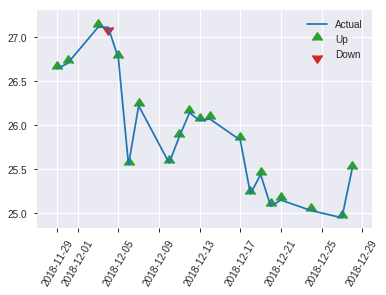


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2510013432473077
RMSE: 0.5010003425620663
LogLoss: 0.6952882248033614
Mean Per-Class Error: 0.4476825396825397
AUC: 0.5291428571428571
pr_auc: 0.5133374592122055
Gini: 0.058285714285714274
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42935603857040405: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      23   102  0.816    (102.0/125.0)
1      10   116  0.0794   (10.0/126.0)
Total  33   218  0.4462   (112.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.429356     0.674419  217
max f2                       0.349678     0.834437  250
max f0point5                 0.429356     0.581162  217
max accuracy                 0.429356     0.553785  217
max precision                0.70306      1         0
max recall                   0.349678     1         250
max specificity              0.70306      1         0
max absolute_mcc             0.429356     0.154822  217
max min_per_class_accuracy   0.47936      0.52      125
max mean_per_class_accuracy  0.429356     0.552317  217

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 48.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.682919           0.664021  0.664021           0.333333         0.693421  0.333333                    0.693421            0.00793651      0.00793651                 -33.5979   -33.5979
    2        0.0239044                   0.663458           0.664021  0.664021           0.333333         0.669238  0.333333                    0.68133             0.00793651      0.015873                   -33.5979   -33.5979
    3        0.0318725                   0.641059           1.99206   0.996032           1                0.652133  0.5                         0.67403             0.015873        0.031746                   99.2063    -0.396825
    4        0.0438247                   0.619651           1.32804   1.08658            0.666667         0.624673  0.545455                    0.660569            0.015873        0.047619                   32.8042    8.65801
    5        0.0517928                   0.612974           0.996032  1.07265            0.5              0.613872  0.538462                    0.653385            0.00793651      0.0555556                  -0.396825  7.26496
    6        0.103586                    0.57768            1.07265   1.07265            0.538462         0.594122  0.538462                    0.623754            0.0555556       0.111111                   7.26496    7.26496
    7        0.151394                    0.545457           1.16204   1.10088            0.583333         0.557551  0.552632                    0.602847            0.0555556       0.166667                   16.2037    10.0877
    8        0.203187                    0.5257             1.07265   1.09368            0.538462         0.533751  0.54902                     0.585235            0.0555556       0.222222                   7.26496    9.36819
    9        0.302789                    0.502565           0.876508  1.02224            0.44             0.51218   0.513158                    0.561204            0.0873016       0.309524                   -12.3492   2.22431
    10       0.40239                     0.490905           0.876508  0.98617            0.44             0.496398  0.49505                     0.545163            0.0873016       0.396825                   -12.3492   -1.383
    11       0.501992                    0.47936            1.27492   1.04346            0.64             0.484614  0.52381                     0.533149            0.126984        0.52381                    27.4921    4.34618
    12       0.601594                    0.463822           0.95619   1.02901            0.48             0.471163  0.516556                    0.522886            0.0952381       0.619048                   -4.38095   2.90129
    13       0.701195                    0.449043           0.95619   1.01867            0.48             0.456159  0.511364                    0.513408            0.0952381       0.714286                   -4.38095   1.86688
    14       0.800797                    0.437238           1.27492   1.05054            0.64             0.443725  0.527363                    0.504741            0.126984        0.84127                    27.4921    5.05409
    15       0.900398                    0.422096           0.876508  1.03129            0.44             0.4309    0.517699                    0.496573            0.0873016       0.928571                   -12.3492   3.12895
    16       1                           0.349678           0.717143  1                  0.36             0.399381  0.501992                 

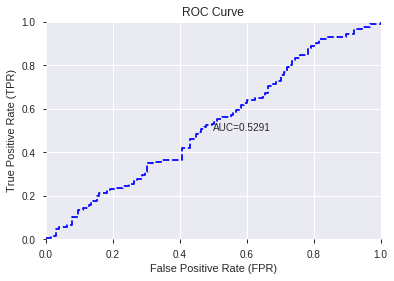

This function is available for GLM models only


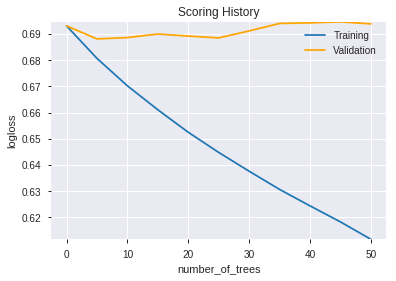

--2019-07-25 00:25:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.1.52
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.1.52|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genm

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_002440_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_002440_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_bd2d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_002538_model_2  0.507556  1.395559              0.487968  0.601081  0.361299
1  DeepLearning_grid_1_AutoML_20190725_002538_model_3  0.498730  1.819410              0.491968  0.610568  0.372793
2  DeepLearning_grid_1_AutoML_20190725_002538_model_5  0.492254  0.702544              0.491968  0.504606  0.254628
3               DeepLearning_1_AutoML_20190725_002538  0.484254  0.796023              0.491968  0.538209  0.289669
4  DeepLearning_grid_1_AutoML_20190725_002538_model_6  0.478603  0.728178              0.500000  0.515818  0.266068
5  DeepLearning_grid_1_AutoML_20190725_002538_model_8  0.478349  0.703965              0.500000  0.504830  0.254853
6  DeepLearning_grid_1_AutoML_20190725_002538_model_4  0.471683  1.164915              0.488000  0.605705  0.366878
7  DeepLearning_grid_1_AutoML_20190725_002538_model_1  0.471365  1.971106              0.488000  0.651235  0.424107
8  DeepLearning_grid_1_AutoML_20190725_002538_model_9  0.414952  0.694542              0.484000  0.500697  0.250697
9  DeepLearning_grid_1_AutoML_20190725_002538_model_7  0.400635  0.895389              0.500000  0.563111  0.317094

variable  relative_importance  scaled_importance  percentage
0              CDLBREAKAWAY             1.000000           1.000000    0.029744
1             CDLHIKKAKEMOD             0.953997           0.953997    0.028376
2                       day             0.944608           0.944608    0.028097
3                       BOP             0.941735           0.941735    0.028011
4                 CDLONNECK             0.900809           0.900809    0.026794
5               AROONOSC_30             0.865887           0.865887    0.025755
6                       COS             0.810815           0.810815    0.024117
7                    SAREXT             0.797964           0.797964    0.023735
8              aroondown_12             0.794709           0.794709    0.023638
9                      DX_8             0.786175           0.786175    0.023384
10               aroonup_24             0.767422           0.767422    0.022827
11             HT_TRENDMODE             0.761738           0.761738    0.022657
12                    CCI_8             0.761482           0.761482    0.022650
13                       AD             0.759884           0.759884    0.022602
14               aroonup_14             0.756962           0.756962    0.022515
15             aroondown_24             0.755050           0.755050    0.022459
16                CORREL_30             0.753884           0.753884    0.022424
17              HT_DCPERIOD             0.748226           0.748226    0.022256
18            days_in_month             0.732215           0.732215    0.021779
19                  BETA_14             0.715241           0.715241    0.021274
20                  ADXR_14             0.709173           0.709173    0.021094
21       LINEARREG_ANGLE_24             0.707698           0.707698    0.021050
22         CDLSTICKSANDWICH             0.707668           0.707668    0.021049
23                    DX_30             0.683085           0.683085    0.020318
24                   Volume             0.682488           0.682488    0.020300
25                  weekday             0.680654           0.680654    0.020246
26                dayofweek             0.667219           0.667219    0.019846
27                   ADX_24             0.664262           0.664262    0.019758
28  BBANDS_upperband_20_0_2             0.647716           0.647716    0.019266
29              CDLPIERCING             0.614344           0.614344    0.018273
30               PLUS_DM_12             0.608441           0.608441    0.018098
31              AROONOSC_14             0.601941           0.601941    0.017904
32                     week             0.599995           0.599995    0.017847
33              AROONOSC_24             0.597893           0.597893    0.017784
34                CORREL_20             0.591727           0.591727    0.017601
35                  WILLR_8             0.590618           0.590618    0.017568
36              MINUS_DM_24             0.588975           0.588975    0.017519
37                 WILLR_14             0.574039           0.574039    0.017074
38                      DIV             0.573236           0.573236    0.017051
39                  quarter             0.563583           0.563583    0.016763
40        LINEARREG_SLOPE_8             0.561870           0.561870    0.016712
41                   CCI_14             0.556599           0.556599    0.016556
42          CDLADVANCEBLOCK             0.545756           0.545756    0.016233
43                dayofyear             0.530379           0.530379    0.015776
44                    month             0.506412           0.506412    0.015063
45                     COSH             0.492265           0.492265    0.014642
46                      EXP             0.457222           0.457222    0.013600
47       CDLEVENINGDOJISTAR             0.455681           0.455681    0.013554
48        CDLDARKCLOUDCOVER             0.290778           0.290778    0.008649
49          CDLSHOO

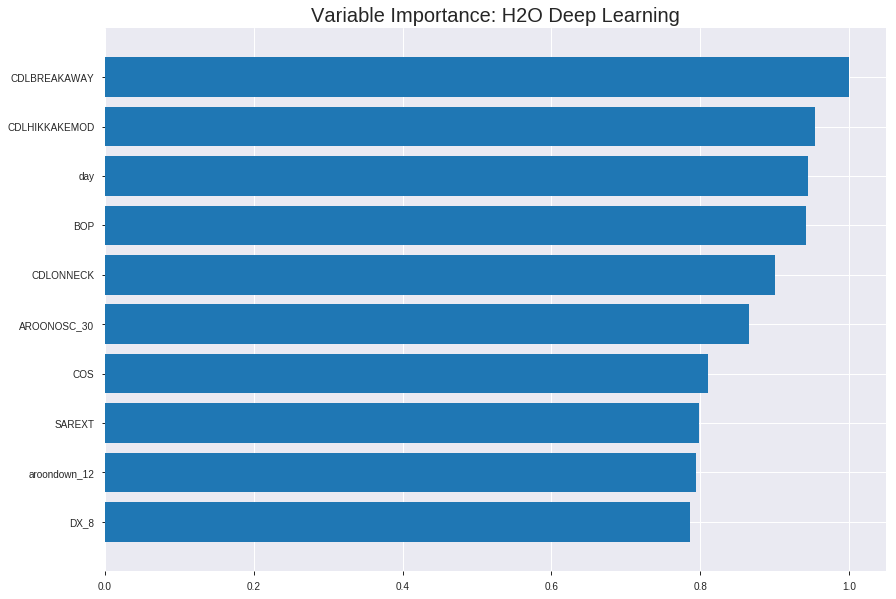

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_002538_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.28296088766888433
RMSE: 0.5319406805921919
LogLoss: 0.8660931666283674
Mean Per-Class Error: 0.4060695390742439
AUC: 0.612617378911817
pr_auc: 0.635701210946654
Gini: 0.225234757823634
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.007265333206002746: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      26   823   0.9694   (823.0/849.0)
1      9    896   0.0099   (9.0/905.0)
Total  35   1719  0.4743   (832.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00726533   0.682927  394
max f2                       0.00039385   0.842017  399
max f0point5                 0.410653     0.602837  213
max accuracy                 0.410653     0.59236   213
max precision                0.999943     1         0
max recall                   0.00039385   1         399
max specificity              0.999943     1         0
max absolute_mcc             0.655601     0.19647   115
max min_per_class_accuracy   0.366144     0.587845  231
max mean_per_class_accuracy  0.410653     0.59393   213

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 40.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102623                   0.961408           1.6151    1.6151             0.833333         0.978796   0.833333                    0.978796            0.0165746       0.0165746                  61.5101    61.5101
    2        0.0205245                   0.929128           1.6151    1.6151             0.833333         0.942447   0.833333                    0.960621            0.0165746       0.0331492                  61.5101    61.5101
    3        0.0302166                   0.909019           1.48209   1.57244            0.764706         0.919499   0.811321                    0.947431            0.0143646       0.0475138                  48.2093    57.2438
    4        0.0404789                   0.893322           1.39975   1.52866            0.722222         0.899845   0.788732                    0.935367            0.0143646       0.0618785                  39.9754    52.8659
    5        0.050171                    0.878758           1.36809   1.49764            0.705882         0.886983   0.772727                    0.92602             0.0132597       0.0751381                  36.8086    49.7639
    6        0.100342                    0.812615           1.34347   1.42055            0.693182         0.845331   0.732955                    0.885676            0.0674033       0.142541                   34.3471    42.0555
    7        0.149943                    0.74182            1.31436   1.38543            0.678161         0.776775   0.714829                    0.849651            0.0651934       0.207735                   31.4358    38.5425
    8        0.200114                    0.678868           1.29942   1.36386            0.670455         0.710432   0.703704                    0.814747            0.0651934       0.272928                   29.9422    36.3863
    9        0.299886                    0.575271           1.11857   1.28226            0.577143         0.624292   0.661597                    0.751383            0.111602        0.38453                    11.8573    28.2255
    10       0.400228                    0.464754           0.991085  1.20926            0.511364         0.519889   0.623932                    0.693344            0.0994475       0.483978                   -0.891512  20.9255
    11       0.5                         0.36689            1.0189    1.17127            0.525714         0.414385   0.604333                    0.63768             0.101657        0.585635                   1.88982    17.1271
    12       0.599772                    0.278401           0.808474  1.11092            0.417143         0.322018   0.573194                    0.58517             0.080663        0.666298                   -19.1526   11.0919
    13       0.700114                    0.196177           0.781856  1.06376            0.403409         0.236865   0.54886                     0.53525             0.078453        0.744751                   -21.8144   6.37573
    14       0.799886                    0.121247           0.852773  1.03744            0.44             0.156699   0.535282                    0.488032            0.0850829       0.829834                   -14.7227   3.74407
    15       0.899658                    0.0485193          0.897073  1.02187            0.462857         0.0839059  0.52725                     0.443214            0.0895028       0.919337                   -10.2927   2.1874
    16       1                           0.000209129        0.80388   1                  0.414773         0.0223429  0.515964   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3236434028850642
RMSE: 0.5688966539584006
LogLoss: 0.9858001075920543
Mean Per-Class Error: 0.4493727959292121
AUC: 0.5306999887280398
pr_auc: 0.590660768228359
Gini: 0.06139997745607961
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0011251118720007297: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    219  0.991    (219.0/221.0)
1      1    280  0.0036   (1.0/281.0)
Total  3    499  0.4382   (220.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00112511   0.717949  398
max f2                       0.000127082  0.864084  399
max f0point5                 0.00462425   0.615862  396
max accuracy                 0.0310879    0.563745  382
max precision                0.978243     1         0
max recall                   0.000127082  1         399
max specificity              0.978243     1         0
max absolute_mcc             0.477708     0.103426  160
max min_per_class_accuracy   0.378079     0.538462  208
max mean_per_class_accuracy  0.477708     0.550627  160

Gains/Lift Table: Avg response rate: 55.98 %, avg score: 39.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.924688           1.48873   1.48873            0.833333         0.944926   0.833333                    0.944926            0.0177936       0.0177936                  48.8731    48.8731
    2        0.0219124                   0.894842           1.07189   1.29926            0.6              0.900505   0.727273                    0.924735            0.0106762       0.0284698                  7.18861    29.9256
    3        0.0318725                   0.876443           0.714591  1.11655            0.4              0.885061   0.625                       0.912337            0.00711744      0.0355872                  -28.5409   11.6548
    4        0.0418327                   0.84262            1.78648   1.27605            1                0.857778   0.714286                    0.899347            0.0177936       0.0533808                  78.6477    27.6055
    5        0.0517928                   0.812547           0.357295  1.09937            0.2              0.825538   0.615385                    0.885153            0.00355872      0.0569395                  -64.2705   9.93704
    6        0.101594                    0.738618           1.00043   1.05087            0.56             0.777182   0.588235                    0.832226            0.0498221       0.106762                   0.0427046  5.08687
    7        0.151394                    0.676235           1.2148    1.10479            0.68             0.704482   0.618421                    0.790205            0.0604982       0.16726                    21.4804    10.4795
    8        0.201195                    0.629512           1.14335   1.11434            0.64             0.655544   0.623762                    0.756873            0.0569395       0.224199                   14.3345    11.4337
    9        0.300797                    0.537952           1.07189   1.10028            0.6              0.580607   0.615894                    0.698507            0.106762        0.330961                   7.18861    10.028
    10       0.400398                    0.459936           1.10762   1.10211            0.62             0.504458   0.616915                    0.650236            0.11032         0.441281                   10.7616    10.2105
    11       0.5                         0.383998           0.964698  1.07473            0.54             0.421902   0.601594                    0.604751            0.0960854       0.537367                   -3.53025   7.47331
    12       0.599602                    0.296165           0.821779  1.03271            0.46             0.343535   0.578073                    0.56136             0.0818505       0.619217                   -17.8221   3.27142
    13       0.699203                    0.20994            0.78605   0.997577           0.44             0.256321   0.558405                    0.517907            0.0782918       0.697509                   -21.395    -0.242317
    14       0.798805                    0.128446           0.78605   0.971202           0.44             0.1731     0.543641                    0.474913            0.0782918       0.775801                   -21.395    -2.87981
    15       0.898406                    0.0629397          1.2148    0.998209           0.68             0.0946375  0.558758                    0.432754            0.120996        0.896797                   21.4804    -0.17912
    16       1                           7.96952e-06        1.01584   1                  0.568627         0.0304933  0.55976


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 00:26:37  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 00:26:39  59.954 sec        6496 obs/sec      10        1             17540      0.564476         0.990019            -0.275835      0.542769        0.567587           1.18441          0.484036                         0.601054           1.09145               -0.466008        0.488181          0.55433              0.893238           0.430279
    2019-07-25 00:26:45  1 min  6.022 sec  8097 obs/sec      40        4             70160      0.531941         0.866093            -0.132998      0.612617        0.635701           1.6151           0.474344                         0.568897           0.9858                -0.313335        0.5307            0.590661             1.48873            0.438247
    2019-07-25 00:26:50  1 min 11.097 sec  9010 obs/sec      70        7             122780     0.510089         0.831705            -0.0418238     0.673392        0.702334           1.72277          0.476625                         0.578753           1.04375               -0.359239        0.528921          0.600626             1.48873            0.436255
    2019-07-25 00:26:56  1 min 17.139 sec  9852 obs/sec      110       11            192940     0.503117         0.83982             -0.0135397     0.697332        0.7191             1.83045          0.462372                         0.576263           1.08978               -0.347567        0.549895          0.609453             1.48873            0.436255
    2019-07-25 00:27:02  1 min 22.831 sec  10451 obs/sec     150       15            263100     0.473517         0.743366            0.102211       0.751563        0.78072            1.83045          0.340935                         0.563041           1.0193                -0.28644         0.553864          0.607802             0.893238           0.440239
    2019-07-25 00:27:08  1 min 28.312 sec  10902 obs/sec     190       19            333260     0.450268         0.66669             0.188207       0.784508        0.807964           1.93812          0.303877                         0.568129           1.08205               -0.309794        0.548131          0.605522             1.19098            0.440239
    2019-07-25 00:27:08  1 min 28.405 sec  10899 obs/sec     190       19            333260     0.531941         0.866093            -0.132998      0.612617        0.635701           1.6151           0.474344                         0.568897           0.9858                -0.313335        0.5307            0.590661             1.48873            0.438247

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLBREAKAWAY        1.0                    1.0                  0.029744406671752415
CDLHIKKAKEMOD       0.9539970755577087     0.9539970755577087   0.028376076979051004
day                 0.9446080923080444     0.9446080923080444   0.02809680724303872
BOP                 0.9417346119880676     0.9417346119880676   0.02801133727583805
CDLONNECK           0.9008094668388367     0.9008094668388367   0.02679404311541883
---                 ---                    ---                  ---
COSH                0.49226513504981995    0.49226513504981995  0.014642134367246968
EXP                 0.45722243189811707    0.45722243189811707  0.013599809953825218
CDLEVENINGDOJISTAR  0.45568129420280457    0.45568129420280457  0.013553969727478675
CDLDARKCLOUDCOVER   0.2907780110836029     0.2907780110836029   0.008649019412874015
CDLSHOOTINGSTAR     0.25924399495124817    0.25924399495124817  0.007711058813039655


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5338645418326693)

('F1', 0.6720430107526881)

('auc', 0.5075555555555555)

('logloss', 1.3955592755025323)

('mean_per_class_error', 0.46571428571428575)

('rmse', 0.6010813187119719)

('mse', 0.3612987517045231)

deeplearning prediction progress: |███████████████████████████████████████| 100%


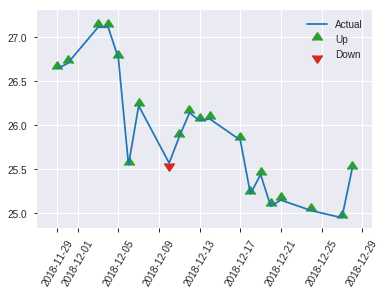


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3612987517045231
RMSE: 0.6010813187119719
LogLoss: 1.3955592755025323
Mean Per-Class Error: 0.46571428571428575
AUC: 0.5075555555555555
pr_auc: 0.5071587984791005
Gini: 0.015111111111111075
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0005489981860893054: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    121  0.968    (121.0/125.0)
1      1    125  0.0079   (1.0/126.0)
Total  5    246  0.4861   (122.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.000548998  0.672043   245
max f2                       0.000312905  0.836653   248
max f0point5                 0.000548998  0.563063   245
max accuracy                 0.26911      0.533865   98
max precision                0.781837     0.625      7
max recall                   0.000312905  1          248
max specificity              1            0.992      0
max absolute_mcc             0.99993      0.0899799  1
max min_per_class_accuracy   0.201467     0.52       125
max mean_per_class_accuracy  0.26911      0.534286   98

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 25.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.871471           0.664021  0.664021           0.333333         0.960971    0.333333                    0.960971            0.00793651      0.00793651                 -33.5979   -33.5979
    2        0.0239044                   0.822255           1.32804   0.996032           0.666667         0.845871    0.5                         0.903421            0.015873        0.0238095                  32.8042    -0.396825
    3        0.0318725                   0.769937           1.99206   1.24504            1                0.781963    0.625                       0.873057            0.015873        0.0396825                  99.2063    24.504
    4        0.0438247                   0.741724           0         0.905483           0                0.751431    0.454545                    0.839886            0               0.0396825                  -100       -9.45166
    5        0.0517928                   0.70461            0.996032  0.919414           0.5              0.712204    0.461538                    0.820243            0.00793651      0.047619                   -0.396825  -8.05861
    6        0.103586                    0.602197           0.919414  0.919414           0.461538         0.649491    0.461538                    0.734867            0.047619        0.0952381                  -8.05861   -8.05861
    7        0.151394                    0.529085           1.32804   1.04845            0.666667         0.555136    0.526316                    0.67811             0.0634921       0.15873                    32.8042    4.84545
    8        0.203187                    0.439357           1.37912   1.13274            0.692308         0.484875    0.568627                    0.628854            0.0714286       0.230159                   37.9121    13.2742
    9        0.302789                    0.332367           0.95619   1.07467            0.48             0.383883    0.539474                    0.548271            0.0952381       0.325397                   -4.38095   7.46658
    10       0.40239                     0.263078           1.03587   1.06506            0.52             0.296522    0.534653                    0.485957            0.103175        0.428571                   3.5873     6.50636
    11       0.501992                    0.201467           0.95619   1.04346            0.48             0.227442    0.52381                     0.434664            0.0952381       0.52381                    -4.38095   4.34618
    12       0.601594                    0.13392            0.717143  0.989436           0.36             0.167035    0.496689                    0.390355            0.0714286       0.595238                   -28.2857   -1.05645
    13       0.701195                    0.0822145          1.19524   1.01867            0.6              0.108321    0.511364                    0.350293            0.119048        0.714286                   19.5238    1.86688
    14       0.800797                    0.0254723          0.796825  0.991076           0.4              0.0549928   0.497512                    0.313564            0.0793651       0.793651                   -20.3175   -0.892364
    15       0.900398                    0.0102338          0.876508  0.978403           0.44             0.0170908   0.49115                     0.280769            0.0873016       0.880952                   -12.3492   -2.15971
    16       1                           5.25604e-05        1.19524   1                  0.6         

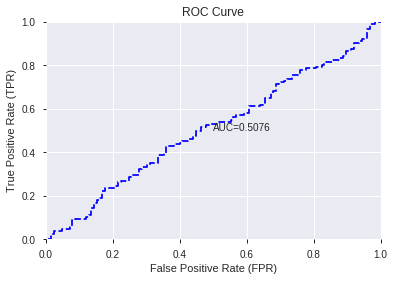

This function is available for GLM models only


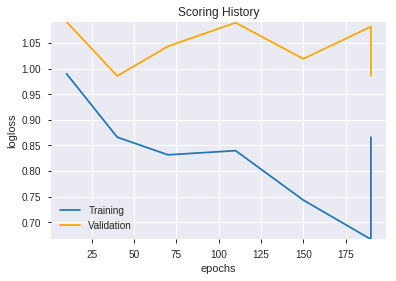

--2019-07-25 00:34:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.111.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.111.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_002538_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_002538_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_bd2d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLBREAKAWAY',
 'CDLHIKKAKEMOD',
 'day',
 'BOP',
 'CDLONNECK',
 'AROONOSC_30',
 'COS',
 'SAREXT',
 'aroondown_12',
 'DX_8',
 'aroonup_24',
 'HT_TRENDMODE',
 'CCI_8',
 'AD',
 'aroonup_14',
 'aroondown_24',
 'CORREL_30',
 'HT_DCPERIOD',
 'days_in_month',
 'BETA_14',
 'ADXR_14',
 'LINEARREG_ANGLE_24',
 'CDLSTICKSANDWICH',
 'DX_30',
 'Volume',
 'weekday',
 'dayofweek',
 'ADX_24',
 'BBANDS_upperband_20_0_2',
 'CDLPIERCING',
 'PLUS_DM_12',
 'AROONOSC_14',
 'week',
 'AROONOSC_24',
 'CORREL_20',
 'WILLR_8',
 'MINUS_DM_24',
 'WILLR_14',
 'DIV',
 'quarter',
 'LINEARREG_SLOPE_8',
 'CCI_14',
 'CDLADVANCEBLOCK',
 'dayofyear',
 'month',
 'COSH',
 'EXP',
 'CDLEVENINGDOJISTAR',
 'CDLDARKCLOUDCOVER',
 'CDLSHOOTINGSTAR']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_003442_model_1  0.499937  0.694664                   0.5  0.500751  0.250752

variable  relative_importance  scaled_importance  percentage
0                 dayofweek             0.012466           1.000000    0.055656
1                   weekday             0.012463           0.999735    0.055641
2                 CORREL_20             0.010945           0.877969    0.048864
3                    CCI_14             0.009957           0.798748    0.044455
4               AROONOSC_30             0.008979           0.720264    0.040087
5                     CCI_8             0.008797           0.705673    0.039275
6                       day             0.008143           0.653211    0.036355
7   BBANDS_upperband_20_0_2             0.008051           0.645844    0.035945
8                    ADX_24             0.007820           0.627306    0.034913
9                        AD             0.007659           0.614418    0.034196
10                 WILLR_14             0.007503           0.601871    0.033498
11                  BETA_14             0.006975           0.559545    0.031142
12                      BOP             0.006151           0.493415    0.027461
13                  WILLR_8             0.006032           0.483876    0.026930
14                  ADXR_14             0.005959           0.478002    0.026604
15                      DIV             0.005609           0.449958    0.025043
16                      COS             0.005573           0.447024    0.024880
17             CDLBREAKAWAY             0.005570           0.446805    0.024867
18            CDLHIKKAKEMOD             0.005389           0.432292    0.024060
19       CDLEVENINGDOJISTAR             0.005134           0.411854    0.022922
20                     COSH             0.004791           0.384350    0.021391
21                      EXP             0.004781           0.383496    0.021344
22                     DX_8             0.004422           0.354711    0.019742
23       LINEARREG_ANGLE_24             0.004141           0.332200    0.018489
24               aroonup_14             0.003769           0.302346    0.016827
25                CDLONNECK             0.003593           0.288259    0.016043
26              CDLPIERCING             0.003547           0.284515    0.015835
27            days_in_month             0.003327           0.266850    0.014852
28              AROONOSC_24             0.002651           0.212622    0.011834
29                   Volume             0.002612           0.209528    0.011661
30               aroonup_24             0.002607           0.209139    0.011640
31                    DX_30             0.002511           0.201450    0.011212
32             HT_TRENDMODE             0.002490           0.199780    0.011119
33             aroondown_12             0.002383           0.191158    0.010639
34        CDLDARKCLOUDCOVER             0.002330           0.186874    0.010401
35              AROONOSC_14             0.002312           0.185505    0.010324
36                dayofyear             0.002196           0.176176    0.009805
37                CORREL_30             0.002115           0.169692    0.009444
38             aroondown_24             0.001986           0.159327    0.008867
39        LINEARREG_SLOPE_8             0.001861           0.149250    0.008307
40                    month             0.001551           0.124433    0.006925
41                  quarter             0.001478           0.118551    0.006598
42                     week             0.001352           0.108423    0.006034
43               PLUS_DM_12             0.001119           0.089794    0.004998
44          CDLADVANCEBLOCK             0.001033           0.082895    0.004614
45              HT_DCPERIOD             0.000846           0.067841    0.003776
46              MINUS_DM_24             0.000457           0.036690    0.002042
47         CDLSTICKSANDWICH             0.000251           0.020098    0.001119
48          CDLSHOOTINGSTAR             0.000244           0.019541    0.001088
49                 

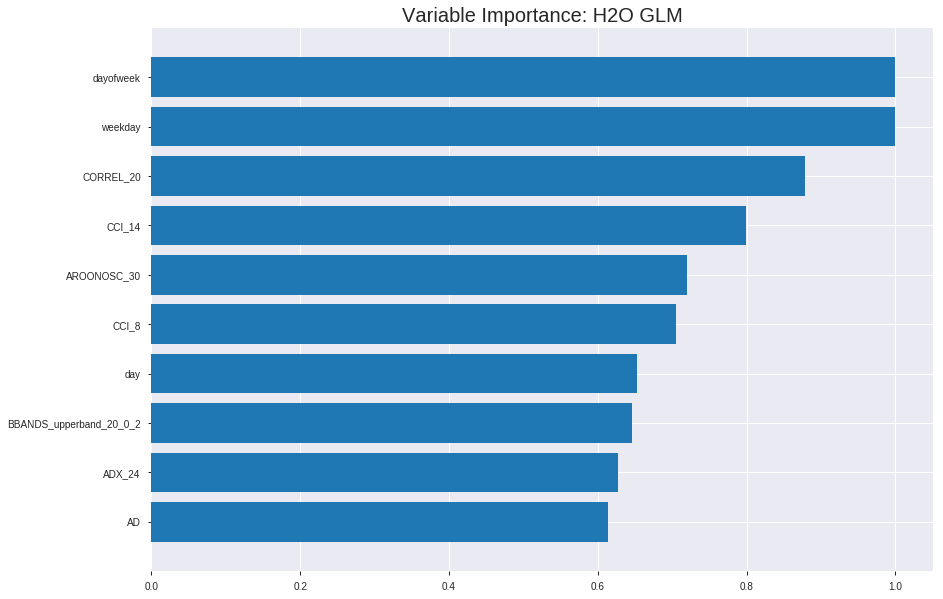

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_003442_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24818613444263635
RMSE: 0.49818283234434757
LogLoss: 0.6895130444951699
Null degrees of freedom: 1753
Residual degrees of freedom: 1703
Null deviance: 2429.7720921923756
Residual deviance: 2418.811760089056
AIC: 2520.811760089056
AUC: 0.5728182001574813
pr_auc: 0.5804037976410703
Gini: 0.1456364003149626
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.479854586427087: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      7    842   0.9918   (842.0/849.0)
1      2    903   0.0022   (2.0/905.0)
Total  9    1745  0.4812   (844.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479855     0.681509  390
max f2                       0.479144     0.842027  393
max f0point5                 0.511843     0.586928  227
max accuracy                 0.511932     0.566135  226
max precision                0.590237     1         0
max recall                   0.468033     1         399
max specificity              0.590237     1         0
max absolute_mcc             0.511843     0.128543  227
max min_per_class_accuracy   0.516549     0.552415  188
max mean_per_class_accuracy  0.511932     0.561774  226

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 51.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.544994           1.39975   1.39975            0.722222         0.552231  0.722222                    0.552231            0.0143646       0.0143646                  39.9754   39.9754
    2        0.0205245                   0.541826           1.50743   1.45359            0.777778         0.543214  0.75                        0.547722            0.0154696       0.0298343                  50.7428   45.3591
    3        0.0302166                   0.539865           1.02606   1.31646            0.529412         0.540722  0.679245                    0.545477            0.00994475      0.039779                   2.60643   31.646
    4        0.0404789                   0.538264           1.18441   1.28298            0.611111         0.53917   0.661972                    0.543878            0.0121547       0.0519337                  18.4408   28.2982
    5        0.050171                    0.53718            0.912057  1.21133            0.470588         0.537539  0.625                       0.542653            0.00883978      0.0607735                  -8.79428  21.1326
    6        0.100342                    0.533143           1.21133   1.21133            0.625            0.535308  0.625                       0.538981            0.0607735       0.121547                   21.1326   21.1326
    7        0.149943                    0.530057           1.15842   1.19382            0.597701         0.531596  0.61597                     0.536538            0.0574586       0.179006                   15.8417   19.3824
    8        0.200114                    0.527615           1.14525   1.18165            0.590909         0.528761  0.609687                    0.534588            0.0574586       0.236464                   14.5254   18.1647
    9        0.299886                    0.523204           1.05212   1.13855            0.542857         0.525425  0.587452                    0.53154             0.104972        0.341436                   5.21231   13.8554
    10       0.400228                    0.519937           1.04615   1.11539            0.539773         0.521586  0.575499                    0.529044            0.104972        0.446409                   4.61452   11.5386
    11       0.5                         0.516604           1.05212   1.10276            0.542857         0.518224  0.568985                    0.526885            0.104972        0.551381                   5.21231   10.2762
    12       0.599772                    0.513376           1.0632    1.09618            0.548571         0.514897  0.565589                    0.524891            0.106077        0.657459                   6.31981   9.61809
    13       0.700114                    0.509077           0.902988  1.06849            0.465909         0.511247  0.551303                    0.522935            0.0906077       0.748066                   -9.70116  6.84921
    14       0.799886                    0.504419           0.897073  1.04711            0.462857         0.506741  0.540271                    0.520915            0.0895028       0.837569                   -10.2927  4.71106
    15       0.899658                    0.497934           0.786324  1.01819            0.405714         0.501611  0.525349                    0.518774            0.078453        0.916022                   -21.3676  1.81893
    16       1                           0.468033           0.836916  1                  0.431818         0.490761  0.515964                    0.515964          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24808188421421226
RMSE: 0.4980781908638565
LogLoss: 0.6893070207477883
Null degrees of freedom: 501
Residual degrees of freedom: 451
Null deviance: 692.5991909148838
Residual deviance: 692.0642488307794
AIC: 794.0642488307794
AUC: 0.522004476578477
pr_auc: 0.5795122976013651
Gini: 0.04400895315695408
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48783184765734516: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    214  0.9683   (214.0/221.0)
1      2    279  0.0071   (2.0/281.0)
Total  9    493  0.4303   (216.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.487832     0.72093    390
max f2                       0.470507     0.864084   399
max f0point5                 0.487832     0.619174   390
max accuracy                 0.487832     0.569721   390
max precision                0.54842      1          0
max recall                   0.470507     1          399
max specificity              0.54842      1          0
max absolute_mcc             0.487832     0.0918704  390
max min_per_class_accuracy   0.515896     0.493213   198
max mean_per_class_accuracy  0.519263     0.532198   154

Gains/Lift Table: Avg response rate: 55.98 %, avg score: 51.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.545413           1.19098   1.19098            0.666667         0.546595  0.666667                    0.546595            0.0142349       0.0142349                  19.0985    19.0985
    2        0.0219124                   0.540656           1.07189   1.13685            0.6              0.54322   0.636364                    0.545061            0.0106762       0.024911                   7.18861    13.6849
    3        0.0318725                   0.538965           1.07189   1.11655            0.6              0.539629  0.625                       0.543363            0.0106762       0.0355872                  7.18861    11.6548
    4        0.0418327                   0.536472           1.78648   1.27605            1                0.537218  0.714286                    0.5419              0.0177936       0.0533808                  78.6477    27.6055
    5        0.0517928                   0.535772           1.07189   1.23679            0.6              0.536149  0.692308                    0.540794            0.0106762       0.0640569                  7.18861    23.6792
    6        0.101594                    0.530805           0.857509  1.05087            0.48             0.533071  0.588235                    0.537008            0.0427046       0.106762                   -14.2491   5.08687
    7        0.151394                    0.527635           1.2148    1.10479            0.68             0.528918  0.618421                    0.534347            0.0604982       0.16726                    21.4804    10.4795
    8        0.201195                    0.525219           0.928968  1.06127            0.52             0.526218  0.594059                    0.532335            0.0462633       0.213523                   -7.1032    6.12734
    9        0.300797                    0.521798           1.07189   1.06479            0.6              0.523342  0.596026                    0.529357            0.106762        0.320285                   7.18861    6.47875
    10       0.400398                    0.518606           1.03616   1.05767            0.58             0.520296  0.59204                     0.527103            0.103203        0.423488                   3.61566    5.76654
    11       0.5                         0.515895           0.75032   0.996441           0.42             0.51714   0.557769                    0.525118            0.0747331       0.498221                   -24.968    -0.355872
    12       0.599602                    0.512221           1.10762   1.01491            0.62             0.514021  0.568106                    0.523275            0.11032         0.608541                   10.7616    1.49088
    13       0.699203                    0.508102           1.03616   1.01794            0.58             0.510298  0.569801                    0.521426            0.103203        0.711744                   3.61566    1.79355
    14       0.798805                    0.503955           1.00043   1.01575            0.56             0.50609   0.568579                    0.519514            0.0996441       0.811388                   0.0427046  1.57524
    15       0.898406                    0.497643           0.928968  1.00613            0.52             0.500697  0.563193                    0.517428            0.0925267       0.903915                   -7.1032    0.61311
    16       1                           0.470507           0.945782  1                  0.529412         0.492062  0.559761                  


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 00:34:42  0.000 sec   2            2.9       51            1.38089           1.37876
    2019-07-25 00:34:42  0.024 sec   4            1.8       51            1.37903           1.37861
    2019-07-25 00:34:42  0.048 sec   6            1.1       51            1.37673           1.37864
    2019-07-25 00:34:42  0.070 sec   8            0.7       51            1.37411           1.37892
    2019-07-25 00:34:42  0.082 sec   10           0.43      51            1.37132           1.37949
    2019-07-25 00:34:42  0.096 sec   12           0.27      51            1.36855           1.38029
    2019-07-25 00:34:42  0.112 sec   14           0.17      51            1.36595           1.38116

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5338645418326693)

('F1', 0.6684350132625995)

('auc', 0.49993650793650796)

('logloss', 0.6946643782820572)

('mean_per_class_error', 0.46758730158730155)

('rmse', 0.5007512368195245)

('mse', 0.2507518011762835)

glm prediction progress: |████████████████████████████████████████████████| 100%


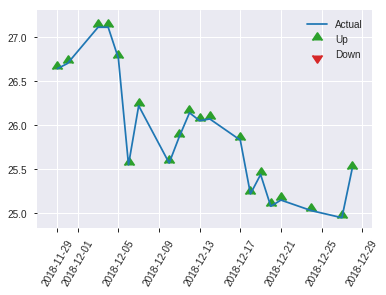


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2507518011762835
RMSE: 0.5007512368195245
LogLoss: 0.6946643782820572
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 348.1519924217104
Residual deviance: 348.72151789759266
AIC: 450.72151789759266
AUC: 0.49993650793650796
pr_auc: 0.49375835643725674
Gini: -0.00012698412698408656
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4754819389246321: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    125  1        (125.0/125.0)
1      0    126  0        (0.0/126.0)
Total  0    251  0.498    (125.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.475482     0.668435  250
max f2                       0.475482     0.834437  250
max f0point5                 0.492597     0.56841   216
max accuracy                 0.492597     0.533865  216
max precision                0.531894     0.566667  29
max recall                   0.475482     1         250
max specificity              0.594986     0.992     0
max absolute_mcc             0.485444     0.111145  238
max min_per_class_accuracy   0.512494     0.492063  120
max mean_per_class_accuracy  0.492597     0.532413  216

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 51.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.556242           0.664021  0.664021           0.333333         0.571999  0.333333                    0.571999            0.00793651      0.00793651                 -33.5979   -33.5979
    2        0.0239044                   0.550814           1.32804   0.996032           0.666667         0.551728  0.5                         0.561863            0.015873        0.0238095                  32.8042    -0.396825
    3        0.0318725                   0.546126           0         0.747024           0                0.547933  0.375                       0.558381            0               0.0238095                  -100       -25.2976
    4        0.0438247                   0.542805           0.664021  0.724387           0.333333         0.544258  0.363636                    0.554529            0.00793651      0.031746                   -33.5979   -27.5613
    5        0.0517928                   0.541042           0.996032  0.766178           0.5              0.542023  0.384615                    0.552605            0.00793651      0.0396825                  -0.396825  -23.3822
    6        0.103586                    0.533483           1.22589   0.996032           0.615385         0.536304  0.5                         0.544454            0.0634921       0.103175                   22.5885    -0.396825
    7        0.151394                    0.528355           0.996032  0.996032           0.5              0.530543  0.5                         0.540061            0.047619        0.150794                   -0.396825  -0.396825
    8        0.203187                    0.52618            0.766178  0.937442           0.384615         0.52708   0.470588                    0.536752            0.0396825       0.190476                   -23.3822   -6.25584
    9        0.302789                    0.520085           0.95619   0.943609           0.48             0.522651  0.473684                    0.532114            0.0952381       0.285714                   -4.38095   -5.6391
    10       0.40239                     0.515686           1.3546    1.04534            0.68             0.517966  0.524752                    0.528612            0.134921        0.420635                   35.4603    4.53402
    11       0.501992                    0.510983           0.717143  0.980222           0.36             0.513531  0.492063                    0.52562             0.0714286       0.492063                   -28.2857   -1.97783
    12       0.601594                    0.506625           1.03587   0.989436           0.52             0.508672  0.496689                    0.522814            0.103175        0.595238                   3.5873     -1.05645
    13       0.701195                    0.50283            1.11556   1.00735            0.56             0.504734  0.505682                    0.520246            0.111111        0.706349                   11.5556    0.735029
    14       0.800797                    0.49733            1.11556   1.02081            0.56             0.500032  0.512438                    0.517732            0.111111        0.81746                    11.5556    2.08087
    15       0.900398                    0.491333           0.876508  1.00485            0.44             0.49373   0.504425                    0.515077            0.0873016       0.904762                   -12.3492   0.484619
    16       1                           0.475482           0.95619   1                  0.48             0.485205  0.501992     

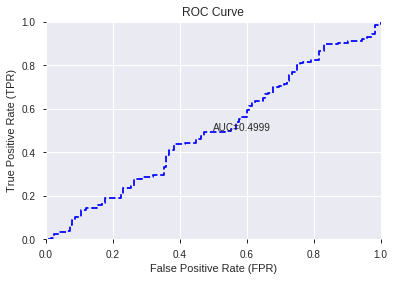

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


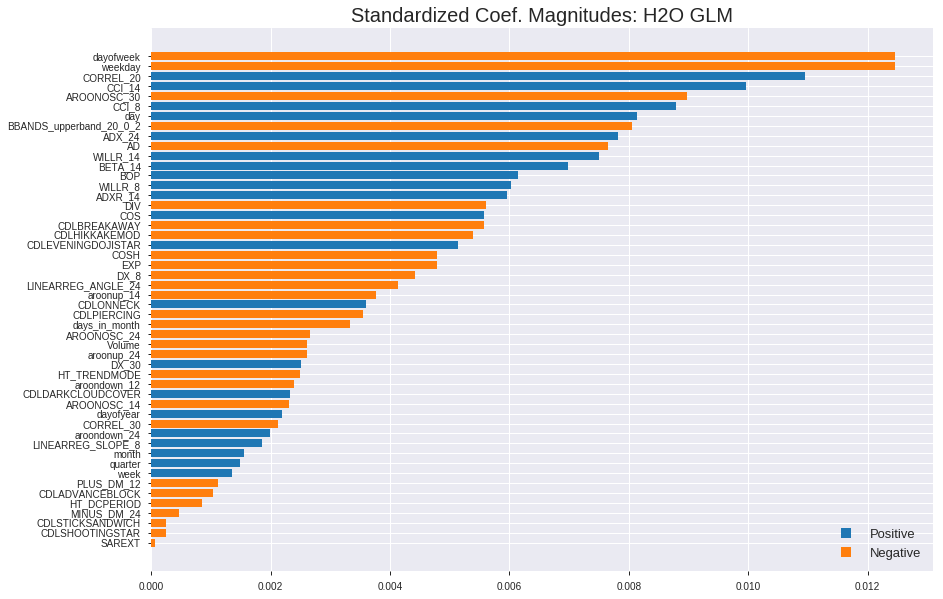

'log_likelihood'
--2019-07-25 00:34:52--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.134.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.134.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_003442_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_003442_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_bd2d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['dayofweek',
 'weekday',
 'CORREL_20',
 'CCI_14',
 'AROONOSC_30',
 'CCI_8',
 'day',
 'BBANDS_upperband_20_0_2',
 'ADX_24',
 'AD',
 'WILLR_14',
 'BETA_14',
 'BOP',
 'WILLR_8',
 'ADXR_14',
 'DIV',
 'COS',
 'CDLBREAKAWAY',
 'CDLHIKKAKEMOD',
 'CDLEVENINGDOJISTAR',
 'COSH',
 'EXP',
 'DX_8',
 'LINEARREG_ANGLE_24',
 'aroonup_14',
 'CDLONNECK',
 'CDLPIERCING',
 'days_in_month',
 'AROONOSC_24',
 'Volume',
 'aroonup_24',
 'DX_30',
 'HT_TRENDMODE',
 'aroondown_12',
 'CDLDARKCLOUDCOVER',
 'AROONOSC_14',
 'dayofyear',
 'CORREL_30',
 'aroondown_24',
 'LINEARREG_SLOPE_8',
 'month',
 'quarter',
 'week',
 'PLUS_DM_12',
 'CDLADVANCEBLOCK',
 'HT_DCPERIOD',
 'MINUS_DM_24',
 'CDLSTICKSANDWICH',
 'CDLSHOOTINGSTAR',
 'SAREXT']

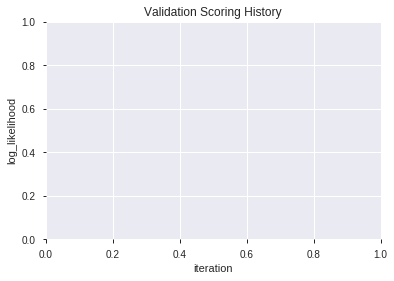

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190725_003501  0.531937  0.709621              0.492000  0.507530  0.257587
1               XGBoost_3_AutoML_20190725_003501  0.529841  0.704975              0.492000  0.505415  0.255444
2  XGBoost_grid_1_AutoML_20190725_003501_model_2  0.513016  0.699433              0.492000  0.503037  0.253046
3  XGBoost_grid_1_AutoML_20190725_003501_model_4  0.508825  0.700551              0.479873  0.503556  0.253569
4  XGBoost_grid_1_AutoML_20190725_003501_model_7  0.488889  0.717145              0.491968  0.511293  0.261420
5  XGBoost_grid_1_AutoML_20190725_003501_model_3  0.488762  0.716339              0.492000  0.510832  0.260950
6  XGBoost_grid_1_AutoML_20190725_003501_model_6  0.484825  0.717298              0.484000  0.511314  0.261442
7               XGBoost_2_AutoML_20190725_003501  0.480000  0.719068              0.500000  0.512189  0.262338
8  XGBoost_grid_1_AutoML_20190725_003501_model_5  0.475492  0.760213              0.492000  0.528669  0.279491
9  XGBoost_grid_1_AutoML_20190725_003501_model_1  0.461968  0.727790              0.491937  0.516174  0.266435

variable  relative_importance  scaled_importance  percentage
0                 CORREL_30           413.433990           1.000000    0.056595
1                   BETA_14           361.853851           0.875240    0.049534
2                       DIV           359.078522           0.868527    0.049154
3               HT_DCPERIOD           332.679199           0.804673    0.045541
4                    Volume           309.127991           0.747708    0.042317
5                       COS           299.147766           0.723568    0.040950
6                     DX_30           285.522308           0.690612    0.039085
7                    ADX_24           270.794281           0.654988    0.037069
8                   ADXR_14           249.011017           0.602299    0.034087
9         LINEARREG_SLOPE_8           244.900101           0.592356    0.033524
10                    CCI_8           244.017670           0.590222    0.033404
11               PLUS_DM_12           243.382751           0.588686    0.033317
12                   SAREXT           232.605057           0.562617    0.031841
13                     DX_8           231.738358           0.560521    0.031723
14                      day           229.899933           0.556074    0.031471
15                      BOP           221.174728           0.534970    0.030277
16                CORREL_20           215.191177           0.520497    0.029458
17              MINUS_DM_24           200.077240           0.483940    0.027389
18                  WILLR_8           187.320312           0.453084    0.025642
19                       AD           178.305817           0.431280    0.024408
20              AROONOSC_30           176.195450           0.426176    0.024119
21                dayofyear           163.820282           0.396243    0.022425
22                 WILLR_14           162.516220           0.393089    0.022247
23                   CCI_14           161.572968           0.390807    0.022118
24                dayofweek           148.096848           0.358212    0.020273
25                     COSH           148.061844           0.358127    0.020268
26       LINEARREG_ANGLE_24           133.144592           0.322046    0.018226
27  BBANDS_upperband_20_0_2           128.363464           0.310481    0.017572
28                     week           112.144814           0.271252    0.015352
29              AROONOSC_14           101.298698           0.245018    0.013867
30             aroondown_24            99.042320           0.239560    0.013558
31               aroonup_24            94.096886           0.227598    0.012881
32               aroonup_14            90.450500           0.218779    0.012382
33             aroondown_12            60.103493           0.145376    0.008228
34              AROONOSC_24            56.040588           0.135549    0.007671
35                  weekday            49.223129           0.119059    0.006738
36                      EXP            43.268234           0.104656    0.005923
37                    month            25.991226           0.062867    0.003558
38            days_in_month            22.116199           0.053494    0.003027
39             HT_TRENDMODE            16.770735           0.040564    0.002296
40                  quarter             3.545389           0.008575    0.000485

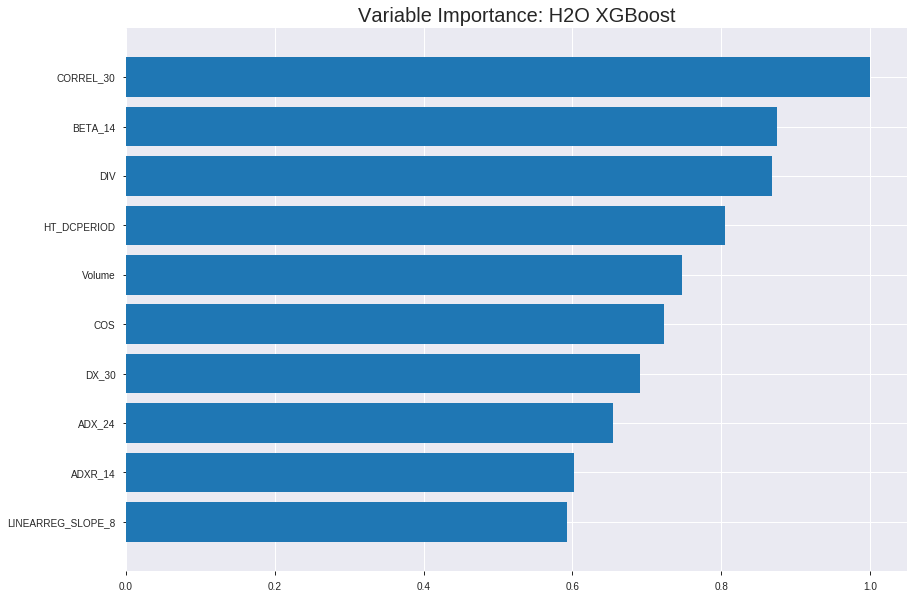

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190725_003501


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15853700923085146
RMSE: 0.39816706196124696
LogLoss: 0.5034553843729889
Mean Per-Class Error: 0.08243692612042763
AUC: 0.9699399358361154
pr_auc: 0.9697292955703777
Gini: 0.9398798716722307
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5015509128570557: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      769  80   0.0942   (80.0/849.0)
1      64   841  0.0707   (64.0/905.0)
Total  833  921  0.0821   (144.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.501551     0.921139  207
max f2                       0.466002     0.944873  235
max f0point5                 0.556974     0.923277  165
max accuracy                 0.502514     0.917902  206
max precision                0.81634      1         0
max recall                   0.350424     1         330
max specificity              0.81634      1         0
max absolute_mcc             0.501551     0.83568   207
max min_per_class_accuracy   0.509231     0.910497  202
max mean_per_class_accuracy  0.502514     0.917563  206

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 51.38 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.769177           1.93812    1.93812            1                0.793367  1                           0.793367            0.0198895       0.0198895                  93.8122   93.8122
    2        0.0205245                   0.74947            1.93812    1.93812            1                0.758358  1                           0.775862            0.0198895       0.039779                   93.8122   93.8122
    3        0.0302166                   0.738538           1.93812    1.93812            1                0.744662  1                           0.765855            0.0187845       0.0585635                  93.8122   93.8122
    4        0.0404789                   0.728863           1.93812    1.93812            1                0.733072  1                           0.757544            0.0198895       0.078453                   93.8122   93.8122
    5        0.050171                    0.722339           1.93812    1.93812            1                0.724792  1                           0.751217            0.0187845       0.0972376                  93.8122   93.8122
    6        0.100342                    0.687992           1.93812    1.93812            1                0.703424  1                           0.72732             0.0972376       0.194475                   93.8122   93.8122
    7        0.149943                    0.668185           1.93812    1.93812            1                0.678812  1                           0.711274            0.0961326       0.290608                   93.8122   93.8122
    8        0.200114                    0.649066           1.9161     1.9326             0.988636         0.658058  0.997151                    0.697932            0.0961326       0.38674                    91.6097   93.26
    9        0.299886                    0.610619           1.88275    1.91601            0.971429         0.63088   0.988593                    0.675624            0.187845        0.574586                   88.2747   91.6014
    10       0.400228                    0.565407           1.7399     1.87186            0.897727         0.587889  0.965812                    0.653628            0.174586        0.749171                   73.9905   87.1861
    11       0.5                         0.513167           1.42867    1.78343            0.737143         0.538204  0.920182                    0.630596            0.142541        0.891713                   42.8672   78.3425
    12       0.599772                    0.462529           0.830624   1.62493            0.428571         0.488337  0.838403                    0.606931            0.0828729       0.974586                   -16.9376  62.4927
    13       0.700114                    0.419779           0.154169   1.41413            0.0795455        0.442496  0.729642                    0.583364            0.0154696       0.990055                   -84.5831  41.4134
    14       0.799886                    0.378802           0.0664499  1.24603            0.0342857        0.399376  0.642908                    0.560414            0.00662983      0.996685                   -93.355   24.6034
    15       0.899658                    0.33577            0.0332249  1.11153            0.0171429        0.357805  0.573511                    0.537945            0.00331492      1                          -96.6775  11.1534
    16       1                           0.21688            0          1                  0                0.297423  0.515964                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26085142264759076
RMSE: 0.5107361575682603
LogLoss: 0.7156047265425268
Mean Per-Class Error: 0.48380863432150856
AUC: 0.4736477673467416
pr_auc: 0.5538773127886688
Gini: -0.052704465306516846
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27686524391174316: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    220  0.9955   (220.0/221.0)
1      0    281  0        (0.0/281.0)
Total  1    501  0.4382   (220.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.276865     0.71867    398
max f2                       0.276865     0.864615   398
max f0point5                 0.276865     0.61488    398
max accuracy                 0.276865     0.561753   398
max precision                0.720644     0.857143   6
max recall                   0.276865     1          398
max specificity              0.758397     0.995475   0
max absolute_mcc             0.54954      0.0918279  163
max min_per_class_accuracy   0.516644     0.484163   207
max mean_per_class_accuracy  0.681519     0.516191   20

Gains/Lift Table: Avg response rate: 55.98 %, avg score: 52.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.724473           1.48873   1.48873            0.833333         0.744981  0.833333                    0.744981            0.0177936       0.0177936                  48.8731    48.8731
    2        0.0219124                   0.702167           0.714591  1.13685            0.4              0.707503  0.636364                    0.727946            0.00711744      0.024911                   -28.5409   13.6849
    3        0.0318725                   0.690053           1.78648   1.33986            1                0.695439  0.75                        0.717787            0.0177936       0.0427046                  78.6477    33.9858
    4        0.0418327                   0.684653           1.07189   1.27605            0.6              0.686963  0.714286                    0.710448            0.0106762       0.0533808                  7.18861    27.6055
    5        0.0517928                   0.681144           1.07189   1.23679            0.6              0.681597  0.692308                    0.7049              0.0106762       0.0640569                  7.18861    23.6792
    6        0.101594                    0.648473           0.857509  1.05087            0.48             0.664422  0.588235                    0.685058            0.0427046       0.106762                   -14.2491   5.08687
    7        0.151394                    0.623399           0.78605   0.963757           0.44             0.635018  0.539474                    0.668598            0.0391459       0.145907                   -21.395    -3.62427
    8        0.201195                    0.608256           0.643132  0.884394           0.36             0.616174  0.49505                     0.655622            0.0320285       0.177936                   -35.6868   -11.5606
    9        0.300797                    0.575913           1.03616   0.934647           0.58             0.59345   0.523179                    0.635035            0.103203        0.281139                   3.61566    -6.53532
    10       0.400398                    0.545601           0.821779  0.90657            0.46             0.561927  0.507463                    0.616849            0.0818505       0.362989                   -17.8221   -9.34296
    11       0.5                         0.516348           1.25053   0.975089           0.7              0.532     0.545817                    0.599947            0.124555        0.487544                   25.0534    -2.4911
    12       0.599602                    0.491745           1.07189   0.991168           0.6              0.504338  0.554817                    0.584065            0.106762        0.594306                   7.18861    -0.883177
    13       0.699203                    0.464578           0.928968  0.982308           0.52             0.478672  0.549858                    0.569052            0.0925267       0.686833                   -7.1032    -1.76922
    14       0.798805                    0.437978           1.00043   0.984567           0.56             0.453256  0.551122                    0.554613            0.0996441       0.786477                   0.0427046  -1.54329
    15       0.898406                    0.397144           1.10762   0.998209           0.62             0.415646  0.558758                    0.539207            0.11032         0.896797                   10.7616    -0.17912
    16       1                           0.27441            1.01584   1                  0.568627         0.360303  0.559761           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 00:35:01  0.005 sec   0                  0.5              0.693147            0.5             0                  1                0.484036                         0.5                0.693147              0.5               0                    1                  0.440239
    2019-07-25 00:35:02  0.107 sec   5                  0.486198         0.66586             0.797404        0.804064           1.93812          0.295325                         0.498138           0.689422              0.547616          0.61635              1.48873            0.440239
    2019-07-25 00:35:02  0.184 sec   10                 0.472934         0.640181            0.863454        0.869072           1.93812          0.207526                         0.498253           0.689659              0.541924          0.591447             1.19098            0.440239
    2019-07-25 00:35:02  0.255 sec   15                 0.46202          0.619364            0.889935        0.898203           1.93812          0.202965                         0.49924            0.69164               0.530628          0.584434             1.48873            0.440239
    2019-07-25 00:35:02  0.330 sec   20                 0.450996         0.598663            0.911754        0.918838           1.93812          0.167617                         0.500296           0.6938                0.517158          0.565484             1.19098            0.440239
    2019-07-25 00:35:02  0.403 sec   25                 0.441533         0.581078            0.923978        0.929946           1.93812          0.152223                         0.503484           0.700319              0.495934          0.553024             1.19098            0.440239
    2019-07-25 00:35:02  0.491 sec   30                 0.431855         0.563314            0.934804        0.93703            1.93812          0.144242                         0.503089           0.699552              0.506063          0.56034              0.595492           0.440239
    2019-07-25 00:35:02  0.570 sec   35                 0.422639         0.546725            0.948878        0.950248           1.93812          0.119726                         0.504945           0.703345              0.491659          0.55903              1.19098            0.440239
    2019-07-25 00:35:02  0.649 sec   40                 0.413746         0.530887            0.958449        0.959252           1.93812          0.108894                         0.507232           0.70823               0.481876          0.547451             0.893238           0.440239
    2019-07-25 00:35:02  0.721 sec   45                 0.40578          0.516799            0.965806        0.966275           1.93812          0.0929304                        0.508823           0.711473              0.477923          0.55554              1.48873            0.438247
    2019-07-25 00:35:02  0.807 sec   50                 0.398167         0.503455            0.96994         0.969729           1.93812          0.0820981                        0.510736           0.715605              0.473648          0.553877             1.48873            0.438247

Variable Importances: 


variable       relative_importance    scaled_importance     percentage
-------------  ---------------------  --------------------  ----------------------
CORREL_30      413.4339904785156      1.0                   0.056595053023892145
BETA_14        361.8538513183594      0.8752397230318278    0.049534238533602976
DIV            359.0785217285156      0.8685268507142143    0.049154323168845014
HT_DCPERIOD    332.67919921875        0.804673072075427     0.04554051518100698
Volume         309.12799072265625     0.7477082142299577    0.04231658603074416
---            ---                    ---                   ---
EXP            43.26823425292969      0.10465572557991734   0.005922996338449327
month          25.991226196289062     0.06286668922941331   0.0035579436103751953
days_in_month  22.116199493408203     0.053493907135720824  0.0030274905108012827
HT_TRENDMODE   16.770734786987305     0.04056447987640437   0.0022957488894917114
quarter        3.545389175415039      0.008575466113251948  0.00048532895938408426


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5816733067729084)

('F1', 0.6719999999999999)

('auc', 0.5319365079365079)

('logloss', 0.7096207736301003)

('mean_per_class_error', 0.41920634920634914)

('rmse', 0.507530387974401)

('mse', 0.257587094717446)

xgboost prediction progress: |████████████████████████████████████████████| 100%


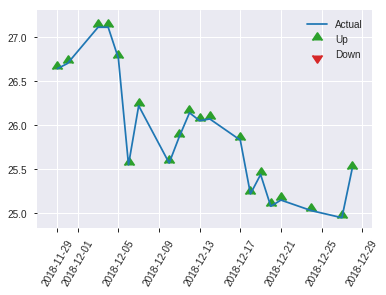


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.257587094717446
RMSE: 0.507530387974401
LogLoss: 0.7096207736301003
Mean Per-Class Error: 0.41920634920634914
AUC: 0.5319365079365079
pr_auc: 0.5133624175470498
Gini: 0.06387301587301586
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2844618558883667: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    123  0.984    (123.0/125.0)
1      0    126  0        (0.0/126.0)
Total  2    249  0.49     (123.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.284462     0.672     248
max f2                       0.284462     0.836653  248
max f0point5                 0.437968     0.594118  180
max accuracy                 0.437968     0.581673  180
max precision                0.820952     1         0
max recall                   0.284462     1         248
max specificity              0.820952     1         0
max absolute_mcc             0.437968     0.18016   180
max min_per_class_accuracy   0.496742     0.531746  124
max mean_per_class_accuracy  0.437968     0.580794  180

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 50.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.744301           1.32804   1.32804            0.666667         0.770412  0.666667                    0.770412            0.015873        0.015873                   32.8042    32.8042
    2        0.0239044                   0.731799           1.32804   1.32804            0.666667         0.735789  0.666667                    0.753101            0.015873        0.031746                   32.8042    32.8042
    3        0.0318725                   0.723778           0         0.996032           0                0.729337  0.5                         0.74716             0               0.031746                   -100       -0.396825
    4        0.0438247                   0.710714           1.32804   1.08658            0.666667         0.715498  0.545455                    0.738525            0.015873        0.047619                   32.8042    8.65801
    5        0.0517928                   0.703155           0.996032  1.07265            0.5              0.706233  0.538462                    0.733557            0.00793651      0.0555556                  -0.396825  7.26496
    6        0.103586                    0.663902           0.612943  0.842796           0.307692         0.685817  0.423077                    0.709687            0.031746        0.0873016                  -38.7057   -15.7204
    7        0.151394                    0.636069           1.16204   0.943609           0.583333         0.647535  0.473684                    0.69006             0.0555556       0.142857                   16.2037    -5.6391
    8        0.203187                    0.617373           0.919414  0.937442           0.461538         0.626849  0.470588                    0.673947            0.047619        0.190476                   -8.05861   -6.25584
    9        0.302789                    0.553503           1.11556   0.996032           0.56             0.584333  0.5                         0.644469            0.111111        0.301587                   11.5556    -0.396825
    10       0.40239                     0.51915            0.95619   0.98617            0.48             0.532603  0.49505                     0.616779            0.0952381       0.396825                   -4.38095   -1.383
    11       0.501992                    0.495498           1.3546    1.05927            0.68             0.507495  0.531746                    0.595096            0.134921        0.531746                   35.4603    5.92719
    12       0.601594                    0.469249           1.03587   1.0554             0.52             0.481342  0.529801                    0.576262            0.103175        0.634921                   3.5873     5.53979
    13       0.701195                    0.442602           1.27492   1.08658            0.64             0.455611  0.545455                    0.559124            0.126984        0.761905                   27.4921    8.65801
    14       0.800797                    0.417754           0.717143  1.04063            0.36             0.430918  0.522388                    0.543178            0.0714286       0.833333                   -28.2857   4.06302
    15       0.900398                    0.37316            0.796825  1.01366            0.4              0.392749  0.50885                     0.526538            0.0793651       0.912698                   -20.3175   1.36606
    16       1                           0.23523            0.876508  1                  0.44             0.335621  0.501992               

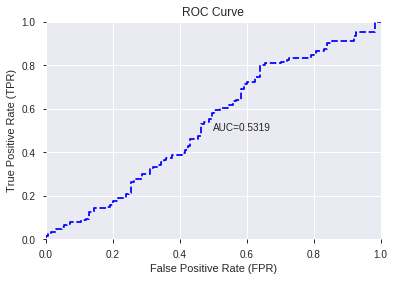

This function is available for GLM models only


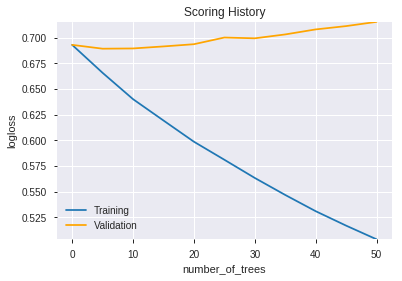

--2019-07-25 00:35:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.160.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.160.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190725_003501',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190725_003501',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_bd2d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_66_sid_bd2d',
   'type

['CORREL_30',
 'BETA_14',
 'DIV',
 'HT_DCPERIOD',
 'Volume',
 'COS',
 'DX_30',
 'ADX_24',
 'ADXR_14',
 'LINEARREG_SLOPE_8',
 'CCI_8',
 'PLUS_DM_12',
 'SAREXT',
 'DX_8',
 'day',
 'BOP',
 'CORREL_20',
 'MINUS_DM_24',
 'WILLR_8',
 'AD',
 'AROONOSC_30',
 'dayofyear',
 'WILLR_14',
 'CCI_14',
 'dayofweek',
 'COSH',
 'LINEARREG_ANGLE_24',
 'BBANDS_upperband_20_0_2',
 'week',
 'AROONOSC_14',
 'aroondown_24',
 'aroonup_24',
 'aroonup_14',
 'aroondown_12',
 'AROONOSC_24',
 'weekday',
 'EXP',
 'month',
 'days_in_month',
 'HT_TRENDMODE',
 'quarter']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [929 939] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_003526_model_3  0.550667  1.006425              0.471968  0.589406  0.347399
1  DeepLearning_grid_1_AutoML_20190725_003526_model_7  0.547429  0.721356              0.500000  0.513504  0.263687
2  DeepLearning_grid_1_AutoML_20190725_003526_model_2  0.546349  1.186884              0.472000  0.609281  0.371223
3               DeepLearning_1_AutoML_20190725_003526  0.521524  0.847018              0.500000  0.557864  0.311213
4  DeepLearning_grid_1_AutoML_20190725_003526_model_9  0.515683  0.694560              0.500000  0.500705  0.250705
5  DeepLearning_grid_1_AutoML_20190725_003526_model_1  0.511937  5.460250              0.488000  0.678915  0.460926
6  DeepLearning_grid_1_AutoML_20190725_003526_model_5  0.500000  0.693486              0.500000  0.500170  0.250170
7  DeepLearning_grid_1_AutoML_20190725_003526_model_8  0.500000  0.697217              0.500000  0.502021  0.252026
8  DeepLearning_grid_1_AutoML_20190725_003526_model_4  0.469270  1.974409              0.500000  0.681345  0.464231
9  DeepLearning_grid_1_AutoML_20190725_003526_model_6  0.433651  0.694706              0.500000  0.500778  0.250779

variable  relative_importance  scaled_importance  percentage
0            CDLSTALLEDPATTERN             1.000000           1.000000    0.003197
1                         TANH             0.989649           0.989649    0.003163
2           CDLMORNINGDOJISTAR             0.930190           0.930190    0.002973
3           CDLEVENINGDOJISTAR             0.922609           0.922609    0.002949
4                          EXP             0.898749           0.898749    0.002873
...                        ...                  ...                ...         ...
1035    BBANDS_upperband_8_5_3             0.235328           0.235328    0.000752
1036  BBANDS_middleband_30_6_3             0.234324           0.234324    0.000749
1037  BBANDS_middleband_24_1_3             0.231298           0.231298    0.000739
1038              CDLTASUKIGAP             0.226453           0.226453    0.000724
1039          CDLCOUNTERATTACK             0.226243           0.226243    0.000723

[1040 rows x 4 columns]

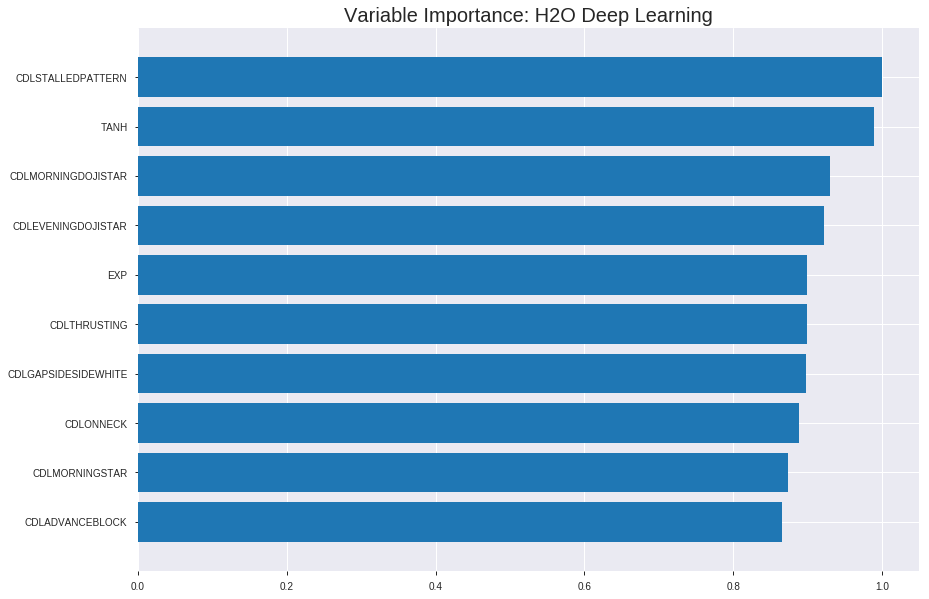

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_003526_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.26343463711306686
RMSE: 0.5132588402678193
LogLoss: 0.7434330343375464
Mean Per-Class Error: 0.42384670948597314
AUC: 0.5952098341239938
pr_auc: 0.6116548374363188
Gini: 0.1904196682479875
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.029494212474218018: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      8    841   0.9906   (841.0/849.0)
1      1    904   0.0011   (1.0/905.0)
Total  9    1745  0.48     (842.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0294942    0.682264  395
max f2                       0.0294942    0.842498  395
max f0point5                 0.374064     0.588633  215
max accuracy                 0.433        0.575257  173
max precision                0.852735     1         0
max recall                   0.0209384    1         397
max specificity              0.852735     1         0
max absolute_mcc             0.496149     0.160781  129
max min_per_class_accuracy   0.423165     0.57126   181
max mean_per_class_accuracy  0.433        0.576153  173

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 40.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.708443           1.6151    1.6151             0.833333         0.766517   0.833333                    0.766517            0.0165746       0.0165746                  61.5101   61.5101
    2        0.0205245                   0.677654           1.50743   1.56126            0.777778         0.693144   0.805556                    0.72983             0.0154696       0.0320442                  50.7428   56.1265
    3        0.0302166                   0.66355            1.5961    1.57244            0.823529         0.668172   0.811321                    0.710053            0.0154696       0.0475138                  59.61     57.2438
    4        0.0404789                   0.6482             1.18441   1.47406            0.611111         0.653989   0.760563                    0.69584             0.0121547       0.0596685                  18.4408   47.4064
    5        0.050171                    0.639387           1.48209   1.47562            0.764706         0.644317   0.761364                    0.685886            0.0143646       0.0740331                  48.2093   47.5615
    6        0.100342                    0.59898            1.25537   1.36549            0.647727         0.619844   0.704545                    0.652865            0.0629834       0.137017                   25.5374   36.5495
    7        0.149943                    0.569152           0.980199  1.23804            0.505747         0.584886   0.638783                    0.630378            0.0486188       0.185635                   -1.98006  23.804
    8        0.200114                    0.546093           1.2774    1.24791            0.659091         0.557177   0.643875                    0.612025            0.0640884       0.249724                   27.7398   24.7907
    9        0.299886                    0.500817           1.22932   1.24172            0.634286         0.522787   0.640684                    0.582336            0.122652        0.372376                   22.9323   24.1724
    10       0.400228                    0.460878           0.969061  1.17336            0.5              0.481451   0.605413                    0.557043            0.0972376       0.469613                   -3.09392  17.3364
    11       0.5                         0.42334            1.0189    1.14254            0.525714         0.442059   0.58951                     0.534098            0.101657        0.571271                   1.88982   14.2541
    12       0.599772                    0.377812           0.919223  1.10539            0.474286         0.401486   0.570342                    0.512038            0.0917127       0.662983                   -8.07766  10.5393
    13       0.700114                    0.324437           0.891976  1.07481            0.460227         0.351011   0.55456                     0.488959            0.0895028       0.752486                   -10.8024  7.48052
    14       0.799886                    0.250322           0.830624  1.04435            0.428571         0.287707   0.538845                    0.463857            0.0828729       0.835359                   -16.9376  4.43477
    15       0.899658                    0.170509           0.786324  1.01573            0.405714         0.211724   0.524081                    0.435895            0.078453        0.913812                   -21.3676  1.57329
    16       1                           0.011578           0.85894   1                  0.443182         0.0999534  0.515964                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2677911945590428
RMSE: 0.5174854534757889
LogLoss: 0.7336115167769247
Mean Per-Class Error: 0.45644997665093956
AUC: 0.5285180592905105
pr_auc: 0.5720642057303236
Gini: 0.05703611858102109
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10282394216962858: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    221  1        (221.0/221.0)
1      0    281  0        (0.0/281.0)
Total  0    502  0.4402   (221.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.102824     0.717752  399
max f2                       0.102824     0.864084  399
max f0point5                 0.354213     0.623335  307
max accuracy                 0.354575     0.577689  306
max precision                0.572758     0.619565  78
max recall                   0.102824     1         399
max specificity              0.822719     0.995475  0
max absolute_mcc             0.354575     0.106311  306
max min_per_class_accuracy   0.450872     0.511312  199
max mean_per_class_accuracy  0.354575     0.54355   306

Gains/Lift Table: Avg response rate: 55.98 %, avg score: 45.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.736451           0.893238  0.893238           0.5              0.767237  0.5                         0.767237            0.0106762       0.0106762                  -10.6762   -10.6762
    2        0.0219124                   0.698611           1.07189   0.974442           0.6              0.709336  0.545455                    0.740918            0.0106762       0.0213523                  7.18861    -2.55581
    3        0.0318725                   0.679805           1.07189   1.00489            0.6              0.691679  0.5625                      0.725531            0.0106762       0.0320285                  7.18861    0.489324
    4        0.0418327                   0.668345           0.714591  0.935774           0.4              0.673156  0.52381                     0.713061            0.00711744      0.0391459                  -28.5409   -6.42264
    5        0.0517928                   0.662988           1.42918   1.03066            0.8              0.666032  0.576923                    0.704017            0.0142349       0.0533808                  42.9181    3.06597
    6        0.101594                    0.608099           1.14335   1.0859             0.64             0.629737  0.607843                    0.667605            0.0569395       0.11032                    14.3345    8.58977
    7        0.151394                    0.58501            0.928968  1.03428            0.52             0.595603  0.578947                    0.64392             0.0462633       0.156584                   -7.1032    3.42761
    8        0.201195                    0.565963           1.2148    1.07896            0.68             0.575109  0.60396                     0.626888            0.0604982       0.217082                   21.4804    7.89613
    9        0.300797                    0.530967           0.893238  1.01746            0.5              0.546051  0.569536                    0.60012             0.088968        0.30605                    -10.6762   1.74636
    10       0.400398                    0.487962           0.964698  1.00434            0.54             0.51014   0.562189                    0.577737            0.0960854       0.402135                   -3.53025   0.433774
    11       0.5                         0.451169           1.07189   1.01779            0.6              0.467319  0.569721                    0.555741            0.106762        0.508897                   7.18861    1.77936
    12       0.599602                    0.418915           1.17907   1.04458            0.66             0.438326  0.584718                    0.536237            0.117438        0.626335                   17.9075    4.45845
    13       0.699203                    0.381182           1.00043   1.03829            0.56             0.399895  0.581197                    0.516815            0.0996441       0.725979                   0.0427046  3.82942
    14       0.798805                    0.351324           1.07189   1.04248            0.6              0.365653  0.583541                    0.497967            0.106762        0.83274                    7.18861    4.24828
    15       0.898406                    0.298424           0.75032   1.01009            0.42             0.324524  0.56541                     0.478738            0.0747331       0.907473                   -24.968    1.00922
    16       1                           0.102824           0.910753  1                  0.509804         0.245486  0.559761               


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 00:41:47  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 00:41:49  6 min 21.735 sec  478 obs/sec       0.518244  1             909        0.661372         3.93134             -0.751436      0.538621        0.439128           1.39975          0.484036                         0.669458           2.79454               -0.818675        0.500861          0.545456             1.19098            0.440239
    2019-07-25 00:42:02  6 min 35.325 sec  523 obs/sec       4.24002   8             7437       0.578495         1.37163             -0.339993      0.598487        0.599766           1.50743          0.484036                         0.637393           2.03259               -0.64863         0.507826          0.568452             1.19098            0.440239
    2019-07-25 00:42:16  6 min 48.684 sec  532 obs/sec       7.96294   15            13967      0.618289         1.64491             -0.530685      0.549122        0.528929           1.83045          0.478905                         0.625772           1.50106               -0.589063        0.511127          0.574191             1.48873            0.440239
    2019-07-25 00:42:30  7 min  3.328 sec  543 obs/sec       12.2617   23            21507      0.566041         1.08477             -0.282916      0.591562        0.601244           1.72277          0.474914                         0.567146           0.981947              -0.305264        0.534879          0.587806             1.19098            0.438247
    2019-07-25 00:42:45  7 min 17.537 sec  550 obs/sec       16.4812   31            28908      0.571704         1.28657             -0.308716      0.58631         0.620204           1.6151           0.484036                         0.572944           0.968074              -0.33209         0.542181          0.600086             0.893238           0.440239
    2019-07-25 00:42:57  7 min 30.247 sec  554 obs/sec       20.2343   38            35491      0.595961         1.209               -0.422128      0.544345        0.581988           1.6151           0.484036                         0.602162           1.15625               -0.471418        0.514154          0.568518             0.893238           0.436255
    2019-07-25 00:43:11  7 min 44.332 sec  560 obs/sec       24.5319   46            43029      0.513259         0.743433            -0.0548138     0.59521         0.611655           1.6151           0.480046                         0.517485           0.733612              -0.0866887       0.528518          0.572064             0.893238           0.440239
    2019-07-25 00:43:25  7 min 58.195 sec  565 obs/sec       28.8033   54            50521      0.554025         0.956847            -0.229027      0.585141        0.606144           1.39975          0.479475                         0.561343           0.86631               -0.278691        0.510306          0.58041              1.78648            0.436255
    2019-07-25 00:43:40

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLSTALLEDPATTERN         1.0                    1.0                  0.0031965735759087615
TANH                      0.9896492958068848     0.9896492958068848   0.003163486788393001
CDLMORNINGDOJISTAR        0.9301896095275879     0.9301896095275879   0.002973419526400776
CDLEVENINGDOJISTAR        0.9226092100143433     0.9226092100143433   0.0029491882216219067
EXP                       0.8987487554550171     0.8987487554550171   0.002872916523068393
---                       ---                    ---                  ---
BBANDS_upperband_8_5_3    0.2353280484676361     0.2353280484676361   0.0007522434214018218
BBANDS_middleband_30_6_3  0.23432433605194092    0.23432433605194092  0.0007490349808159991
BBANDS_middleband_24_1_3  0.23129825294017792    0.23129825294017792  0.0007393618835024338
CDLTASUKIGAP              0.22645314037799835    0.22645314037799835  0.000723874124713867
CDLCOUNTERATTACK          0.22624289989471436    0.22624289989471436  0.000723202075540415


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5657370517928287)

('F1', 0.6793478260869564)

('auc', 0.5506666666666666)

('logloss', 1.0064246577957172)

('mean_per_class_error', 0.4331746031746032)

('rmse', 0.5894055742867773)

('mse', 0.3473989310003258)

deeplearning prediction progress: |███████████████████████████████████████| 100%


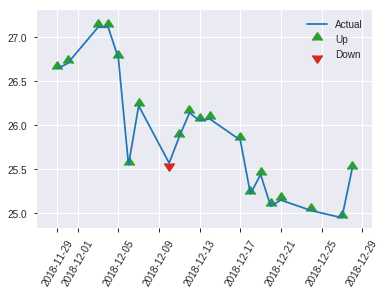


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3473989310003258
RMSE: 0.5894055742867773
LogLoss: 1.0064246577957172
Mean Per-Class Error: 0.4331746031746032
AUC: 0.5506666666666666
pr_auc: 0.54274154742097
Gini: 0.10133333333333328
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0399075207820418: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    117  0.936    (117.0/125.0)
1      1    125  0.0079   (1.0/126.0)
Total  9    242  0.4701   (118.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0399075    0.679348  241
max f2                       0.0272779    0.84      245
max f0point5                 0.0399075    0.571298  241
max accuracy                 0.28006      0.565737  56
max precision                0.66389      1         0
max recall                   0.0272779    1         245
max specificity              0.66389      1         0
max absolute_mcc             0.28006      0.159505  56
max min_per_class_accuracy   0.172313     0.528     125
max mean_per_class_accuracy  0.28006      0.566825  56

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 19.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.597233           0.664021  0.664021           0.333333         0.634049   0.333333                    0.634049            0.00793651      0.00793651                 -33.5979  -33.5979
    2        0.0239044                   0.550735           0.664021  0.664021           0.333333         0.56909    0.333333                    0.601569            0.00793651      0.015873                   -33.5979  -33.5979
    3        0.0318725                   0.539003           1.99206   0.996032           1                0.543437   0.5                         0.587036            0.015873        0.031746                   99.2063   -0.396825
    4        0.0438247                   0.523089           1.32804   1.08658            0.666667         0.529656   0.545455                    0.571387            0.015873        0.047619                   32.8042   8.65801
    5        0.0517928                   0.488342           1.99206   1.22589            1                0.505507   0.615385                    0.561252            0.015873        0.0634921                  99.2063   22.5885
    6        0.103586                    0.390191           1.07265   1.14927            0.538462         0.428297   0.576923                    0.494774            0.0555556       0.119048                   7.26496   14.9267
    7        0.151394                    0.345227           1.16204   1.1533             0.583333         0.364283   0.578947                    0.453567            0.0555556       0.174603                   16.2037   15.33
    8        0.203187                    0.294399           1.53236   1.24992            0.769231         0.317488   0.627451                    0.41888             0.0793651       0.253968                   53.2357   24.9922
    9        0.302789                    0.244615           1.03587   1.17951            0.52             0.262971   0.592105                    0.367594            0.103175        0.357143                   3.5873    17.9511
    10       0.40239                     0.206032           0.876508  1.10451            0.44             0.226341   0.554455                    0.332631            0.0873016       0.444444                   -12.3492  10.451
    11       0.501992                    0.172313           0.876508  1.05927            0.44             0.189365   0.531746                    0.304205            0.0873016       0.531746                   -12.3492  5.92719
    12       0.601594                    0.12222            0.717143  1.00263            0.36             0.14655    0.503311                    0.278103            0.0714286       0.603175                   -28.2857  0.262798
    13       0.701195                    0.105419           0.876508  0.984713           0.44             0.112448   0.494318                    0.254573            0.0873016       0.690476                   -12.3492  -1.52868
    14       0.800797                    0.084188           1.3546    1.03072            0.68             0.0952236  0.517413                    0.234753            0.134921        0.825397                   35.4603   3.07194
    15       0.900398                    0.0583606          1.03587   1.03129            0.52             0.068777   0.517699                    0.216393            0.103175        0.928571                   3.5873    3.12895
    16       1                           0.017135           0.717143  1                  0.36             0.0417404  0.501992                

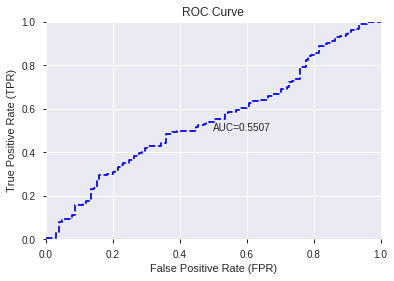

This function is available for GLM models only


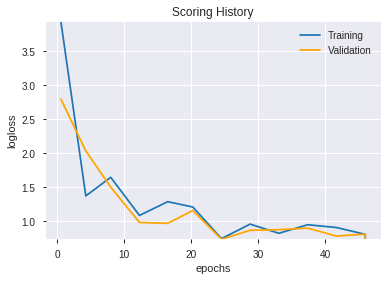

['CDLSTALLEDPATTERN',
 'TANH',
 'CDLMORNINGDOJISTAR',
 'CDLEVENINGDOJISTAR',
 'EXP',
 'CDLTHRUSTING',
 'CDLGAPSIDESIDEWHITE',
 'CDLONNECK',
 'CDLMORNINGSTAR',
 'CDLADVANCEBLOCK',
 'SINH',
 'CDLPIERCING',
 'COSH',
 'CDLGRAVESTONEDOJI',
 'CDLEVENINGSTAR',
 'CDL2CROWS',
 'CDLHIKKAKEMOD',
 'CDLSHOOTINGSTAR',
 'CDLLADDERBOTTOM',
 'CDLSTICKSANDWICH',
 'CDLSEPARATINGLINES',
 'CDL3WHITESOLDIERS',
 'CDLHOMINGPIGEON',
 'CDLBREAKAWAY',
 'is_quarter_start',
 'is_quarter_end',
 'CDLDARKCLOUDCOVER',
 'CDLHANGINGMAN',
 'CDLHAMMER',
 'CDLTAKURI',
 'CDLINVERTEDHAMMER',
 'CDLDRAGONFLYDOJI',
 'CDLMATCHINGLOW',
 'is_month_start',
 'CDLRICKSHAWMAN',
 'is_month_end',
 'CDLXSIDEGAP3METHODS',
 'weekday',
 'SAREXT',
 'day',
 'days_in_month',
 'dayofweek',
 'CDLDOJI',
 'HT_TRENDMODE',
 'CORREL_8',
 'aroondown_30',
 'AROONOSC_14',
 'STOCHRSI_fastk',
 'COS',
 'quarter',
 'VAR_12',
 'week',
 'BETA_30',
 'SIN',
 'CDLLONGLEGGEDDOJI',
 'aroondown_14',
 'VAR_8',
 'aroonup_14',
 'CORREL_20',
 'dayofyear',
 'aroondown_1

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_010609_model_1  0.534159  0.691169                 0.484  0.499012  0.249013

variable  relative_importance  scaled_importance    percentage
0                 CDL3OUTSIDE         8.819562e-03           1.000000  1.254561e-02
1                   dayofweek         7.856618e-03           0.890817  1.117585e-02
2                     weekday         7.841413e-03           0.889093  1.115422e-02
3              CDLHARAMICROSS         7.374836e-03           0.836191  1.049053e-02
4               CDLHANGINGMAN         7.086347e-03           0.803481  1.008016e-02
...                       ...                  ...                ...           ...
1035   BBANDS_upperband_8_0_2         1.186261e-06           0.000135  1.687428e-06
1036  BBANDS_lowerband_12_7_4         7.221892e-07           0.000082  1.027297e-06
1037                     High         5.532559e-07           0.000063  7.869932e-07
1038  BBANDS_lowerband_24_0_3         4.180975e-07           0.000047  5.947337e-07
1039                   KAMA_8         9.997071e-08           0.000011  1.422059e-07

[1040 rows x 4 columns]

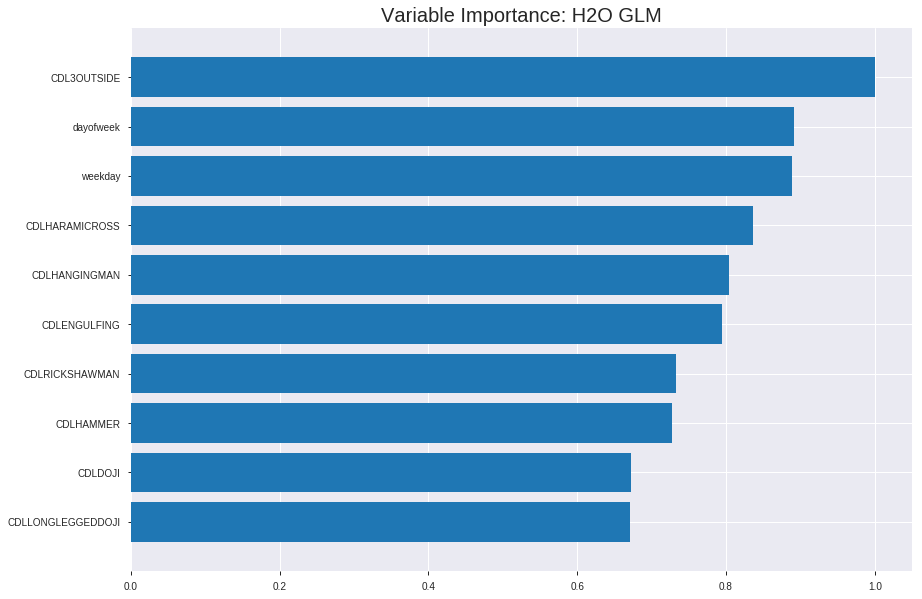

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_010609_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24621368968196664
RMSE: 0.4961992439353033
LogLoss: 0.6855465583602182
Null degrees of freedom: 1753
Residual degrees of freedom: 713
Null deviance: 2429.7720921923756
Residual deviance: 2404.897326727645
AIC: 4486.897326727645
AUC: 0.5862483649922886
pr_auc: 0.5925617139794954
Gini: 0.1724967299845772
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4385128367220911: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      3    846   0.9965   (846.0/849.0)
1      0    905   0        (0.0/905.0)
Total  3    1751  0.4823   (846.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.438513     0.681476  397
max f2                       0.438513     0.842487  397
max f0point5                 0.494327     0.59184   284
max accuracy                 0.509163     0.570125  231
max precision                0.619811     1         0
max recall                   0.438513     1         397
max specificity              0.619811     1         0
max absolute_mcc             0.500897     0.137936  260
max min_per_class_accuracy   0.517184     0.559116  202
max mean_per_class_accuracy  0.509163     0.567209  231

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 51.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.583961           1.39975   1.39975            0.722222         0.595236  0.722222                    0.595236            0.0143646       0.0143646                  39.9754   39.9754
    2        0.0205245                   0.575294           1.29208   1.34592            0.666667         0.578654  0.694444                    0.586945            0.0132597       0.0276243                  29.2081   34.5918
    3        0.0302166                   0.570531           1.25408   1.31646            0.647059         0.57235   0.679245                    0.582264            0.0121547       0.039779                   25.4079   31.646
    4        0.0404789                   0.56582            1.39975   1.33758            0.722222         0.568162  0.690141                    0.578689            0.0143646       0.0541436                  39.9754   33.7577
    5        0.050171                    0.561236           1.48209   1.36549            0.764706         0.563427  0.704545                    0.57574             0.0143646       0.0685083                  48.2093   36.5495
    6        0.100342                    0.551443           1.1893    1.2774             0.613636         0.555959  0.659091                    0.56585             0.0596685       0.128177                   18.9302   27.7398
    7        0.149943                    0.545503           1.18069   1.24541            0.609195         0.548253  0.642586                    0.560029            0.0585635       0.18674                    18.0695   24.5409
    8        0.200114                    0.540672           1.12323   1.21478            0.579545         0.543115  0.626781                    0.555788            0.0563536       0.243094                   12.323    21.4777
    9        0.299886                    0.53213            1.0632    1.16435            0.548571         0.536281  0.60076                     0.549298            0.106077        0.349171                   6.31981   16.4347
    10       0.400228                    0.524929           1.02412   1.12919            0.528409         0.52863   0.582621                    0.544117            0.102762        0.451934                   2.4121    12.919
    11       0.5                         0.517134           1.07427   1.11823            0.554286         0.52113   0.576967                    0.53953             0.107182        0.559116                   7.42731   11.8232
    12       0.599772                    0.508265           1.05212   1.10723            0.542857         0.512571  0.571293                    0.535045            0.104972        0.664088                   5.21231   10.7235
    13       0.700114                    0.498987           0.914001  1.07954            0.471591         0.503514  0.557003                    0.530526            0.0917127       0.755801                   -8.59995  7.954
    14       0.799886                    0.489636           0.885998  1.0554             0.457143         0.494378  0.544547                    0.526017            0.0883978       0.844199                   -11.4002  5.5399
    15       0.899658                    0.479894           0.786324  1.02556            0.405714         0.48474   0.529151                    0.52144             0.078453        0.922652                   -21.3676  2.55586
    16       1                           0.420423           0.770844  1                  0.397727         0.466865  0.515964                    0.515964            0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24751307876267042
RMSE: 0.49750686303072283
LogLoss: 0.6881577629348479
Null degrees of freedom: 501
Residual degrees of freedom: -539
Null deviance: 692.5991909148838
Residual deviance: 690.9103939865872
AIC: 2772.910393986587
AUC: 0.5335260301766477
pr_auc: 0.5834325725174789
Gini: 0.06705206035329536
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4691863446566106: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    214  0.9683   (214.0/221.0)
1      3    278  0.0107   (3.0/281.0)
Total  10   492  0.4323   (217.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.469186     0.719276   390
max f2                       0.451027     0.864084   399
max f0point5                 0.485938     0.619875   351
max accuracy                 0.487745     0.571713   345
max precision                0.617851     1          0
max recall                   0.451027     1          399
max specificity              0.617851     1          0
max absolute_mcc             0.531977     0.0899135  108
max min_per_class_accuracy   0.515632     0.520362   201
max mean_per_class_accuracy  0.531977     0.539573   108

Gains/Lift Table: Avg response rate: 55.98 %, avg score: 51.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.579426           1.19098   1.19098            0.666667         0.591232  0.666667                    0.591232            0.0142349       0.0142349                  19.0985    19.0985
    2        0.0219124                   0.571448           0.357295  0.812035           0.2              0.575486  0.454545                    0.584074            0.00355872      0.0177936                  -64.2705   -18.7965
    3        0.0318725                   0.562075           1.07189   0.893238           0.6              0.567722  0.5                         0.578964            0.0106762       0.0284698                  7.18861    -10.6762
    4        0.0418327                   0.559402           1.42918   1.02084            0.8              0.560421  0.571429                    0.574549            0.0142349       0.0427046                  42.9181    2.08439
    5        0.0517928                   0.556882           1.78648   1.16808            1                0.557373  0.653846                    0.571246            0.0177936       0.0604982                  78.6477    16.8081
    6        0.101594                    0.547321           0.857509  1.01584            0.48             0.550962  0.568627                    0.561303            0.0427046       0.103203                   -14.2491   1.58398
    7        0.151394                    0.539807           0.928968  0.987264           0.52             0.543011  0.552632                    0.555286            0.0462633       0.149466                   -7.1032    -1.27365
    8        0.201195                    0.53656            1.35772   1.07896            0.76             0.53809   0.60396                     0.551029            0.0676157       0.217082                   35.7722    7.89613
    9        0.300797                    0.52775            1.00043   1.05296            0.56             0.532368  0.589404                    0.54485             0.0996441       0.316726                   0.0427046  5.29566
    10       0.400398                    0.521357           0.928968  1.02211            0.52             0.524622  0.572139                    0.539818            0.0925267       0.409253                   -7.1032    2.21136
    11       0.5                         0.515795           1.07189   1.03203            0.6              0.518254  0.577689                    0.535523            0.106762        0.516014                   7.18861    3.20285
    12       0.599602                    0.507724           1.03616   1.03271            0.58             0.511418  0.578073                    0.531519            0.103203        0.619217                   3.61566    3.27142
    13       0.699203                    0.500866           1.00043   1.02811            0.56             0.504092  0.575499                    0.527612            0.0996441       0.718861                   0.0427046  2.81149
    14       0.798805                    0.493554           0.964698  1.02021            0.54             0.49762   0.571072                    0.523872            0.0960854       0.814947                   -3.53025   2.02075
    15       0.898406                    0.483476           1.00043   1.01801            0.56             0.489744  0.569845                    0.520089            0.0996441       0.914591                   0.0427046  1.80145
    16       1                           0.451027           0.840695  1                  0.470588         0.474099  0.559761                 


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 01:06:12  0.000 sec   2            3.2       1041          1.37109           1.37632
    2019-07-25 01:06:14  2.055 sec   4            2.3       1041          1.36802           1.37693
    2019-07-25 01:06:16  4.045 sec   6            1.7       1041          1.36441           1.37782
    2019-07-25 01:06:18  6.077 sec   8            1.2       1041          1.36023           1.37909
    2019-07-25 01:06:20  8.127 sec   10           0.89      1041          1.35553           1.38082
    2019-07-25 01:06:22  10.158 sec  12           0.65      1041          1.35036           1.38314

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5617529880478087)

('F1', 0.675603217158177)

('auc', 0.5341587301587302)

('logloss', 0.6911689628142269)

('mean_per_class_error', 0.4378412698412698)

('rmse', 0.49901155448825624)

('mse', 0.2490125315127859)

glm prediction progress: |████████████████████████████████████████████████| 100%


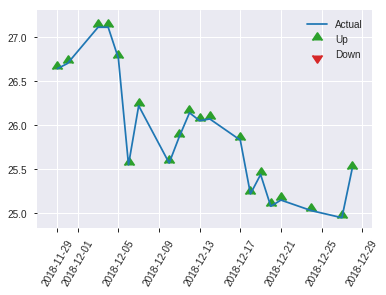


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2490125315127859
RMSE: 0.49901155448825624
LogLoss: 0.6911689628142269
Null degrees of freedom: 250
Residual degrees of freedom: -790
Null deviance: 348.1519924217104
Residual deviance: 346.966819332742
AIC: 2428.966819332742
AUC: 0.5341587301587302
pr_auc: 0.5404631330801228
Gini: 0.06831746031746033
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4293701108287725: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    121  0.968    (121.0/125.0)
1      0    126  0        (0.0/126.0)
Total  4    247  0.4821   (121.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.42937      0.675603  246
max f2                       0.42937      0.838881  246
max f0point5                 0.42937      0.56553   246
max accuracy                 0.497952     0.561753  99
max precision                0.565476     1         0
max recall                   0.42937      1         246
max specificity              0.565476     1         0
max absolute_mcc             0.42937      0.127765  246
max min_per_class_accuracy   0.490681     0.515873  124
max mean_per_class_accuracy  0.497952     0.562159  99

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 48.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.555761           1.32804   1.32804            0.666667         0.56057   0.666667                    0.56057             0.015873        0.015873                   32.8042   32.8042
    2        0.0239044                   0.549071           0.664021  0.996032           0.333333         0.551046  0.5                         0.555808            0.00793651      0.0238095                  -33.5979  -0.396825
    3        0.0318725                   0.544101           0         0.747024           0                0.546498  0.375                       0.55348             0               0.0238095                  -100      -25.2976
    4        0.0438247                   0.541889           1.32804   0.905483           0.666667         0.542575  0.454545                    0.550506            0.015873        0.0396825                  32.8042   -9.45166
    5        0.0517928                   0.539496           1.99206   1.07265            1                0.5414    0.538462                    0.549105            0.015873        0.0555556                  99.2063   7.26496
    6        0.103586                    0.528089           1.37912   1.22589            0.692308         0.533545  0.615385                    0.541325            0.0714286       0.126984                   37.9121   22.5885
    7        0.151394                    0.51953            1.32804   1.25815            0.666667         0.52251   0.631579                    0.535383            0.0634921       0.190476                   32.8042   25.8145
    8        0.203187                    0.515364           1.07265   1.21086            0.538462         0.517169  0.607843                    0.53074             0.0555556       0.246032                   7.26496   21.0862
    9        0.302789                    0.506452           0.95619   1.12709            0.48             0.510974  0.565789                    0.524238            0.0952381       0.34127                    -4.38095  12.7089
    10       0.40239                     0.497927           1.19524   1.14396            0.6              0.501284  0.574257                    0.518557            0.119048        0.460317                   19.5238   14.3957
    11       0.501992                    0.490658           0.557778  1.02765            0.28             0.493673  0.515873                    0.513619            0.0555556       0.515873                   -44.2222  2.76518
    12       0.601594                    0.47967            0.95619   1.01582            0.48             0.483781  0.509934                    0.508679            0.0952381       0.611111                   -4.38095  1.58205
    13       0.701195                    0.470588           1.03587   1.01867            0.52             0.475361  0.511364                    0.503947            0.103175        0.714286                   3.5873    1.86688
    14       0.800797                    0.463928           0.63746   0.971255           0.32             0.466813  0.487562                    0.499328            0.0634921       0.777778                   -36.254   -2.87452
    15       0.900398                    0.452805           1.27492   1.00485            0.64             0.458688  0.504425                    0.494833            0.126984        0.904762                   27.4921   0.484619
    16       1                           0.421351           0.95619   1                  0.48             0.442149  0.501992                    0.489585   

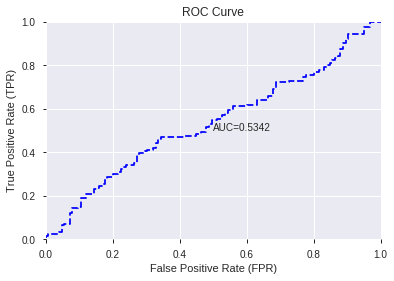

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


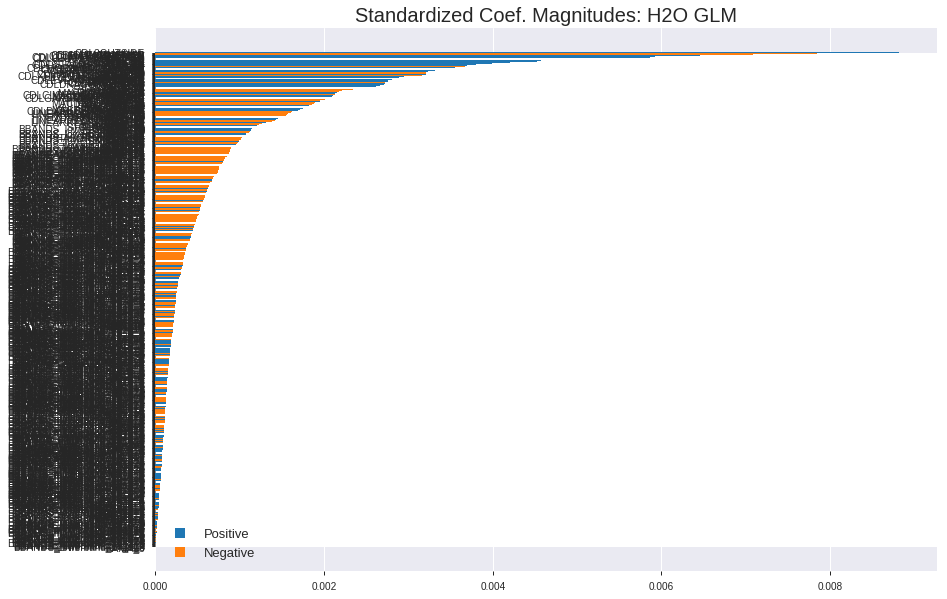

'log_likelihood'
--2019-07-25 01:06:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.21.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.21.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_010609_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_010609_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_bd2d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDL3OUTSIDE',
 'dayofweek',
 'weekday',
 'CDLHARAMICROSS',
 'CDLHANGINGMAN',
 'CDLENGULFING',
 'CDLRICKSHAWMAN',
 'CDLHAMMER',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'CORREL_20',
 'CDLGRAVESTONEDOJI',
 'CDLTASUKIGAP',
 'is_quarter_end',
 'CORREL_14',
 'CCI_12',
 'OBV',
 'day',
 'aroondown_30',
 'ADX_24',
 'CORREL_12',
 'CCI_14',
 'CDLSTALLEDPATTERN',
 'ADX_20',
 'BETA_14',
 'CDLSEPARATINGLINES',
 'MFI_12',
 'MFI_14',
 'AROONOSC_30',
 'TRANGE',
 'CDLDOJISTAR',
 'CDLMORNINGDOJISTAR',
 'DIV',
 'CDLBREAKAWAY',
 'CDLLADDERBOTTOM',
 'CDLEVENINGSTAR',
 'SUB',
 'BOP',
 'CCI_8',
 'CDLMORNINGSTAR',
 'ADXR_14',
 'ROC_30',
 'ROCP_30',
 'CDL3WHITESOLDIERS',
 'ROCR_30',
 'ROCR100_30',
 'WILLR_14',
 'MOM_30',
 'CDLXSIDEGAP3METHODS',
 'CDL2CROWS',
 'MFI_24',
 'HT_PHASOR_inphase',
 'CCI_20',
 'CDLHIKKAKEMOD',
 'WILLR_12',
 'CDLBELTHOLD',
 'MINUS_DI_8',
 'CDLEVENINGDOJISTAR',
 'CDLHIKKAKE',
 'COS',
 'CDLSHORTLINE',
 'CDLHARAMI',
 'WILLR_20',
 'CDLMARUBOZU',
 'DX_8',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'ST

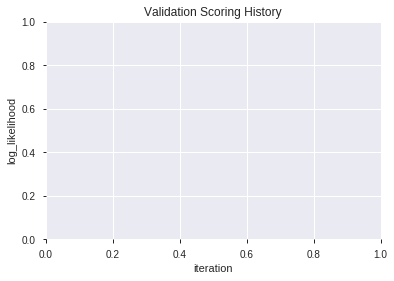

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_010654_model_4  0.529143  0.695288              0.447683  0.501000  0.251001
1  XGBoost_grid_1_AutoML_20190725_010654_model_7  0.514349  0.720153              0.488000  0.511983  0.262127
2  XGBoost_grid_1_AutoML_20190725_010654_model_6  0.505079  0.714219              0.492000  0.509692  0.259785
3  XGBoost_grid_1_AutoML_20190725_010654_model_3  0.496000  0.724110              0.496000  0.513790  0.263980
4  XGBoost_grid_1_AutoML_20190725_010654_model_5  0.461651  0.792255              0.500000  0.540122  0.291732
5               XGBoost_1_AutoML_20190725_010654  0.461206  0.737173              0.471937  0.520428  0.270845
6               XGBoost_3_AutoML_20190725_010654  0.461143  0.734535              0.496000  0.518738  0.269090
7  XGBoost_grid_1_AutoML_20190725_010654_model_1  0.457333  0.732072              0.496000  0.517531  0.267839
8  XGBoost_grid_1_AutoML_20190725_010654_model_2  0.452952  0.714367              0.500000  0.510324  0.260431
9               XGBoost_2_AutoML_20190725_010654  0.451556  0.720016              0.471937  0.513029  0.263199

variable  relative_importance  scaled_importance  percentage
0                MINUS_DI_30           115.782219           1.000000    0.032677
1                        DIV            70.743568           0.611005    0.019966
2                     ADX_24            67.627892           0.584096    0.019087
3                     ROC_24            65.392548           0.564789    0.018456
4                  dayofweek            62.880432           0.543092    0.017747
..                       ...                  ...                ...         ...
178               PLUS_DI_14             5.921960           0.051147    0.001671
179   BBANDS_lowerband_8_3_5             5.594167           0.048316    0.001579
180   LINEARREG_INTERCEPT_14             5.465542           0.047205    0.001543
181        MACDFIX_signal_14             5.060157           0.043704    0.001428
182  BBANDS_lowerband_14_6_2             4.329650           0.037395    0.001222

[183 rows x 4 columns]

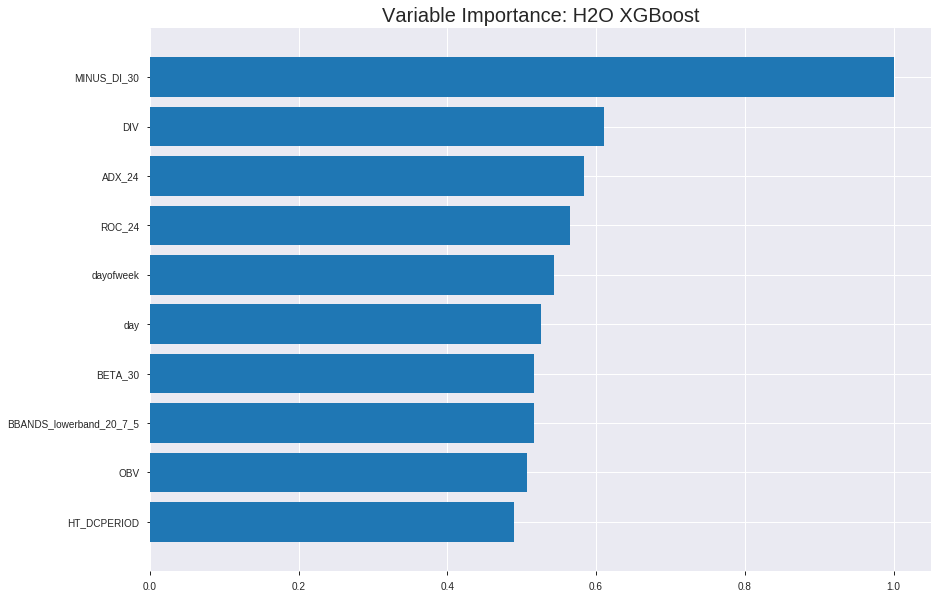

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_010654_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.20926854168079745
RMSE: 0.4574587868658743
LogLoss: 0.6100059764582398
Mean Per-Class Error: 0.23022600524503967
AUC: 0.8363248280394875
pr_auc: 0.8391388803512069
Gini: 0.672649656078975
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5024082586169243: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      626  223  0.2627   (223.0/849.0)
1      179  726  0.1978   (179.0/905.0)
Total  805  949  0.2292   (402.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.502408     0.783172  220
max f2                       0.407556     0.861704  339
max f0point5                 0.51264      0.781072  207
max accuracy                 0.502408     0.77081   220
max precision                0.767247     1         0
max recall                   0.341136     1         389
max specificity              0.767247     1         0
max absolute_mcc             0.502408     0.5411    220
max min_per_class_accuracy   0.510575     0.763536  210
max mean_per_class_accuracy  0.502408     0.769774  220

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 51.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.705467           1.83045   1.83045            0.944444         0.72333   0.944444                    0.72333             0.0187845       0.0187845                  83.0448   83.0448
    2        0.0205245                   0.694861           1.93812   1.88428            1                0.699159  0.972222                    0.711244            0.0198895       0.038674                   93.8122   88.4285
    3        0.0302166                   0.679132           1.93812   1.90155            1                0.687374  0.981132                    0.703588            0.0187845       0.0574586                  93.8122   90.1553
    4        0.0404789                   0.671845           1.83045   1.88353            0.944444         0.675173  0.971831                    0.696384            0.0187845       0.0762431                  83.0448   88.3527
    5        0.050171                    0.66447            1.93812   1.89407            1                0.668862  0.977273                    0.691067            0.0187845       0.0950276                  93.8122   89.4073
    6        0.100342                    0.626389           1.78395   1.83901            0.920455         0.644354  0.948864                    0.667711            0.0895028       0.18453                    78.3953   83.9013
    7        0.149943                    0.604759           1.62624   1.76863            0.83908          0.615025  0.912548                    0.650282            0.080663        0.265193                   62.624    76.8628
    8        0.200114                    0.586571           1.62978   1.73382            0.840909         0.594347  0.894587                    0.636259            0.081768        0.346961                   62.9784   73.3818
    9        0.299886                    0.556553           1.53942   1.66914            0.794286         0.570443  0.861217                    0.614362            0.153591        0.500552                   53.9422   66.9143
    10       0.400228                    0.532969           1.29942   1.57645            0.670455         0.544071  0.81339                     0.596739            0.130387        0.630939                   29.9422   57.6449
    11       0.5                         0.511195           1.29577   1.52044            0.668571         0.521376  0.784493                    0.581701            0.129282        0.760221                   29.5773   52.0442
    12       0.599772                    0.488691           0.852773  1.40938            0.44             0.499822  0.727186                    0.56808             0.0850829       0.845304                   -14.7227  40.9375
    13       0.700114                    0.465876           0.638699  1.29892            0.329545         0.476425  0.670195                    0.554944            0.0640884       0.909392                   -36.1301  29.892
    14       0.799886                    0.43956            0.409774  1.18801            0.211429         0.453245  0.612972                    0.542259            0.040884        0.950276                   -59.0226  18.8015
    15       0.899658                    0.407342           0.387624  1.09925            0.2              0.424224  0.567174                    0.529169            0.038674        0.98895                    -61.2376  9.92514
    16       1                           0.277358           0.110121  1                  0.0568182        0.378346  0.515964                    0.514035          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2504999435473915
RMSE: 0.5004996938534444
LogLoss: 0.6942054415287555
Mean Per-Class Error: 0.4682855348545112
AUC: 0.5203297853496723
pr_auc: 0.58093037970286
Gini: 0.04065957069934467
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3784940838813782: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    221  1        (221.0/221.0)
1      0    281  0        (0.0/281.0)
Total  0    502  0.4402   (221.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.378494     0.717752   399
max f2                       0.378494     0.864084   399
max f0point5                 0.389812     0.615862   393
max accuracy                 0.389812     0.563745   393
max precision                0.695163     1          0
max recall                   0.378494     1          399
max specificity              0.695163     1          0
max absolute_mcc             0.612793     0.0907651  46
max min_per_class_accuracy   0.525656     0.516014   201
max mean_per_class_accuracy  0.543408     0.531714   158

Gains/Lift Table: Avg response rate: 55.98 %, avg score: 52.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.657881           0.595492  0.595492           0.333333         0.672955  0.333333                    0.672955            0.00711744      0.00711744                 -40.4508   -40.4508
    2        0.0219124                   0.642585           1.78648   1.13685            1                0.649673  0.636364                    0.662372            0.0177936       0.024911                   78.6477    13.6849
    3        0.0318725                   0.639483           1.07189   1.11655            0.6              0.640433  0.625                       0.655516            0.0106762       0.0355872                  7.18861    11.6548
    4        0.0418327                   0.634772           1.42918   1.19098            0.8              0.6372    0.666667                    0.651155            0.0142349       0.0498221                  42.9181    19.0985
    5        0.0517928                   0.631927           0.714591  1.09937            0.4              0.633043  0.615385                    0.647672            0.00711744      0.0569395                  -28.5409   9.93704
    6        0.101594                    0.613081           1.35772   1.22601            0.76             0.621832  0.686275                    0.635005            0.0676157       0.124555                   35.7722    22.6014
    7        0.151394                    0.597517           0.78605   1.08129            0.44             0.60542   0.605263                    0.625273            0.0391459       0.163701                   -21.395    8.12886
    8        0.201195                    0.585544           1.00043   1.06127            0.56             0.59218   0.594059                    0.617082            0.0498221       0.213523                   0.0427046  6.12734
    9        0.300797                    0.564013           1.00043   1.04113            0.56             0.57483   0.582781                    0.603091            0.0996441       0.313167                   0.0427046  4.11256
    10       0.400398                    0.542114           1.10762   1.05767            0.62             0.551349  0.59204                     0.59022             0.11032         0.423488                   10.7616    5.76654
    11       0.5                         0.525575           0.928968  1.03203            0.52             0.533119  0.577689                    0.578845            0.0925267       0.516014                   -7.1032    3.20285
    12       0.599602                    0.505603           1.00043   1.02678            0.56             0.516233  0.574751                    0.568445            0.0996441       0.615658                   0.0427046  2.67791
    13       0.699203                    0.471516           0.857509  1.00267            0.48             0.489014  0.561254                    0.55713             0.0854093       0.701068                   -14.2491   0.26665
    14       0.798805                    0.449942           0.821779  0.980112           0.46             0.460752  0.548628                    0.545113            0.0818505       0.782918                   -17.8221   -1.9888
    15       0.898406                    0.425902           1.14335   0.998209           0.64             0.437557  0.558758                    0.533188            0.113879        0.896797                   14.3345    -0.17912
    16       1                           0.378494           1.01584   1                  0.568627         0.40799   0.559761                  


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 01:07:19  10.448 sec  0                  0.5              0.693147            0.5             0                  1                0.484036                         0.5                0.693147              0.5               0                    1                  0.440239
    2019-07-25 01:07:20  11.231 sec  5                  0.49376          0.680728            0.693155        0.697992           1.83612          0.405929                         0.497503           0.688158              0.56698           0.615004             1.38948            0.426295
    2019-07-25 01:07:20  11.560 sec  10                 0.488461         0.670254            0.723719        0.725582           1.6151           0.366591                         0.497772           0.68868               0.536449          0.59683              1.19098            0.436255
    2019-07-25 01:07:20  11.887 sec  15                 0.483811         0.661108            0.746266        0.748432           1.83045          0.350627                         0.49851            0.690154              0.52888           0.586392             1.19098            0.438247
    2019-07-25 01:07:21  12.226 sec  20                 0.479431         0.652519            0.760917        0.768624           1.83045          0.326682                         0.49807            0.689254              0.531119          0.600612             0.893238           0.440239
    2019-07-25 01:07:21  12.559 sec  25                 0.475502         0.644829            0.773969        0.781817           1.83045          0.328962                         0.497713           0.688547              0.53194           0.595046             0.595492           0.438247
    2019-07-25 01:07:21  12.883 sec  30                 0.472279         0.638538            0.783017        0.788259           1.83045          0.315279                         0.498863           0.690889              0.523462          0.580689             0.297746           0.430279
    2019-07-25 01:07:22  13.222 sec  35                 0.468504         0.631207            0.796237        0.797422           1.83045          0.290764                         0.499917           0.693013              0.515555          0.574945             0.297746           0.440239
    2019-07-25 01:07:22  13.567 sec  40                 0.46533          0.625063            0.807111        0.808906           1.83045          0.281642                         0.500578           0.694346              0.511997          0.572436             0.595492           0.440239
    2019-07-25 01:07:22  13.905 sec  45                 0.461866         0.61843             0.823817        0.822407           1.83045          0.259407                         0.501144           0.69555               0.511618          0.567586             0.297746           0.434263
    2019-07-25 01:07:23  14.272 sec  50                 0.457459         0.610006            0.836325        0.839139           1.83045          0.22919                          0.5005             0.694205              0.52033           0.58093              0.595492           0.440239

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
MINUS_DI_30              115.78221893310547     1.0                   0.03267702524942933
DIV                      70.74356842041016      0.6110054641575239    0.019965840979814697
ADX_24                   67.62789154052734      0.584095659624559     0.019086508617633797
ROC_24                   65.39254760742188      0.5647892069265246    0.01845563117534321
dayofweek                62.88043212890625      0.5430923047453095    0.017746640954933245
---                      ---                    ---                   ---
PLUS_DI_14               5.921960353851318      0.05114740767986836   0.0016713451321979142
BBANDS_lowerband_8_3_5   5.5941667556762695     0.048316285585339874  0.0015788324840307897
LINEARREG_INTERCEPT_14   5.465542316436768      0.04720536855140554   0.001542531020062896
MACDFIX_signal_14        5.06015682220459       0.043704092639027366  0.0014281197386688958
BBANDS_lowerband_14_6_2  4.329649925231934      0.03739477412963937   0.0012219499784309324


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5537848605577689)

('F1', 0.6744186046511628)

('auc', 0.5291428571428571)

('logloss', 0.6952882248033614)

('mean_per_class_error', 0.4476825396825397)

('rmse', 0.5010003425620663)

('mse', 0.2510013432473077)

xgboost prediction progress: |████████████████████████████████████████████| 100%


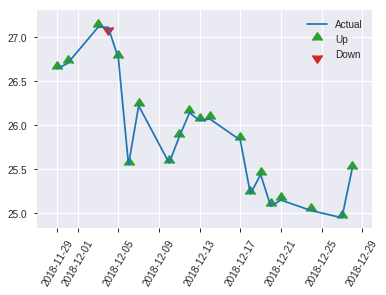


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2510013432473077
RMSE: 0.5010003425620663
LogLoss: 0.6952882248033614
Mean Per-Class Error: 0.4476825396825397
AUC: 0.5291428571428571
pr_auc: 0.5133374592122055
Gini: 0.058285714285714274
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42935603857040405: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      23   102  0.816    (102.0/125.0)
1      10   116  0.0794   (10.0/126.0)
Total  33   218  0.4462   (112.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.429356     0.674419  217
max f2                       0.349678     0.834437  250
max f0point5                 0.429356     0.581162  217
max accuracy                 0.429356     0.553785  217
max precision                0.70306      1         0
max recall                   0.349678     1         250
max specificity              0.70306      1         0
max absolute_mcc             0.429356     0.154822  217
max min_per_class_accuracy   0.47936      0.52      125
max mean_per_class_accuracy  0.429356     0.552317  217

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 48.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.682919           0.664021  0.664021           0.333333         0.693421  0.333333                    0.693421            0.00793651      0.00793651                 -33.5979   -33.5979
    2        0.0239044                   0.663458           0.664021  0.664021           0.333333         0.669238  0.333333                    0.68133             0.00793651      0.015873                   -33.5979   -33.5979
    3        0.0318725                   0.641059           1.99206   0.996032           1                0.652133  0.5                         0.67403             0.015873        0.031746                   99.2063    -0.396825
    4        0.0438247                   0.619651           1.32804   1.08658            0.666667         0.624673  0.545455                    0.660569            0.015873        0.047619                   32.8042    8.65801
    5        0.0517928                   0.612974           0.996032  1.07265            0.5              0.613872  0.538462                    0.653385            0.00793651      0.0555556                  -0.396825  7.26496
    6        0.103586                    0.57768            1.07265   1.07265            0.538462         0.594122  0.538462                    0.623754            0.0555556       0.111111                   7.26496    7.26496
    7        0.151394                    0.545457           1.16204   1.10088            0.583333         0.557551  0.552632                    0.602847            0.0555556       0.166667                   16.2037    10.0877
    8        0.203187                    0.5257             1.07265   1.09368            0.538462         0.533751  0.54902                     0.585235            0.0555556       0.222222                   7.26496    9.36819
    9        0.302789                    0.502565           0.876508  1.02224            0.44             0.51218   0.513158                    0.561204            0.0873016       0.309524                   -12.3492   2.22431
    10       0.40239                     0.490905           0.876508  0.98617            0.44             0.496398  0.49505                     0.545163            0.0873016       0.396825                   -12.3492   -1.383
    11       0.501992                    0.47936            1.27492   1.04346            0.64             0.484614  0.52381                     0.533149            0.126984        0.52381                    27.4921    4.34618
    12       0.601594                    0.463822           0.95619   1.02901            0.48             0.471163  0.516556                    0.522886            0.0952381       0.619048                   -4.38095   2.90129
    13       0.701195                    0.449043           0.95619   1.01867            0.48             0.456159  0.511364                    0.513408            0.0952381       0.714286                   -4.38095   1.86688
    14       0.800797                    0.437238           1.27492   1.05054            0.64             0.443725  0.527363                    0.504741            0.126984        0.84127                    27.4921    5.05409
    15       0.900398                    0.422096           0.876508  1.03129            0.44             0.4309    0.517699                    0.496573            0.0873016       0.928571                   -12.3492   3.12895
    16       1                           0.349678           0.717143  1                  0.36             0.399381  0.501992                 

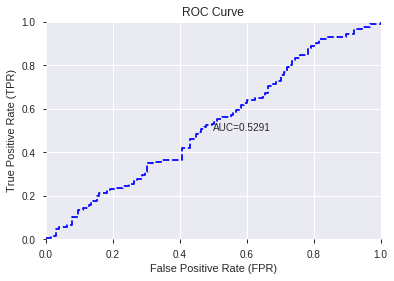

This function is available for GLM models only


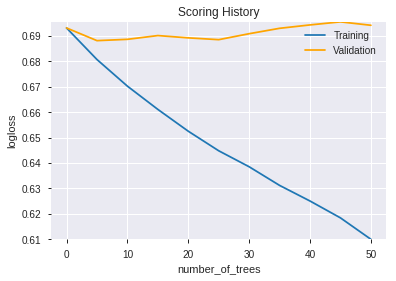

--2019-07-25 01:07:42--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.0.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.0.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genm

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_010654_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_010654_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_bd2d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['MINUS_DI_30',
 'DIV',
 'ADX_24',
 'ROC_24',
 'dayofweek',
 'day',
 'BETA_30',
 'BBANDS_lowerband_20_7_5',
 'OBV',
 'HT_DCPERIOD',
 'BETA_12',
 'CORREL_14',
 'MFI_12',
 'BETA_14',
 'MACDEXT_hist',
 'MFI_14',
 'DX_14',
 'BETA_8',
 'AdjClose',
 'TRIX_12',
 'BBANDS_lowerband_12_5_3',
 'BOP',
 'TRANGE',
 'HT_PHASOR_quadrature',
 'MACDEXT_signal',
 'PPO',
 'TRIX_14',
 'BBANDS_lowerband_20_7_4',
 'SUB',
 'MFI_24',
 'APO',
 'BBANDS_lowerband_24_7_5',
 'STDDEV_20',
 'TSF_14',
 'Volume',
 'LINEARREG_INTERCEPT_12',
 'HT_PHASOR_inphase',
 'BBANDS_upperband_30_6_5',
 'ADX_8',
 'STDDEV_14',
 'PLUS_DM_30',
 'PLUS_DM_24',
 'CORREL_8',
 'MOM_8',
 'ROC_8',
 'ULTOSC',
 'ROC_30',
 'WILLR_14',
 'TAN',
 'MFI_8',
 'LINEARREG_ANGLE_24',
 'MOM_24',
 'STOCHRSI_fastk',
 'MOM_14',
 'DX_8',
 'PLUS_DI_8',
 'ADX_12',
 'AROONOSC_30',
 'CORREL_30',
 'MACDFIX_signal_20',
 'SIN',
 'BBANDS_lowerband_24_6_5',
 'DX_20',
 'MINUS_DI_24',
 'CDLLONGLINE',
 'aroonup_8',
 'PLUS_DI_30',
 'CORREL_20',
 'BBANDS_lowerband_20_7_2',

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

442

['BBANDS_middleband_12_4_5',
 'BBANDS_lowerband_12_4_5',
 'MA_12_5',
 'MAVP_12_5',
 'BBANDS_upperband_12_5_2',
 'BBANDS_middleband_12_5_2',
 'BBANDS_lowerband_12_5_2',
 'BBANDS_upperband_12_5_3',
 'BBANDS_middleband_12_5_3',
 'BBANDS_lowerband_12_5_3',
 'BBANDS_upperband_12_5_4',
 'BBANDS_middleband_12_5_4',
 'BBANDS_lowerband_12_5_4',
 'BBANDS_upperband_12_5_5',
 'BBANDS_middleband_12_5_5',
 'BBANDS_lowerband_12_5_5',
 'MA_12_6',
 'MAVP_12_6',
 'BBANDS_upperband_12_6_2',
 'BBANDS_middleband_12_6_2',
 'BBANDS_lowerband_12_6_2',
 'BBANDS_upperband_12_6_3',
 'BBANDS_middleband_12_6_3',
 'BBANDS_lowerband_12_6_3',
 'BBANDS_upperband_12_6_4',
 'BBANDS_middleband_12_6_4',
 'BBANDS_lowerband_12_6_4',
 'BBANDS_upperband_12_6_5',
 'BBANDS_middleband_12_6_5',
 'BBANDS_lowerband_12_6_5',
 'MA_12_7',
 'MAVP_12_7',
 'BBANDS_upperband_12_7_2',
 'BBANDS_middleband_12_7_2',
 'BBANDS_lowerband_12_7_2',
 'BBANDS_upperband_12_7_3',
 'BBANDS_middleband_12_7_3',
 'BBANDS_lowerband_12_7_3',
 'BBANDS_upperb

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_010905_model_4  0.531556  1.853790              0.475968  0.667856  0.446032
1  DeepLearning_grid_1_AutoML_20190725_010905_model_6  0.530222  0.693730              0.483968  0.500290  0.250290
2  DeepLearning_grid_1_AutoML_20190725_010905_model_3  0.525333  0.865485              0.483905  0.553357  0.306204
3  DeepLearning_grid_1_AutoML_20190725_010905_model_2  0.511048  0.799642              0.487968  0.539819  0.291405
4  DeepLearning_grid_1_AutoML_20190725_010905_model_1  0.502286  1.595302              0.492000  0.619572  0.383870
5  DeepLearning_grid_1_AutoML_20190725_010905_model_8  0.500063  0.693264              0.496000  0.500058  0.250058
6               DeepLearning_1_AutoML_20190725_010905  0.500063  0.959971              0.495968  0.562773  0.316713
7  DeepLearning_grid_1_AutoML_20190725_010905_model_9  0.500000  0.693588              0.500000  0.500220  0.250220
8  DeepLearning_grid_1_AutoML_20190725_010905_model_5  0.489079  0.699139              0.496000  0.502979  0.252988
9  DeepLearning_grid_1_AutoML_20190725_010905_model_7  0.440381  1.455919              0.487968  0.654458  0.428315

variable  relative_importance  scaled_importance  percentage
0               CDLHIKKAKEMOD             1.000000           1.000000    0.004455
1                CDLBREAKAWAY             0.979438           0.979438    0.004363
2            CDLSTICKSANDWICH             0.906155           0.906155    0.004037
3          CDLMORNINGDOJISTAR             0.895443           0.895443    0.003989
4                   CDL2CROWS             0.890021           0.890021    0.003965
..                        ...                  ...                ...         ...
435  BBANDS_middleband_20_0_4             0.462933           0.462933    0.002062
436  BBANDS_middleband_20_5_3             0.458750           0.458750    0.002044
437   BBANDS_upperband_30_6_3             0.458584           0.458584    0.002043
438                    TRIX_8             0.457005           0.457005    0.002036
439                    MOM_14             0.456418           0.456418    0.002033

[440 rows x 4 columns]

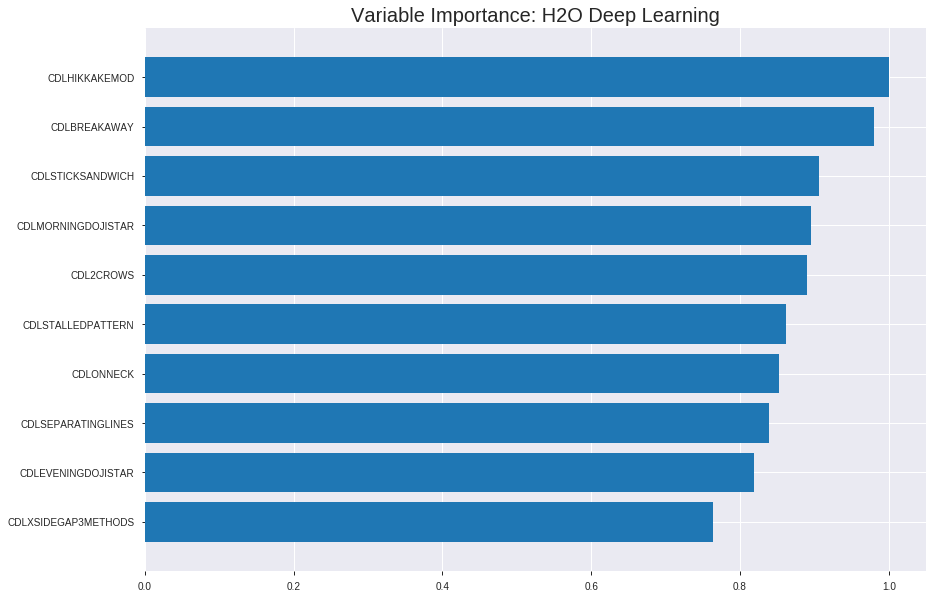

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_010905_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2749157281482216
RMSE: 0.5243240678704552
LogLoss: 0.8886648641757062
Mean Per-Class Error: 0.358967000501077
AUC: 0.695047797538866
pr_auc: 0.7007607646386665
Gini: 0.39009559507773206
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.03943700236753751: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      259  590   0.6949   (590.0/849.0)
1      100  805   0.1105   (100.0/905.0)
Total  359  1395  0.3934   (690.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.039437     0.7       364
max f2                       0.00661631   0.845865  393
max f0point5                 0.534447     0.654644  175
max accuracy                 0.212199     0.640821  280
max precision                0.994036     1         0
max recall                   0.00249133   1         397
max specificity              0.994036     1         0
max absolute_mcc             0.575401     0.292438  163
max min_per_class_accuracy   0.270214     0.638674  257
max mean_per_class_accuracy  0.534447     0.641033  175

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 39.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.987226           1.93812   1.93812            1                0.990465    1                           0.990465            0.0198895       0.0198895                  93.8122   93.8122
    2        0.0205245                   0.982566           1.39975   1.66894            0.722222         0.984859    0.861111                    0.987662            0.0143646       0.0342541                  39.9754   66.8938
    3        0.0302166                   0.978431           1.48209   1.60901            0.764706         0.980927    0.830189                    0.985502            0.0143646       0.0486188                  48.2093   60.9007
    4        0.0404789                   0.973165           1.39975   1.55596            0.722222         0.975592    0.802817                    0.982989            0.0143646       0.0629834                  39.9754   55.5957
    5        0.050171                    0.966842           1.5961    1.56371            0.823529         0.969315    0.806818                    0.980348            0.0154696       0.078453                   59.61     56.3712
    6        0.100342                    0.936535           1.56371   1.56371            0.806818         0.952581    0.806818                    0.966464            0.078453        0.156906                   56.3712   56.3712
    7        0.149943                    0.889738           1.49258   1.54018            0.770115         0.912444    0.794677                    0.948594            0.0740331       0.230939                   49.2576   54.018
    8        0.200114                    0.823885           1.43157   1.51295            0.738636         0.854821    0.780627                    0.925084            0.0718232       0.302762                   43.1567   51.295
    9        0.299886                    0.684344           1.16287   1.39648            0.6              0.762805    0.720532                    0.871094            0.116022        0.418785                   16.2873   39.6479
    10       0.400228                    0.478381           1.09019   1.31969            0.5625           0.584538    0.680912                    0.799251            0.109392        0.528177                   9.01934   31.969
    11       0.5                         0.276115           1.0632    1.26851            0.548571         0.371682    0.654504                    0.713932            0.106077        0.634254                   6.31981   26.8508
    12       0.599772                    0.149524           0.897073  1.20672            0.462857         0.212697    0.622624                    0.630552            0.0895028       0.723757                   -10.2927  20.672
    13       0.700114                    0.0755502          0.825904  1.15214            0.426136         0.108003    0.594463                    0.555659            0.0828729       0.80663                    -17.4096  15.2141
    14       0.799886                    0.0374622          0.852773  1.1148             0.44             0.0544259   0.575196                    0.493139            0.0850829       0.891713                   -14.7227  11.48
    15       0.899658                    0.0187363          0.664499  1.06486            0.342857         0.0278218   0.54943                     0.441535            0.0662983       0.958011                   -33.5501  6.48615
    16       1                           2.54407e-05        0.418458  1                  0.215909         0.00963811  0.515964       



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.35156487940217307
RMSE: 0.5929290677662659
LogLoss: 1.0819722374625924
Mean Per-Class Error: 0.4681567124522954
AUC: 0.5166180898858311
pr_auc: 0.5822657957231276
Gini: 0.033236179771662266
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.002896490971280916: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    221  1        (221.0/221.0)
1      0    281  0        (0.0/281.0)
Total  0    502  0.4402   (221.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.00289649   0.717752   399
max f2                       0.00289649   0.864084   399
max f0point5                 0.0228672    0.622407   379
max accuracy                 0.0228672    0.575697   379
max precision                0.90512      0.818182   10
max recall                   0.00289649   1          399
max specificity              0.96409      0.995475   0
max absolute_mcc             0.0228672    0.0980649  379
max min_per_class_accuracy   0.342431     0.505338   213
max mean_per_class_accuracy  0.521558     0.531843   138

Gains/Lift Table: Avg response rate: 55.98 %, avg score: 37.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.92624            1.19098   1.19098            0.666667         0.944728   0.666667                    0.944728            0.0142349       0.0142349                  19.0985    19.0985
    2        0.0219124                   0.904973           1.78648   1.46166            1                0.912193   0.818182                    0.929939            0.0177936       0.0320285                  78.6477    46.1663
    3        0.0318725                   0.890071           0.714591  1.2282             0.4              0.893649   0.6875                      0.918599            0.00711744      0.0391459                  -28.5409   22.8203
    4        0.0418327                   0.87807            1.42918   1.27605            0.8              0.883999   0.714286                    0.910361            0.0142349       0.0533808                  42.9181    27.6055
    5        0.0517928                   0.870215           0.357295  1.09937            0.2              0.874675   0.615385                    0.903498            0.00355872      0.0569395                  -64.2705   9.93704
    6        0.101594                    0.789909           1.2148    1.15596            0.68             0.828453   0.647059                    0.866711            0.0604982       0.117438                   21.4804    15.5956
    7        0.151394                    0.734385           0.78605   1.03428            0.44             0.756886   0.578947                    0.830584            0.0391459       0.156584                   -21.395    3.42761
    8        0.201195                    0.686179           1.00043   1.0259             0.56             0.710856   0.574257                    0.800949            0.0498221       0.206406                   0.0427046  2.58976
    9        0.300797                    0.552151           1.17907   1.07662            0.66             0.618662   0.602649                    0.740589            0.117438        0.323843                   17.9075    7.66185
    10       0.400398                    0.454722           0.893238  1.031              0.5              0.49517    0.577114                    0.679539            0.088968        0.412811                   -10.6762   3.10016
    11       0.5                         0.342007           0.928968  1.01068            0.52             0.392337   0.565737                    0.622328            0.0925267       0.505338                   -7.1032    1.06762
    12       0.599602                    0.21439            1.00043   1.00897            0.56             0.28037    0.564784                    0.565524            0.0996441       0.604982                   0.0427046  0.897365
    13       0.699203                    0.127754           0.893238  0.992487           0.5              0.167066   0.555556                    0.508764            0.088968        0.69395                    -10.6762   -0.751285
    14       0.798805                    0.0799545          1.00043   0.993477           0.56             0.101387   0.55611                     0.457969            0.0996441       0.793594                   0.0427046  -0.652284
    15       0.898406                    0.0445106          1.14335   1.01009            0.64             0.0630939  0.56541                     0.414191            0.113879        0.907473                   14.3345    1.00922
    16       1                           0.00286744         0.910753  1                  0.509804         0.0212948  0.559


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 01:12:34  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 01:12:39  6.607 sec         237 obs/sec       0.688141  1             1207       0.658759         2.59056             -0.737626      0.5418          0.504753           1.50743          0.484036                         0.663587           2.16125               -0.786917        0.484799          0.55324              0.595492           0.440239
    2019-07-25 01:12:54  21.849 sec        251 obs/sec       2.70468   4             4744       0.684244         2.92941             -0.874671      0.572721        0.608203           1.83045          0.484036                         0.734912           3.51837               -1.19169         0.473857          0.536907             0.595492           0.440239
    2019-07-25 01:13:12  39.084 sec        275 obs/sec       5.43158   8             9527       0.610544         1.54629             -0.492579      0.617454        0.621174           1.29208          0.484036                         0.647259           1.71144               -0.700065        0.518768          0.569821             0.595492           0.440239
    2019-07-25 01:13:27  54.760 sec        293 obs/sec       8.18016   12            14348      0.509915         0.76861             -0.0411125     0.697752        0.698569           1.72277          0.40878                          0.629431           1.21675               -0.607699        0.492866          0.531245             0.297746           0.428287
    2019-07-25 01:13:42  1 min  9.492 sec  308 obs/sec       10.9356   16            19181      0.556886         1.0592              -0.241754      0.689749        0.709378           1.83045          0.422463                         0.650421           1.44476               -0.716712        0.508704          0.551255             0.595492           0.436255
    2019-07-25 01:13:59  1 min 26.500 sec  324 obs/sec       14.3757   21            25215      0.524324         0.888665            -0.100785      0.695048        0.700761           1.93812          0.393387                         0.592929           1.08197               -0.42664         0.516618          0.582266             1.19098            0.440239
    2019-07-25 01:14:15  1 min 42.716 sec  337 obs/sec       17.7645   26            31159      0.470895         0.669366            0.112127       0.768579        0.789263           1.93812          0.3187                           0.63151            1.24249               -0.61834         0.493567          0.540763             0.595492           0.422311
    2019-07-25 01:14:31  1 min 58.530 sec  348 obs/sec       21.1864   31            37161      0.407623         0.495191            0.334695       0.841304        0.847749           1.93812          0.267959                         0.614277           1.14812               -0.531217        0.489018          0.544686             0.893238           0.440239
    2019-07-25 01:14:47

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLHIKKAKEMOD             1.0                    1.0                  0.004454741035705797
CDLBREAKAWAY              0.9794377684593201     0.9794377684593201   0.004363141619075845
CDLSTICKSANDWICH          0.9061545133590698     0.9061545133590698   0.004036683695350665
CDLMORNINGDOJISTAR        0.8954432606697083     0.8954432606697083   0.003988967838451552
CDL2CROWS                 0.8900207281112671     0.8900207281112671   0.003964811860146013
---                       ---                    ---                  ---
BBANDS_middleband_20_0_4  0.462933212518692      0.462933212518692    0.0020622475785981296
BBANDS_middleband_20_5_3  0.4587499499320984     0.4587499499320984   0.0020436122270904985
BBANDS_upperband_30_6_3   0.45858410000801086    0.45858410000801086  0.002042873408627897
TRIX_8                    0.4570048153400421     0.4570048153400421   0.0020358381044104355
MOM_14                    0.4564175605773926     0.4564175605773926   0.002033222036520847


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5378486055776892)

('F1', 0.6775067750677506)

('auc', 0.5315555555555556)

('logloss', 1.8537904365547337)

('mean_per_class_error', 0.4607619047619047)

('rmse', 0.6678561527534327)

('mse', 0.4460318407706164)

deeplearning prediction progress: |███████████████████████████████████████| 100%


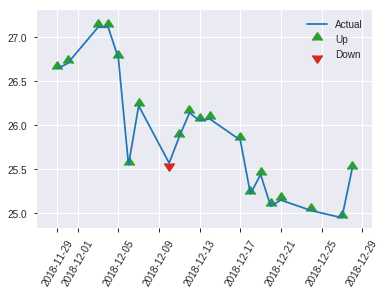


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.4460318407706164
RMSE: 0.6678561527534327
LogLoss: 1.8537904365547337
Mean Per-Class Error: 0.4607619047619047
AUC: 0.5315555555555556
pr_auc: 0.5166548903835722
Gini: 0.06311111111111112
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0006741009909131254: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    118  0.944    (118.0/125.0)
1      1    125  0.0079   (1.0/126.0)
Total  8    243  0.4741   (119.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.000674101  0.677507  242
max f2                       0.000435574  0.838881  246
max f0point5                 0.00110755   0.570501  237
max accuracy                 0.142209     0.537849  37
max precision                0.142209     0.631579  37
max recall                   0.000435574  1         246
max specificity              0.893439     0.992     0
max absolute_mcc             0.504231     0.157117  5
max min_per_class_accuracy   0.0267651    0.515873  124
max mean_per_class_accuracy  0.142209     0.539238  37

Gains/Lift Table: Avg response rate: 50.20 %, avg score:  8.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.675937           0         0                  0                0.791726    0                           0.791726            0               0                          -100      -100
    2        0.0239044                   0.504231           0         0                  0                0.573879    0                           0.682803            0               0                          -100      -100
    3        0.0318725                   0.472361           1.99206   0.498016           1                0.481375    0.25                        0.632446            0.015873        0.015873                   99.2063   -50.1984
    4        0.0438247                   0.461472           1.32804   0.724387           0.666667         0.465103    0.363636                    0.586807            0.015873        0.031746                   32.8042   -27.5613
    5        0.0517928                   0.44345            1.99206   0.919414           1                0.45598     0.461538                    0.56668             0.015873        0.047619                   99.2063   -8.05861
    6        0.103586                    0.216851           1.37912   1.14927            0.692308         0.313418    0.576923                    0.440049            0.0714286       0.119048                   37.9121   14.9267
    7        0.151394                    0.141904           1.49405   1.25815            0.75             0.175154    0.631579                    0.356398            0.0714286       0.190476                   49.4048   25.8145
    8        0.203187                    0.0938701          0.612943  1.09368            0.307692         0.118138    0.54902                     0.295665            0.031746        0.222222                   -38.7057  9.36819
    9        0.302789                    0.056997           0.95619   1.04845            0.48             0.0718423   0.526316                    0.222039            0.0952381       0.31746                    -4.38095  4.84545
    10       0.40239                     0.042297           0.796825  0.98617            0.4              0.0476689   0.49505                     0.178878            0.0793651       0.396825                   -20.3175  -1.383
    11       0.501992                    0.0264513          1.19524   1.02765            0.6              0.0330826   0.515873                    0.14995             0.119048        0.515873                   19.5238   2.76518
    12       0.601594                    0.0181685          1.03587   1.02901            0.52             0.0228328   0.516556                    0.128905            0.103175        0.619048                   3.5873    2.90129
    13       0.701195                    0.0125633          1.19524   1.05262            0.6              0.0156107   0.528409                    0.112812            0.119048        0.738095                   19.5238   5.26245
    14       0.800797                    0.00665685         0.876508  1.03072            0.44             0.00910345  0.517413                    0.0999126           0.0873016       0.825397                   -12.3492  3.07194
    15       0.900398                    0.00258445         0.876508  1.01366            0.44             0.00401378  0.50885                     0.0893043           0.0873016       0.912698                   -12.3492  1.36606
    16       1                           2.03342e-05        0.876508  1                  0.44             0.00110402  0.501992     

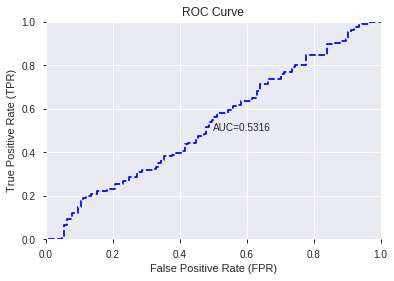

This function is available for GLM models only


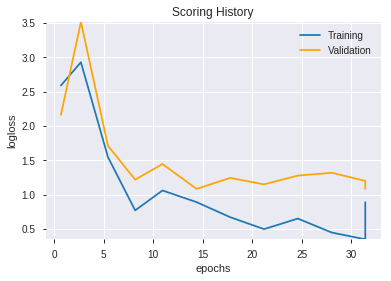

--2019-07-25 01:26:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.169.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.169.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_010905_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_010905_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_bd2d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLHIKKAKEMOD',
 'CDLBREAKAWAY',
 'CDLSTICKSANDWICH',
 'CDLMORNINGDOJISTAR',
 'CDL2CROWS',
 'CDLSTALLEDPATTERN',
 'CDLONNECK',
 'CDLSEPARATINGLINES',
 'CDLEVENINGDOJISTAR',
 'CDLXSIDEGAP3METHODS',
 'CDLGAPSIDESIDEWHITE',
 'CDLADVANCEBLOCK',
 'CDLEVENINGSTAR',
 'CDLGRAVESTONEDOJI',
 'CDLTHRUSTING',
 'CDLSHOOTINGSTAR',
 'CDLHANGINGMAN',
 'CDLDRAGONFLYDOJI',
 'CDLHOMINGPIGEON',
 'CDLDARKCLOUDCOVER',
 'CDLHAMMER',
 'CDLRICKSHAWMAN',
 'CDLMATCHINGLOW',
 'TRANGE',
 'CDLDOJI',
 'CORREL_8',
 'BETA_12',
 'VAR_8',
 'CDLSPINNINGTOP',
 'CDLENGULFING',
 'NATR_30',
 'CORREL_12',
 'CDLLONGLINE',
 'aroonup_24',
 'BBANDS_upperband_12_5_2',
 'ROCR100_24',
 'CDL3OUTSIDE',
 'BETA_8',
 'ROCR100_8',
 'BBANDS_upperband_14_2_5',
 'AROONOSC_8',
 'MINUS_DM_14',
 'ROCR_20',
 'DX_12',
 'CDLLONGLEGGEDDOJI',
 'MAVP_14_2',
 'AROONOSC_20',
 'MFI_14',
 'ADOSC',
 'ROCP_14',
 'BETA_14',
 'aroondown_24',
 'aroondown_30',
 'STDDEV_12',
 'MINUS_DM_20',
 'BBANDS_lowerband_20_5_4',
 'aroondown_14',
 'BBANDS_lowerband_14_0_

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_012705_model_1  0.55073  0.690019              0.483968  0.498437  0.248439

variable  relative_importance  scaled_importance    percentage
0                CDL3OUTSIDE         8.869081e-03           1.000000  1.843477e-02
1             CDLHARAMICROSS         7.459606e-03           0.841080  1.550511e-02
2              CDLHANGINGMAN         7.221485e-03           0.814231  1.501017e-02
3               CDLENGULFING         6.908453e-03           0.778937  1.435952e-02
4             CDLRICKSHAWMAN         6.562738e-03           0.739957  1.364093e-02
..                       ...                  ...                ...           ...
435                 TRIMA_14         3.283304e-06           0.000370  6.824489e-06
436  BBANDS_lowerband_12_7_4         2.875511e-06           0.000324  5.976875e-06
437                   SMA_14         1.895137e-06           0.000214  3.939124e-06
438                MAVP_12_6         1.727321e-07           0.000019  3.590312e-07
439                   EMA_24         1.233475e-07           0.000014  2.563831e-07

[440 rows x 4 columns]

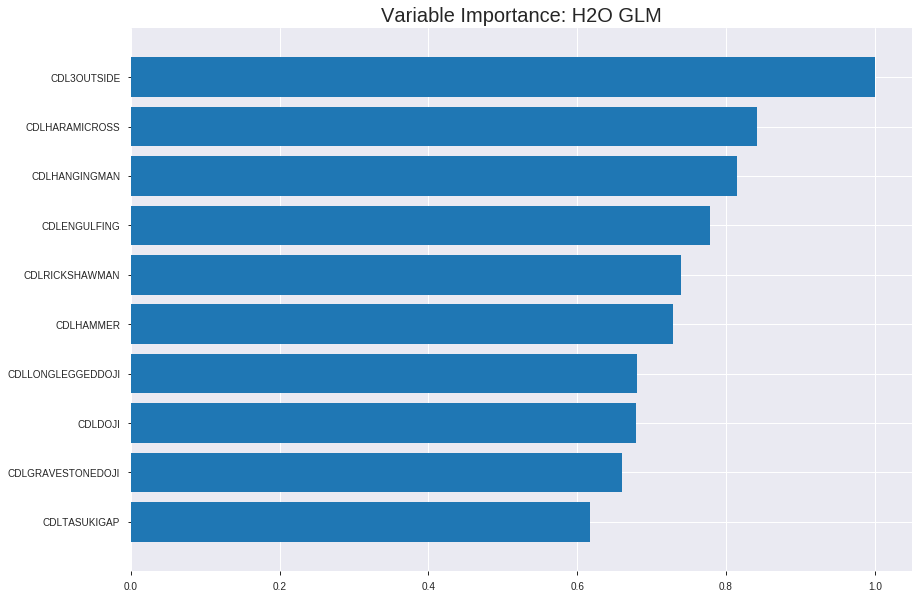

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_012705_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2469886736851068
RMSE: 0.4969795505703497
LogLoss: 0.6871038664684809
Null degrees of freedom: 1753
Residual degrees of freedom: 1313
Null deviance: 2429.7720921923756
Residual deviance: 2410.3603635714308
AIC: 3292.3603635714308
AUC: 0.5733804475853946
pr_auc: 0.5807060141412631
Gini: 0.14676089517078927
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4537645613784018: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      5    844   0.9941   (844.0/849.0)
1      0    905   0        (0.0/905.0)
Total  5    1749  0.4812   (844.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.453765     0.681989  394
max f2                       0.453765     0.842801  394
max f0point5                 0.500808     0.588184  264
max accuracy                 0.502194     0.565564  259
max precision                0.615788     1         0
max recall                   0.453765     1         394
max specificity              0.615788     1         0
max absolute_mcc             0.50191      0.128101  260
max min_per_class_accuracy   0.515961     0.555801  208
max mean_per_class_accuracy  0.50384      0.560159  254

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 51.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.578938           1.39975   1.39975            0.722222         0.589757  0.722222                    0.589757            0.0143646       0.0143646                  39.9754   39.9754
    2        0.0205245                   0.572319           1.29208   1.34592            0.666667         0.574981  0.694444                    0.582369            0.0132597       0.0276243                  29.2081   34.5918
    3        0.0302166                   0.566211           1.36809   1.35303            0.705882         0.56934   0.698113                    0.57819             0.0132597       0.040884                   36.8086   35.3028
    4        0.0404789                   0.561157           0.969061  1.25568            0.5              0.563228  0.647887                    0.574397            0.00994475      0.0508287                  -3.09392  25.5684
    5        0.050171                    0.558293           1.48209   1.29942            0.764706         0.559765  0.670455                    0.57157             0.0143646       0.0651934                  48.2093   29.9422
    6        0.100342                    0.549883           1.25537   1.2774             0.647727         0.553988  0.659091                    0.562779            0.0629834       0.128177                   25.5374   27.7398
    7        0.149943                    0.543403           1.06931   1.20856            0.551724         0.546207  0.623574                    0.557297            0.0530387       0.181215                   6.93084   20.8562
    8        0.200114                    0.539059           0.969061  1.14852            0.5              0.541135  0.592593                    0.553245            0.0486188       0.229834                   -3.09392  14.8516
    9        0.299886                    0.530795           1.05212   1.11645            0.542857         0.53481   0.576046                    0.547112            0.104972        0.334807                   5.21231   11.6446
    10       0.400228                    0.523173           1.09019   1.10986            0.5625           0.526866  0.57265                     0.542036            0.109392        0.444199                   9.01934   10.9864
    11       0.5                         0.515981           1.09642   1.10718            0.565714         0.519886  0.571266                    0.537616            0.109392        0.553591                   9.6423    10.7182
    12       0.599772                    0.508405           1.02997   1.09434            0.531429         0.512236  0.564639                    0.533394            0.102762        0.656354                   2.99732   9.43386
    13       0.700114                    0.49924            0.958049  1.07481            0.494318         0.503978  0.55456                     0.529178            0.0961326       0.752486                   -4.19513  7.48052
    14       0.799886                    0.492107           0.841699  1.04573            0.434286         0.495416  0.539558                    0.524967            0.0839779       0.836464                   -15.8301  4.57292
    15       0.899658                    0.482569           0.863848  1.02556            0.445714         0.487846  0.529151                    0.52085             0.0861878       0.922652                   -13.6152  2.55586
    16       1                           0.433145           0.770844  1                  0.397727         0.47215   0.515964                    0.515964         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2476321494871532
RMSE: 0.4976265160611452
LogLoss: 0.6884018987406914
Null degrees of freedom: 501
Residual degrees of freedom: 61
Null deviance: 692.5991909148838
Residual deviance: 691.1555063356542
AIC: 1573.155506335654
AUC: 0.5322217033542133
pr_auc: 0.5786419812301384
Gini: 0.06444340670842652
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46355730024138353: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    221  1        (221.0/221.0)
1      0    281  0        (0.0/281.0)
Total  0    502  0.4402   (221.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.463557     0.717752   399
max f2                       0.463557     0.864084   399
max f0point5                 0.49024      0.622297   351
max accuracy                 0.49024      0.575697   351
max precision                0.613194     1          0
max recall                   0.463557     1          399
max specificity              0.613194     1          0
max absolute_mcc             0.49024      0.0935982  351
max min_per_class_accuracy   0.516444     0.519573   203
max mean_per_class_accuracy  0.521688     0.533188   174

Gains/Lift Table: Avg response rate: 55.98 %, avg score: 51.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.576958           1.19098   1.19098            0.666667         0.587322  0.666667                    0.587322            0.0142349       0.0142349                  19.0985   19.0985
    2        0.0219124                   0.569847           0.357295  0.812035           0.2              0.572867  0.454545                    0.580752            0.00355872      0.0177936                  -64.2705  -18.7965
    3        0.0318725                   0.56042            0.714591  0.781584           0.4              0.563518  0.4375                      0.575366            0.00711744      0.024911                   -28.5409  -21.8416
    4        0.0418327                   0.557471           1.42918   0.935774           0.8              0.559107  0.52381                     0.571495            0.0142349       0.0391459                  42.9181   -6.42264
    5        0.0517928                   0.554348           1.42918   1.03066            0.8              0.555583  0.576923                    0.568435            0.0142349       0.0533808                  42.9181   3.06597
    6        0.101594                    0.545316           0.928968  0.980811           0.52             0.548715  0.54902                     0.558768            0.0462633       0.0996441                  -7.1032   -1.91892
    7        0.151394                    0.539892           1.14335   1.03428            0.64             0.541899  0.578947                    0.553219            0.0569395       0.156584                   14.3345   3.42761
    8        0.201195                    0.534497           1.2148    1.07896            0.68             0.537061  0.60396                     0.549219            0.0604982       0.217082                   21.4804   7.89613
    9        0.300797                    0.527693           1.03616   1.06479            0.58             0.531188  0.596026                    0.543249            0.103203        0.320285                   3.61566   6.47875
    10       0.400398                    0.522653           1.03616   1.05767            0.58             0.52466   0.59204                     0.538625            0.103203        0.423488                   3.61566   5.76654
    11       0.5                         0.516392           0.964698  1.03915            0.54             0.519893  0.581673                    0.534893            0.0960854       0.519573                   -3.53025  3.91459
    12       0.599602                    0.510122           0.928968  1.02084            0.52             0.513113  0.571429                    0.531275            0.0925267       0.6121                     -7.1032   2.08439
    13       0.699203                    0.503803           1.03616   1.02303            0.58             0.507099  0.57265                     0.527831            0.103203        0.715302                   3.61566   2.30252
    14       0.798805                    0.498803           1.03616   1.02466            0.58             0.501106  0.573566                    0.524499            0.103203        0.818505                   3.61566   2.46625
    15       0.898406                    0.490087           1.03616   1.02594            0.58             0.495157  0.574279                    0.521246            0.103203        0.921708                   3.61566   2.59368
    16       1                           0.463557           0.770637  1                  0.431373         0.48301   0.559761                    0.517361     


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 01:27:06  0.000 sec   2            3.2       441           1.37421           1.3768
    2019-07-25 01:27:06  0.454 sec   4            2.3       441           1.37184           1.37762
    2019-07-25 01:27:07  0.841 sec   6            1.7       441           1.36908           1.37867
    2019-07-25 01:27:07  1.247 sec   8            1.2       441           1.36591           1.38
    2019-07-25 01:27:08  1.638 sec   10           0.89      441           1.36233           1.38169
    2019-07-25 01:27:08  2.046 sec   12           0.65      441           1.35842           1.38381

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5697211155378487)

('F1', 0.6738544474393532)

('auc', 0.5507301587301586)

('logloss', 0.6900194730649486)

('mean_per_class_error', 0.4295555555555556)

('rmse', 0.4984369225672428)

('mse', 0.2484393657783036)

glm prediction progress: |████████████████████████████████████████████████| 100%


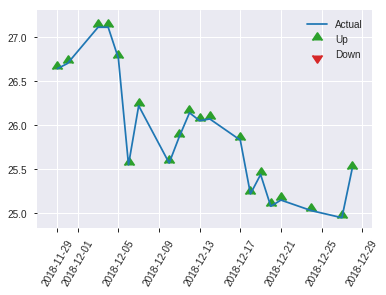


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2484393657783036
RMSE: 0.4984369225672428
LogLoss: 0.6900194730649486
Null degrees of freedom: 250
Residual degrees of freedom: -190
Null deviance: 348.1519924217104
Residual deviance: 346.3897754786042
AIC: 1228.3897754786042
AUC: 0.5507301587301586
pr_auc: 0.552516241299924
Gini: 0.10146031746031725
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44473236879939376: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    120  0.96     (120.0/125.0)
1      1    125  0.0079   (1.0/126.0)
Total  6    245  0.4821   (121.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.444732     0.673854  244
max f2                       0.433254     0.835544  249
max f0point5                 0.465953     0.570265  213
max accuracy                 0.502866     0.569721  79
max precision                0.559687     1         0
max recall                   0.433254     1         249
max specificity              0.559687     1         0
max absolute_mcc             0.502866     0.151173  79
max min_per_class_accuracy   0.488905     0.528     125
max mean_per_class_accuracy  0.502866     0.570444  79

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 49.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.552513           1.99206   1.99206            1                0.55502   1                           0.55502             0.0238095       0.0238095                  99.2063   99.2063
    2        0.0239044                   0.543392           1.32804   1.66005            0.666667         0.548193  0.833333                    0.551606            0.015873        0.0396825                  32.8042   66.0053
    3        0.0318725                   0.54158            0         1.24504            0                0.541979  0.625                       0.549199            0               0.0396825                  -100      24.504
    4        0.0438247                   0.54111            1.32804   1.26768            0.666667         0.541322  0.636364                    0.547051            0.015873        0.0555556                  32.8042   26.7677
    5        0.0517928                   0.53623            0         1.07265            0                0.539005  0.538462                    0.545813            0               0.0555556                  -100      7.26496
    6        0.103586                    0.523377           1.07265   1.07265            0.538462         0.529688  0.538462                    0.537751            0.0555556       0.111111                   7.26496   7.26496
    7        0.151394                    0.518758           1.32804   1.1533             0.666667         0.521048  0.578947                    0.532476            0.0634921       0.174603                   32.8042   15.33
    8        0.203187                    0.511933           1.37912   1.21086            0.692308         0.514786  0.607843                    0.527967            0.0714286       0.246032                   37.9121   21.0862
    9        0.302789                    0.503863           1.11556   1.17951            0.56             0.507544  0.592105                    0.521249            0.111111        0.357143                   11.5556   17.9511
    10       0.40239                     0.496961           0.876508  1.10451            0.44             0.49982   0.554455                    0.515945            0.0873016       0.444444                   -12.3492  10.451
    11       0.501992                    0.488905           0.876508  1.05927            0.44             0.493079  0.531746                    0.511408            0.0873016       0.531746                   -12.3492  5.92719
    12       0.601594                    0.481331           0.95619   1.04221            0.48             0.484945  0.523179                    0.507027            0.0952381       0.626984                   -4.38095  4.22054
    13       0.701195                    0.474408           0.876508  1.01867            0.44             0.47848   0.511364                    0.502972            0.0873016       0.714286                   -12.3492  1.86688
    14       0.800797                    0.468277           1.03587   1.02081            0.52             0.470697  0.512438                    0.498957            0.103175        0.81746                    3.5873    2.08087
    15       0.900398                    0.462859           1.03587   1.02248            0.52             0.465765  0.513274                    0.495286            0.103175        0.920635                   3.5873    2.24751
    16       1                           0.430125           0.796825  1                  0.4              0.452485  0.501992                    0.491023            0

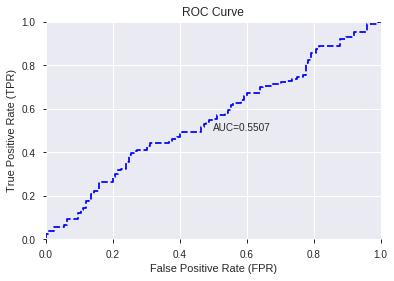

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


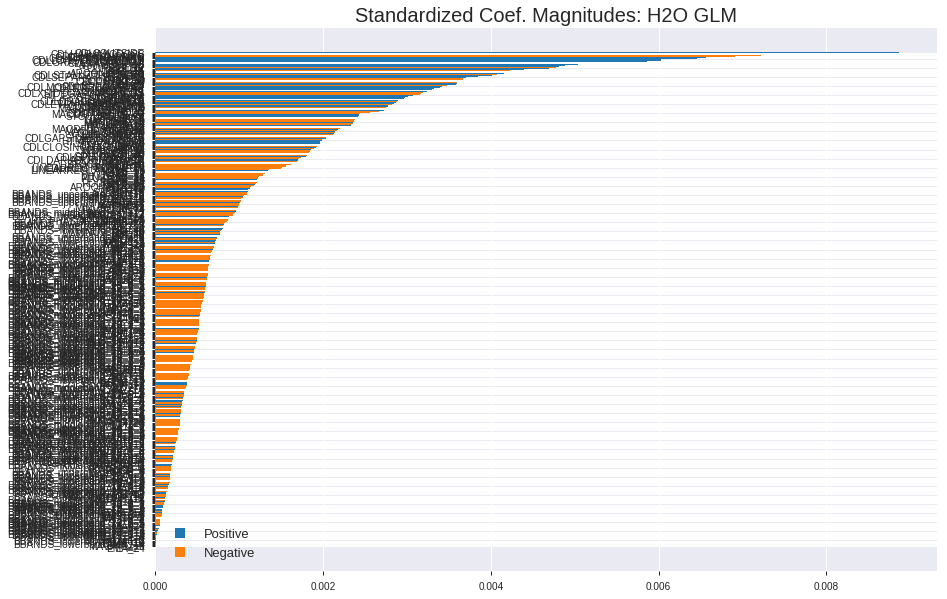

'log_likelihood'
--2019-07-25 01:27:19--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.238.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.238.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_012705_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_012705_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_bd2d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDL3OUTSIDE',
 'CDLHARAMICROSS',
 'CDLHANGINGMAN',
 'CDLENGULFING',
 'CDLRICKSHAWMAN',
 'CDLHAMMER',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'CDLGRAVESTONEDOJI',
 'CDLTASUKIGAP',
 'aroondown_30',
 'CCI_12',
 'CORREL_12',
 'OBV',
 'ADX_24',
 'CCI_14',
 'TRANGE',
 'AROONOSC_30',
 'ADX_20',
 'CDLSTALLEDPATTERN',
 'BETA_14',
 'CDLSEPARATINGLINES',
 'MFI_12',
 'ROC_30',
 'ROCR100_30',
 'CDLDOJISTAR',
 'MOM_30',
 'CCI_8',
 'MFI_14',
 'CDLBREAKAWAY',
 'CDLMORNINGDOJISTAR',
 'CDLEVENINGSTAR',
 'ADXR_14',
 'WILLR_14',
 'CDL2CROWS',
 'CDLXSIDEGAP3METHODS',
 'TRIX_14',
 'HT_PHASOR_inphase',
 'STOCHF_fastk',
 'CORREL_8',
 'CCI_20',
 'WILLR_12',
 'CDLDRAGONFLYDOJI',
 'CDLHIKKAKEMOD',
 'CDLHARAMI',
 'CDLEVENINGDOJISTAR',
 'MINUS_DI_8',
 'CDLSHORTLINE',
 'CDLHIKKAKE',
 'MACDFIX_signal_8',
 'BETA_12',
 'WILLR_20',
 'CDLBELTHOLD',
 'CDLMARUBOZU',
 'MACDFIX_signal_20',
 'STOCHRSI_fastd',
 'WILLR_24',
 'MFI_8',
 'aroonup_14',
 'MACDFIX_20',
 'MACDFIX_8',
 'MACDFIX_24',
 'BETA_8',
 'MACDFIX_14',
 'MACD',
 'A

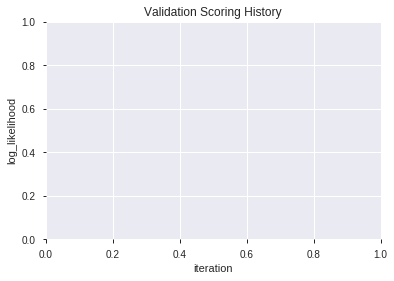

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_012729_model_3  0.523492  0.714896              0.484000  0.509568  0.259660
1  XGBoost_grid_1_AutoML_20190725_012729_model_1  0.513587  0.722697              0.496000  0.513362  0.263540
2  XGBoost_grid_1_AutoML_20190725_012729_model_7  0.513524  0.724431              0.496000  0.514068  0.264266
3  XGBoost_grid_1_AutoML_20190725_012729_model_6  0.512762  0.715577              0.496000  0.510054  0.260156
4               XGBoost_2_AutoML_20190725_012729  0.507810  0.706856              0.483968  0.506494  0.256536
5               XGBoost_1_AutoML_20190725_012729  0.503365  0.721597              0.500000  0.513141  0.263314
6  XGBoost_grid_1_AutoML_20190725_012729_model_4  0.496635  0.698270              0.475937  0.502513  0.252519
7  XGBoost_grid_1_AutoML_20190725_012729_model_2  0.485524  0.708905              0.496000  0.507591  0.257649
8               XGBoost_3_AutoML_20190725_012729  0.482857  0.727495              0.500000  0.515339  0.265575
9  XGBoost_grid_1_AutoML_20190725_012729_model_5  0.462286  0.769953              0.496000  0.532303  0.283347

variable  relative_importance  scaled_importance  percentage
0                         OBV            94.838577           1.000000    0.019038
1                     BETA_12            88.957367           0.937987    0.017858
2                       CCI_8            87.316910           0.920690    0.017528
3                   CORREL_12            82.971466           0.874870    0.016656
4                      TRANGE            79.102165           0.834072    0.015879
..                        ...                  ...                ...         ...
226              aroondown_14             3.184371           0.033577    0.000639
227   BBANDS_upperband_20_1_3             2.667741           0.028129    0.000536
228               MINUS_DM_30             2.396412           0.025268    0.000481
229   BBANDS_lowerband_12_5_3             1.546346           0.016305    0.000310
230  BBANDS_middleband_12_5_2             0.897243           0.009461    0.000180

[231 rows x 4 columns]

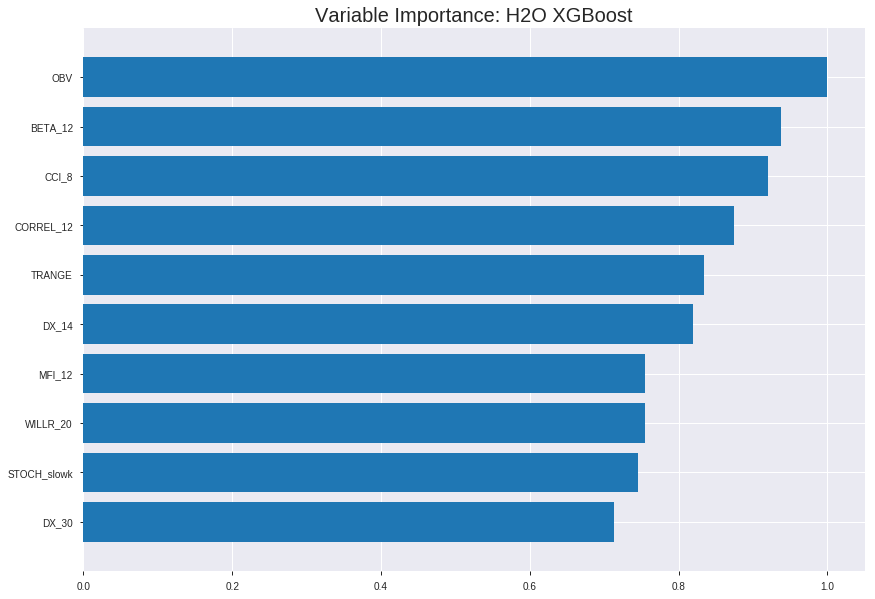

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_012729_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18708197835918405
RMSE: 0.43252974274514816
LogLoss: 0.5640136675994482
Mean Per-Class Error: 0.16152834989490394
AUC: 0.9172116692371265
pr_auc: 0.9177072273269371
Gini: 0.834423338474253
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4885299801826477: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      648  201   0.2367   (201.0/849.0)
1      90   815   0.0994   (90.0/905.0)
Total  738  1016  0.1659   (291.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.48853      0.848516  225
max f2                       0.450976     0.907683  261
max f0point5                 0.531949     0.857002  184
max accuracy                 0.507424     0.838655  207
max precision                0.766357     1         0
max recall                   0.367182     1         348
max specificity              0.766357     1         0
max absolute_mcc             0.507424     0.676968  207
max min_per_class_accuracy   0.509204     0.833922  205
max mean_per_class_accuracy  0.507424     0.838472  207

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 51.51 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.723969           1.93812    1.93812            1                0.738316  1                           0.738316            0.0198895       0.0198895                  93.8122   93.8122
    2        0.0205245                   0.710895           1.93812    1.93812            1                0.718267  1                           0.728291            0.0198895       0.039779                   93.8122   93.8122
    3        0.0302166                   0.698792           1.93812    1.93812            1                0.704324  1                           0.720604            0.0187845       0.0585635                  93.8122   93.8122
    4        0.0404789                   0.690993           1.93812    1.93812            1                0.694291  1                           0.713933            0.0198895       0.078453                   93.8122   93.8122
    5        0.050171                    0.685491           1.93812    1.93812            1                0.687574  1                           0.708841            0.0187845       0.0972376                  93.8122   93.8122
    6        0.100342                    0.654028           1.89407    1.9161             0.977273         0.66792   0.988636                    0.68838             0.0950276       0.192265                   89.4073   91.6097
    7        0.149943                    0.63293            1.84901    1.89391            0.954023         0.642341  0.977186                    0.673151            0.0917127       0.283978                   84.9013   89.3906
    8        0.200114                    0.613344           1.78395    1.86634            0.920455         0.622505  0.962963                    0.660453            0.0895028       0.373481                   78.3953   86.6339
    9        0.299886                    0.579418           1.6834     1.80547            0.868571         0.595374  0.931559                    0.638801            0.167956        0.541436                   68.3397   80.5474
    10       0.400228                    0.549146           1.5527     1.7421             0.801136         0.563714  0.89886                     0.619976            0.155801        0.697238                   55.27     74.2101
    11       0.5                         0.513306           1.27362    1.64862            0.657143         0.530567  0.850627                    0.602135            0.127072        0.824309                   27.3623   64.8619
    12       0.599772                    0.480346           0.863848   1.51807            0.445714         0.497237  0.78327                     0.584685            0.0861878       0.910497                   -13.6152  51.8072
    13       0.700114                    0.449667           0.605663   1.3873             0.3125           0.466516  0.715798                    0.567749            0.0607735       0.971271                   -39.4337  38.7304
    14       0.799886                    0.418544           0.210425   1.24051            0.108571         0.434627  0.640057                    0.551144            0.0209945       0.992265                   -78.9575  24.0508
    15       0.899658                    0.378413           0.0664499  1.11031            0.0342857        0.399995  0.572877                    0.534382            0.00662983      0.998895                   -93.355   11.0305
    16       1                           0.204652           0.0110121  1                  0.00568182       0.341924  0.515964                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2537054607026427
RMSE: 0.5036918310858761
LogLoss: 0.7011370615871192
Mean Per-Class Error: 0.4647590215938552
AUC: 0.5205954815542423
pr_auc: 0.5596189307318937
Gini: 0.04119096310848458
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2631990909576416: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    221  1        (221.0/221.0)
1      0    281  0        (0.0/281.0)
Total  0    502  0.4402   (221.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.263199     0.717752  399
max f2                       0.263199     0.864084  399
max f0point5                 0.336465     0.61681   380
max accuracy                 0.447716     0.565737  301
max precision                0.604997     0.596491  50
max recall                   0.263199     1         399
max specificity              0.693953     0.995475  0
max absolute_mcc             0.688269     0.101058  3
max min_per_class_accuracy   0.508807     0.529412  194
max mean_per_class_accuracy  0.481509     0.535241  248

Gains/Lift Table: Avg response rate: 55.98 %, avg score: 50.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.672642           0.595492  0.595492           0.333333         0.686973  0.333333                    0.686973            0.00711744      0.00711744                 -40.4508   -40.4508
    2        0.0219124                   0.654732           0.714591  0.649628           0.4              0.662546  0.363636                    0.67587             0.00711744      0.0142349                  -28.5409   -35.0372
    3        0.0318725                   0.645769           1.07189   0.781584           0.6              0.650467  0.4375                      0.667932            0.0106762       0.024911                   7.18861    -21.8416
    4        0.0418327                   0.635879           1.07189   0.850703           0.6              0.639901  0.47619                     0.661258            0.0106762       0.0355872                  7.18861    -14.9297
    5        0.0517928                   0.632787           1.42918   0.961949           0.8              0.633615  0.538462                    0.655942            0.0142349       0.0498221                  42.9181    -3.80509
    6        0.101594                    0.608211           1.07189   1.01584            0.6              0.616161  0.568627                    0.636441            0.0533808       0.103203                   7.18861    1.58398
    7        0.151394                    0.591553           1.07189   1.03428            0.6              0.600047  0.578947                    0.62447             0.0533808       0.156584                   7.18861    3.42761
    8        0.201195                    0.578177           0.78605   0.972834           0.44             0.584963  0.544554                    0.614691            0.0391459       0.19573                    -21.395    -2.71661
    9        0.300797                    0.550515           1.00043   0.981971           0.56             0.564871  0.549669                    0.598194            0.0996441       0.295374                   0.0427046  -1.80293
    10       0.400398                    0.527807           1.14335   1.02211            0.64             0.538474  0.572139                    0.583338            0.113879        0.409253                   14.3345    2.21136
    11       0.5                         0.509193           1.14335   1.04626            0.64             0.517356  0.585657                    0.570194            0.113879        0.523132                   14.3345    4.62633
    12       0.599602                    0.492265           0.893238  1.02084            0.5              0.50011   0.571429                    0.558553            0.088968        0.6121                     -10.6762   2.08439
    13       0.699203                    0.471964           1.10762   1.0332             0.62             0.482778  0.578348                    0.547758            0.11032         0.72242                    10.7616    3.32046
    14       0.798805                    0.444033           0.964698  1.02466            0.54             0.457921  0.573566                    0.536557            0.0960854       0.818505                   -3.53025   2.46625
    15       0.898406                    0.379247           0.964698  1.01801            0.54             0.415439  0.569845                    0.523129            0.0960854       0.914591                   -3.53025   1.80145
    16       1                           0.263199           0.840695  1                  0.470588         0.340528  0.559761             


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 01:27:40  3.242 sec   0                  0.5              0.693147            0.5             0                  1                0.484036                         0.5                0.693147              0.5               0                    1                  0.440239
    2019-07-25 01:27:41  3.552 sec   5                  0.488545         0.670445            0.764206        0.771788           1.93812          0.32041                          0.499878           0.692904              0.503092          0.550965             0.765633           0.434263
    2019-07-25 01:27:41  3.688 sec   10                 0.483247         0.660065            0.79833         0.80684            1.93812          0.309578                         0.500041           0.693234              0.504823          0.546378             0.595492           0.426295
    2019-07-25 01:27:41  3.836 sec   15                 0.476085         0.646149            0.827705        0.82572            1.93812          0.233751                         0.501906           0.696994              0.48302           0.53455              0.595492           0.432271
    2019-07-25 01:27:41  3.994 sec   20                 0.467766         0.630128            0.846113        0.846592           1.93812          0.231471                         0.501531           0.696254              0.502391          0.54822              0.297746           0.422311
    2019-07-25 01:27:41  4.170 sec   25                 0.460513         0.616336            0.866894        0.8651             1.93812          0.214937                         0.501466           0.696163              0.503905          0.547383             0.297746           0.428287
    2019-07-25 01:27:41  4.327 sec   30                 0.454363         0.604633            0.87723         0.878289           1.93812          0.202395                         0.503711           0.700822              0.500185          0.545026             0.595492           0.426295
    2019-07-25 01:27:41  4.508 sec   35                 0.447465         0.591717            0.893297        0.892002           1.93812          0.187001                         0.503403           0.700261              0.505878          0.548071             0.893238           0.428287
    2019-07-25 01:27:42  4.675 sec   40                 0.442265         0.581957            0.900625        0.900547           1.93812          0.176169                         0.504256           0.702157              0.50814           0.553396             0.893238           0.440239
    2019-07-25 01:27:42  4.864 sec   45                 0.435542         0.56959             0.912503        0.913069           1.93812          0.169897                         0.504303           0.702387              0.515797          0.557719             0.595492           0.438247
    2019-07-25 01:27:42  5.028 sec   50                 0.43253          0.564014            0.917212        0.917707           1.93812          0.165906                         0.503692           0.701137              0.520595          0.559619             0.595492           0.440239

Variable Importances: 


variable                  relative_importance    scaled_importance     percentage
------------------------  ---------------------  --------------------  ----------------------
OBV                       94.83857727050781      1.0                   0.019038177794946917
BETA_12                   88.95736694335938      0.9379871514692436    0.017857566159047263
CCI_8                     87.31690979003906      0.9206897899889965    0.017528255915802853
CORREL_12                 82.97146606445312      0.8748704214298137    0.016655938630720932
TRANGE                    79.10216522216797      0.8340716140916484    0.015879203682795155
---                       ---                    ---                   ---
aroondown_14              3.1843714714050293     0.033576752868426686  0.0006392401908861012
BBANDS_upperband_20_1_3   2.667741298675537      0.028129284258096215  0.0005355303149502372
MINUS_DM_30               2.396411895751953      0.02526832397450116   0.00048106284440687275
BBANDS_lowerband_12_5_3   1.5463457107543945     0.016305028557564258  0.00031041803263059524
BBANDS_middleband_12_5_2  0.897242546081543      0.009460733932377965  0.00018011513467529902


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.549800796812749)

('F1', 0.675603217158177)

('auc', 0.5234920634920635)

('logloss', 0.7148958840129485)

('mean_per_class_error', 0.45060317460317456)

('rmse', 0.5095681481652738)

('mse', 0.25965969762458646)

xgboost prediction progress: |████████████████████████████████████████████| 100%


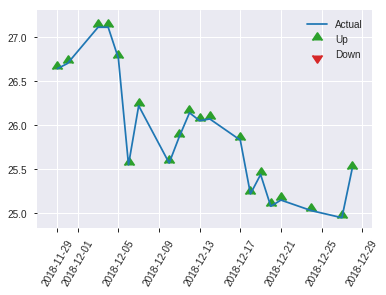


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25965969762458646
RMSE: 0.5095681481652738
LogLoss: 0.7148958840129485
Mean Per-Class Error: 0.45060317460317456
AUC: 0.5234920634920635
pr_auc: 0.5396019641750202
Gini: 0.046984126984126906
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1946934163570404: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    121  0.968    (121.0/125.0)
1      0    126  0        (0.0/126.0)
Total  4    247  0.4821   (121.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.194693     0.675603  246
max f2                       0.194693     0.838881  246
max f0point5                 0.194693     0.56553   246
max accuracy                 0.455175     0.549801  150
max precision                0.60462      0.764706  16
max recall                   0.194693     1         246
max specificity              0.666191     0.992     0
max absolute_mcc             0.599221     0.145951  19
max min_per_class_accuracy   0.474591     0.52      125
max mean_per_class_accuracy  0.455175     0.549397  150

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 46.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.651554           1.32804   1.32804            0.666667         0.660645  0.666667                    0.660645            0.015873        0.015873                   32.8042    32.8042
    2        0.0239044                   0.637905           0.664021  0.996032           0.333333         0.642706  0.5                         0.651676            0.00793651      0.0238095                  -33.5979   -0.396825
    3        0.0318725                   0.629162           1.99206   1.24504            1                0.635179  0.625                       0.647551            0.015873        0.0396825                  99.2063    24.504
    4        0.0438247                   0.623608           1.99206   1.44877            1                0.624175  0.727273                    0.641176            0.0238095       0.0634921                  99.2063    44.8773
    5        0.0517928                   0.611862           0.996032  1.37912            0.5              0.612319  0.692308                    0.636736            0.00793651      0.0714286                  -0.396825  37.9121
    6        0.103586                    0.589766           1.37912   1.37912            0.692308         0.600299  0.692308                    0.618518            0.0714286       0.142857                   37.9121    37.9121
    7        0.151394                    0.572616           0.830026  1.20572            0.416667         0.578762  0.605263                    0.605963            0.0396825       0.18254                    -16.9974   20.5723
    8        0.203187                    0.559146           0.919414  1.13274            0.461538         0.566061  0.568627                    0.595792            0.047619        0.230159                   -8.05861   13.2742
    9        0.302789                    0.525437           0.796825  1.02224            0.4              0.5411    0.513158                    0.577801            0.0793651       0.309524                   -20.3175   2.22431
    10       0.40239                     0.492435           1.11556   1.04534            0.56             0.510907  0.524752                    0.561243            0.111111        0.420635                   11.5556    4.53402
    11       0.501992                    0.474591           1.03587   1.04346            0.52             0.483415  0.52381                     0.545801            0.103175        0.52381                    3.5873     4.34618
    12       0.601594                    0.455175           1.27492   1.08178            0.64             0.46348   0.543046                    0.532172            0.126984        0.650794                   27.4921    8.17828
    13       0.701195                    0.43084            0.717143  1.02999            0.36             0.44438   0.517045                    0.519701            0.0714286       0.722222                   -28.2857   2.99874
    14       0.800797                    0.385483           0.796825  1.00099            0.4              0.40965   0.502488                    0.506013            0.0793651       0.801587                   -20.3175   0.0987128
    15       0.900398                    0.298723           0.95619   0.996032           0.48             0.343974  0.5                         0.488089            0.0952381       0.896825                   -4.38095   -0.396825
    16       1                           0.134047           1.03587   1                  0.52             0.242363  0.501992               

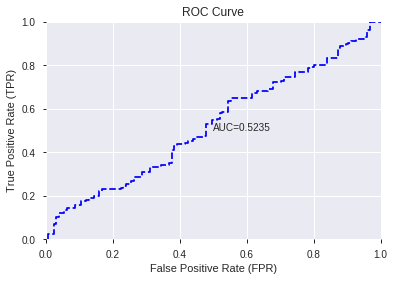

This function is available for GLM models only


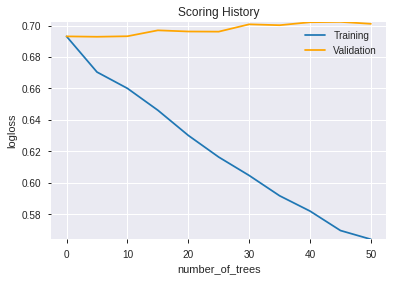

--2019-07-25 01:27:57--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.229.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.229.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_012729_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_012729_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_bd2d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['OBV',
 'BETA_12',
 'CCI_8',
 'CORREL_12',
 'TRANGE',
 'DX_14',
 'MFI_12',
 'WILLR_20',
 'STOCH_slowk',
 'DX_30',
 'MACDFIX_hist_12',
 'ADOSC',
 'ADX_20',
 'BBANDS_lowerband_30_1_5',
 'ADX_8',
 'MOM_24',
 'MFI_14',
 'CCI_20',
 'ADX_24',
 'MFI_8',
 'APO',
 'BBANDS_lowerband_14_0_2',
 'ADXR_8',
 'MACDEXT_hist',
 'BETA_14',
 'MOM_12',
 'PLUS_DM_8',
 'DX_12',
 'ATR_8',
 'PLUS_DI_24',
 'STOCHF_fastk',
 'BETA_8',
 'MACDFIX_signal_8',
 'MFI_20',
 'aroondown_30',
 'PLUS_DM_14',
 'WILLR_12',
 'AROONOSC_30',
 'STDDEV_8',
 'ADXR_14',
 'ATR_24',
 'CORREL_8',
 'LINEARREG_SLOPE_12',
 'ROCP_14',
 'MACDEXT',
 'PLUS_DM_24',
 'ROCR100_14',
 'HT_PHASOR_inphase',
 'LINEARREG_ANGLE_8',
 'MFI_30',
 'ROCP_20',
 'NATR_14',
 'TRIX_8',
 'WILLR_14',
 'STOCHRSI_fastd',
 'BBANDS_upperband_30_7_3',
 'ROC_24',
 'MACDEXT_signal',
 'CCI_12',
 'ROCR100_30',
 'AD',
 'TRIX_14',
 'AROONOSC_12',
 'CMO_20',
 'ADXR_12',
 'HT_PHASOR_quadrature',
 'RSI_12',
 'STDDEV_12',
 'PLUS_DI_8',
 'BBANDS_lowerband_30_7_3',
 'BBANDS_midd

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.570
GLM             0.570
XGBoost         0.582
dtype: float64

DeepLearning    GLM  XGBoost
All          0.570  0.562    0.554
DLF          0.534  0.534    0.582
Fwe          0.566  0.562    0.554
RFE          0.538  0.570    0.550
XGBF         0.534  0.534    0.582





F1


DeepLearning    0.679
GLM             0.676
XGBoost         0.676
dtype: float64

DeepLearning    GLM  XGBoost
All          0.678  0.676    0.674
DLF          0.677  0.668    0.672
Fwe          0.679  0.676    0.674
RFE          0.678  0.674    0.676
XGBF         0.672  0.668    0.672





auc


DeepLearning    0.575
GLM             0.551
XGBoost         0.532
dtype: float64

DeepLearning    GLM  XGBoost
All          0.575  0.534    0.529
DLF          0.525  0.500    0.532
Fwe          0.551  0.534    0.529
RFE          0.532  0.551    0.523
XGBF         0.508  0.500    0.532





logloss


DeepLearning    1.854
GLM             0.695
XGBoost         0.715
dtype: float64

DeepLearning    GLM  XGBoost
All          0.692  0.691    0.695
DLF          0.809  0.695    0.710
Fwe          1.006  0.691    0.695
RFE          1.854  0.690    0.715
XGBF         1.396  0.695    0.710





mean_per_class_error


DeepLearning    0.466
GLM             0.468
XGBoost         0.451
dtype: float64

DeepLearning    GLM  XGBoost
All          0.431  0.438    0.448
DLF          0.466  0.468    0.419
Fwe          0.433  0.438    0.448
RFE          0.461  0.430    0.451
XGBF         0.466  0.468    0.419





rmse


DeepLearning    0.668
GLM             0.501
XGBoost         0.510
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.499    0.501
DLF          0.542  0.501    0.508
Fwe          0.589  0.499    0.501
RFE          0.668  0.498    0.510
XGBF         0.601  0.501    0.508





mse


DeepLearning    0.446
GLM             0.251
XGBoost         0.260
dtype: float64

DeepLearning    GLM  XGBoost
All          0.250  0.249    0.251
DLF          0.293  0.251    0.258
Fwe          0.347  0.249    0.251
RFE          0.446  0.248    0.260
XGBF         0.361  0.251    0.258

{'F1':       DeepLearning    GLM  XGBoost
 All          0.678    NaN      NaN
 DLF          0.677    NaN      NaN
 DLF            NaN  0.668      NaN
 DLF            NaN    NaN    0.672
 All            NaN  0.676      NaN
 All            NaN    NaN    0.674
 XGBF         0.672    NaN      NaN
 XGBF           NaN  0.668      NaN
 XGBF           NaN    NaN    0.672
 Fwe          0.679    NaN      NaN
 Fwe            NaN  0.676      NaN
 Fwe            NaN    NaN    0.674
 RFE          0.678    NaN      NaN
 RFE            NaN  0.674      NaN
 RFE            NaN    NaN    0.676,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.570    NaN      NaN
 DLF          0.534    NaN      NaN
 DLF            NaN  0.534      NaN
 DLF            NaN    NaN    0.582
 All            NaN  0.562      NaN
 All            NaN    NaN    0.554
 XGBF         0.534    NaN      NaN
 XGBF           NaN  0.534      NaN
 XGBF           NaN    NaN    0.582
 Fwe          0.566    NaN      NaN
 Fwe     